Conectando ao Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


# **1- Importando Bibliotecas**

In [ ]:
# Atualizar o scikit-learn
#!pip install scikit-learn --upgrade
import sklearn
sklearn.__version__

'1.4.2'

In [ ]:
import numpy as np
import cv2
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV                           #Módulo para a aplicação do Random Search
from sklearn.metrics import make_scorer                                          #Módulo para a aplicação do Grid Search
import random
import pickle
from scipy.stats import uniform, randint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  #Métricas
import joblib
from sklearn.metrics import confusion_matrix, classification_report              #Módulo para a aplicação da matriz de confusão
from sklearn.metrics import ConfusionMatrixDisplay                               #Módulo para a aplicação da matriz de confusão
from sklearn.preprocessing import LabelEncoder
from plotnine import *

# **Imagens Inteiras**

In [ ]:
# ================================================================================
# Configurações gerais do treinamento
# ================================================================================

# Define Stratified Group 10-fold cross-validation
cv = StratifiedGroupKFold(n_splits = 5)

# Define as métricas de desempenho
metrics = {'accuracy' : make_scorer(accuracy_score),
           'precision' : make_scorer(precision_score, average = 'weighted'),
           'recall' : make_scorer(recall_score, average = 'weighted'),
           'f1_score' : make_scorer(f1_score, average = 'weighted')}

## **ResNet50**

In [ ]:
#-----------------------------------------------------------------------------#
# Carregar o arquivo com as features
#-----------------------------------------------------------------------------#
with np.load('./Output/CNN/Features/features_resnet_train.npz', mmap_mode= 'r', allow_pickle=True) as f:
    X_train = f['X_train']
    y_train = f['y_train']
    sample_train = f['sample_train']

with np.load('./Output/CNN/Features/features_resnet_test.npz', mmap_mode= 'r', allow_pickle=True) as f:
    X_test = f['X_test']
    y_test = f['y_test']
    sample_test = f['sample_test']

In [ ]:
#------------------------------------------------------------------------------#
# Tamanho do conjunto de dados
#------------------------------------------------------------------------------#
print(f'X_train_resnet: {X_train.shape}')
print(f'y_train_resnet: {y_train.shape}')
print(f'X_test_resnet: {X_test.shape}')
print(f'y_test_resnet: {y_test.shape}')

### Artificial Neural Networks - ANN

In [ ]:
# ================================================================================
# Definições do estimador ANN
# ================================================================================
# MLPClassifier().get_params()

# Define o modelo
model_ann = MLPClassifier(random_state = 10, max_iter = 2000)

In [ ]:
# ================================================================================
# Ajuste de Hiperparâmetros (Hyperparameter tuning) - RandomizedSearchCV()
# ================================================================================

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,), (200,), (250,),
                          (300,), (350,), (400,), (450,),(500,)],
    'activation': ['relu', 'identity'],    # ['relu', 'tanh', 'logistic', 'identity']
    'solver': ['adam', 'lbfgs'],           # ['sgd', 'adam', 'lbfgs']
    'alpha': uniform(loc = 0.0001, scale = 0.09).rvs(size = 20, random_state = 10),
    'learning_rate': ['constant','adaptive', 'invscaling']}

# Create the RandomizedSearchCV object
rs_ann = RandomizedSearchCV(estimator = model_ann, param_distributions = param_grid,
                                 scoring = metrics, cv = cv, refit = 'accuracy',
                                 verbose = 3, return_train_score = False, n_iter = 20)


rs_ann.fit(X_train, y_train, groups = sample_train)

pickle.dump(rs_ann, open(f'./Output/CNN/Models/rs_resnet_ann.pickle', "wb"))
joblib.dump(rs_ann, f'./Output/CNN/Models/rs_resnet_ann.joblib')

print(f'Os melhores parâmetros foram: {rs_ann.best_params_}')
print(f'A melhor acurácia foi de: {rs_ann.best_score_:.4f}')
print(f'O melhor modelo foi: {rs_ann.best_estimator_}')

In [ ]:
# ================================================================================
# Desempenho na Validação Cruzada (Stratified Group 5-fold cross-validation)
# ================================================================================
res1_rs_ann = pd.DataFrame(rs_ann.cv_results_).filter(regex = r'(params|test)').sort_values(by=["rank_test_accuracy"])

accf1_rs_ann = res1_rs_ann.iloc[0].filter(regex = r'(accuracy|f1)').filter(regex = 'split')
min_acc_rs_ann = accf1_rs_ann.filter(regex = 'accuracy').min()
max_acc_rs_ann = accf1_rs_ann.filter(regex = 'accuracy').max()
min_f1_rs_ann = accf1_rs_ann.filter(regex = 'f1').min()
max_f1_rs_ann = accf1_rs_ann.filter(regex = 'f1').max()

print(f'Acurácia min: {min_acc_rs_ann:.6f}')
print(f'Acurácia max: {max_acc_rs_ann:.6f}')
print(f'F1 min: {min_f1_rs_ann:.6f}')
print(f'F1 max: {max_f1_rs_ann:.6f}')

res2_rs_ann = res1_rs_ann.filter(regex = r'(mean|std|params)')
display(res2_rs_ann.iloc[0])

Acurácia min: 0.686801
Acurácia max: 0.699115
F1 min: 0.672428
F1 max: 0.694144


params                 {'solver': 'adam', 'learning_rate': 'constant'...
mean_test_accuracy                                              0.693324
std_test_accuracy                                               0.004396
mean_test_precision                                             0.700898
std_test_precision                                              0.013925
mean_test_recall                                                0.693324
std_test_recall                                                 0.004396
mean_test_f1_score                                              0.687267
std_test_f1_score                                               0.007782
Name: 6, dtype: object

In [ ]:
# ================================================================================
# Desempenho no conjunto de teste (n = 566)
# ================================================================================
y_pred_rs_ann = rs_ann.predict(X_test)
accuracy_rs_ann = accuracy_score(y_test, y_pred_rs_ann)
f1_rs_ann = f1_score(y_test, y_pred_rs_ann, average = 'weighted')
print(f"Best ANN Accuracy: {accuracy_rs_ann:.6f}")
print(f"Best ANN F1: {f1_rs_ann:.6f}")

Best ANN Accuracy: 0.819788
Best ANN F1: 0.820812


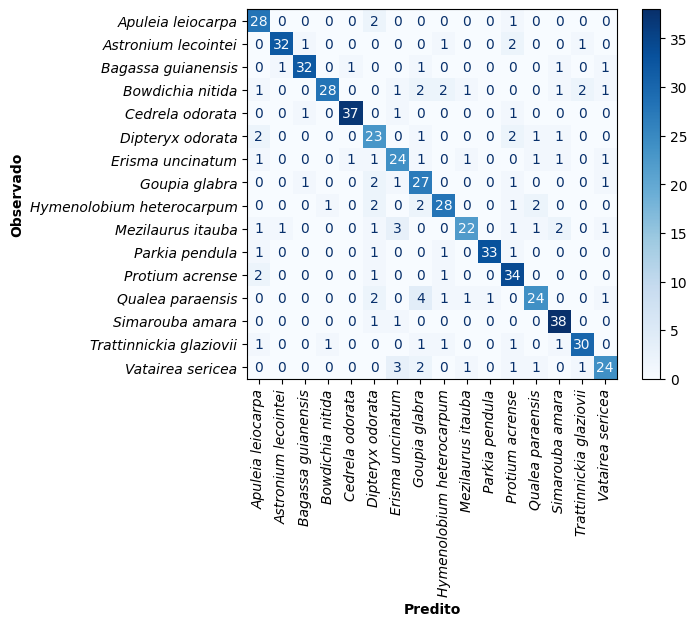

In [ ]:
# ================================================================================
# Matriz de Confusão - conjunto de teste (n = 566)
# ================================================================================
cm = confusion_matrix(y_test, y_pred_rs_ann)
disp_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels= rs_ann.classes_)
disp_cm.plot(cmap = 'Blues', xticks_rotation = 90)
disp_cm.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_cm.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_cm.ax_.xaxis.set_tick_params(labelsize=10)
disp_cm.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output/CNN/CM/cm_ann_resnet', dpi = 800, bbox_inches='tight')
plt.show()


In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================

print(classification_report(y_test, y_pred_rs_ann))

                           precision    recall  f1-score   support

        Apuleia leiocarpa       0.76      0.90      0.82        31
      Astronium lecointei       0.94      0.86      0.90        37
       Bagassa guianensis       0.91      0.86      0.89        37
         Bowdichia nitida       0.93      0.72      0.81        39
          Cedrela odorata       0.95      0.93      0.94        40
         Dipteryx odorata       0.64      0.77      0.70        30
         Erisma uncinatum       0.71      0.75      0.73        32
            Goupia glabra       0.66      0.82      0.73        33
Hymenolobium heterocarpum       0.80      0.78      0.79        36
        Mezilaurus itauba       0.85      0.67      0.75        33
           Parkia pendula       0.97      0.89      0.93        37
          Protium acrense       0.74      0.89      0.81        38
         Qualea paraensis       0.80      0.71      0.75        34
          Simarouba amara       0.84      0.95      0.89     

### Suport Vector Classifier - SVC

In [ ]:
# ================================================================================
# Definições do estimador SVC
# ================================================================================
# SVC().get_params()

# Define o modelo
model_svc = SVC(decision_function_shape = 'ovo', probability = True)

In [ ]:
# ================================================================================
# Ajuste de Hiperparâmetros (Hyperparameter tuning) - RandomizedSearchCV()
# ================================================================================

param_grid = {
    'C': uniform(loc = 0.1, scale = 10).rvs(size = 20, random_state = 10),             # Uniform distribution between 0.1 and 10
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto'] + list(np.logspace(-9, 3, 13))
}

# Create the RandomizedSearchCV object
rs_svc = RandomizedSearchCV(estimator = model_svc, param_distributions = param_grid,
                                 scoring = metrics, cv = cv, refit = 'accuracy',
                                 verbose = 3, return_train_score = False, n_iter = 20)


rs_svc.fit(X_train, y_train, groups = sample_train)

pickle.dump(rs_svc, open(f'./Output/CNN/Models/rs_resnet_svc.pickle', "wb"))
joblib.dump(rs_svc, f'./Output/CNN/Models/rs_resnet_svc.joblib')

print(f'Os melhores parâmetros foram: {rs_svc.best_params_}')
print(f'A melhor acurácia foi de: {rs_svc.best_score_:.4f}')
print(f'O melhor modelo foi: {rs_svc.best_estimator_}')

In [ ]:
# ================================================================================
# Desempenho na Validação Cruzada (Stratified Group 5-fold cross-validation)
# ================================================================================
res1_rs_svc = pd.DataFrame(rs_svc.cv_results_).filter(regex = r'(params|test)').sort_values(by=["rank_test_accuracy"])

accf1_rs_svc = res1_rs_svc.iloc[0].filter(regex = r'(accuracy|f1)').filter(regex = 'split')
min_acc_rs_svc = accf1_rs_svc.filter(regex = 'accuracy').min()
max_acc_rs_svc = accf1_rs_svc.filter(regex = 'accuracy').max()
min_f1_rs_svc = accf1_rs_svc.filter(regex = 'f1').min()
max_f1_rs_svc = accf1_rs_svc.filter(regex = 'f1').max()

print(f'Acurácia min: {min_acc_rs_svc:.6f}')
print(f'Acurácia max: {max_acc_rs_svc:.6f}')
print(f'F1 min: {min_f1_rs_svc:.6f}')
print(f'F1 max: {max_f1_rs_svc:.6f}')

res2_rs_svc = res1_rs_svc.filter(regex = r'(mean|std|params)')
display(res2_rs_svc.iloc[0])

Acurácia min: 0.644944
Acurácia max: 0.710177
F1 min: 0.632971
F1 max: 0.706596


params                 {'kernel': 'linear', 'gamma': 1e-06, 'degree':...
mean_test_accuracy                                              0.673591
std_test_accuracy                                               0.025257
mean_test_precision                                             0.680914
std_test_precision                                              0.026566
mean_test_recall                                                0.673591
std_test_recall                                                 0.025257
mean_test_f1_score                                              0.667905
std_test_f1_score                                               0.027284
Name: 0, dtype: object

In [ ]:
# ================================================================================
# Desempenho no conjunto de teste (n = 566)
# ================================================================================
y_pred_rs_svc = rs_svc.predict(X_test)
accuracy_rs_svc = accuracy_score(y_test, y_pred_rs_svc)
f1_rs_svc = f1_score(y_test, y_pred_rs_svc, average = 'weighted')
print(f"Best SVC Accuracy: {accuracy_rs_svc:.6f}")
print(f"Best SVC F1: {f1_rs_svc:.6f}")

Best SVC Accuracy: 0.826855
Best SVC F1: 0.826276


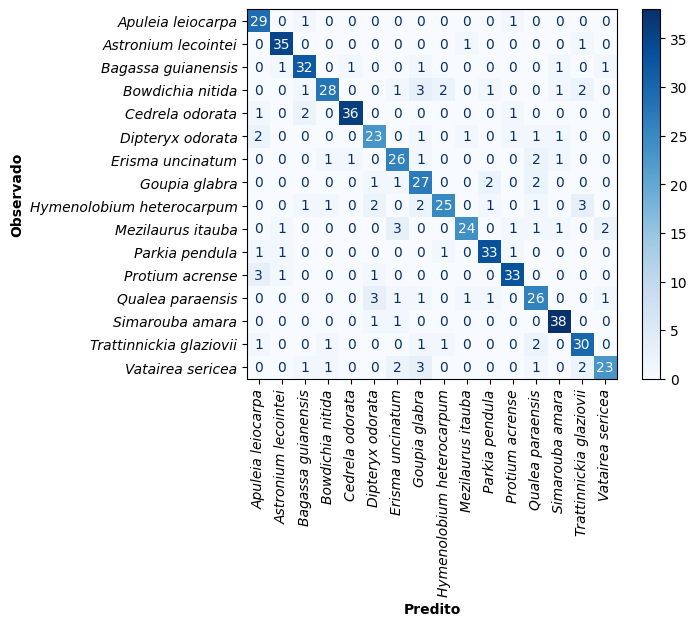

In [ ]:
# ================================================================================
# Matriz de Confusão - conjunto de teste (n = 566)
# ================================================================================
cm_svc = confusion_matrix(y_test, y_pred_rs_svc)
disp_cm_svc = ConfusionMatrixDisplay(confusion_matrix = cm_svc, display_labels= rs_svc.classes_)
disp_cm_svc.plot(cmap = 'Blues', xticks_rotation = 90)
disp_cm_svc.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_cm_svc.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_cm_svc.ax_.xaxis.set_tick_params(labelsize=10)
disp_cm_svc.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output/CNN/CM/cm_svc_resnet', dpi = 800, bbox_inches='tight')
plt.show()


In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================

print(classification_report(y_test, y_pred_rs_svc))

                           precision    recall  f1-score   support

        Apuleia leiocarpa       0.78      0.94      0.85        31
      Astronium lecointei       0.90      0.95      0.92        37
       Bagassa guianensis       0.84      0.86      0.85        37
         Bowdichia nitida       0.88      0.72      0.79        39
          Cedrela odorata       0.95      0.90      0.92        40
         Dipteryx odorata       0.74      0.77      0.75        30
         Erisma uncinatum       0.74      0.81      0.78        32
            Goupia glabra       0.68      0.82      0.74        33
Hymenolobium heterocarpum       0.86      0.69      0.77        36
        Mezilaurus itauba       0.89      0.73      0.80        33
           Parkia pendula       0.87      0.89      0.88        37
          Protium acrense       0.87      0.87      0.87        38
         Qualea paraensis       0.72      0.76      0.74        34
          Simarouba amara       0.88      0.95      0.92     

### Random Forest - RF

In [ ]:
# ================================================================================
# Definições do estimador RF
# ================================================================================
#RandomForestClassifier().get_params()

# Define o modelo
model_rf = RandomForestClassifier(random_state = 10)

In [ ]:
# ================================================================================
# Ajuste de Hiperparâmetros (Hyperparameter tuning) - RandomizedSearchCV()
# ================================================================================

param_grid = {'n_estimators': np.arange(40, 320, 20),                        # Número de árvores (estimadores) na floresta aleatória
              'max_depth': list(np.arange(10, 100, step=10)) + [None],       # Número máximo de níveis na árvore
              'max_features': list(np.arange(30, 60, 5)) + ['sqrt', "log2"], # Número de variáveis a serem considerados em cada divisão
              'criterion': ['gini','entropy'],
              'min_samples_leaf': np.arange(10, 110, 10),                    # Número mínimo de amostras exigidos em cada nó folha (terminal)
              'min_samples_split': np.arange(2, 10, 2),                      # Número mínimo de amostras exigido para dividir um nó
              'bootstrap': [True, False]                                     # Método de seleção de amostras para treinamento de cada árvore
              }

# Create the RandomizedSearchCV object
rs_rf = RandomizedSearchCV(estimator = model_rf, param_distributions = param_grid,
                           scoring = metrics, cv = cv, refit = 'accuracy',
                           verbose = 3, return_train_score = False, n_iter = 50)

rs_rf.fit(X_train, y_train, groups = sample_train)

pickle.dump(rs_rf, open(f'./Output/CNN/Models/rs_resnet_rf.pickle', "wb"))
joblib.dump(rs_rf, f'./Output/CNN/Models/rs_resnet_rf.joblib')

print(f'Melhores hiperparâmetros: {rs_rf.best_params_}')
print(f'Melhor Acurácia: {rs_rf.best_score_}')
print(f'Melhor Estimador: {rs_rf.best_estimator_}')

In [ ]:
# ================================================================================
# Desempenho na Validação Cruzada (Stratified Group 5-fold cross-validation)
# ================================================================================
res1_rs_rf = pd.DataFrame(rs_rf.cv_results_).filter(regex = r'(params|test)').sort_values(by=["rank_test_accuracy"])

accf1_rs_rf = res1_rs_rf.iloc[0].filter(regex = r'(accuracy|f1)').filter(regex = 'split')
min_acc_rs_rf = accf1_rs_rf.filter(regex = 'accuracy').min()
max_acc_rs_rf = accf1_rs_rf.filter(regex = 'accuracy').max()
min_f1_rs_rf = accf1_rs_rf.filter(regex = 'f1').min()
max_f1_rs_rf = accf1_rs_rf.filter(regex = 'f1').max()

print(f'Acurácia min: {min_acc_rs_rf:.6f}')
print(f'Acurácia max: {max_acc_rs_rf:.6f}')
print(f'F1 min: {min_f1_rs_rf:.6f}')
print(f'F1 max: {max_f1_rs_rf:.6f}')

res2_rs_rf = res1_rs_rf.filter(regex = r'(mean|std|params)')
display(res2_rs_rf.iloc[0])

Acurácia min: 0.548315
Acurácia max: 0.612832
F1 min: 0.533217
F1 max: 0.592036


params                 {'n_estimators': 160, 'min_samples_split': 2, ...
mean_test_accuracy                                              0.576543
std_test_accuracy                                               0.020866
mean_test_precision                                             0.579529
std_test_precision                                              0.022089
mean_test_recall                                                0.576543
std_test_recall                                                 0.020866
mean_test_f1_score                                              0.557437
std_test_f1_score                                               0.019349
Name: 4, dtype: object

In [ ]:
# ================================================================================
# Desempenho no conjunto de teste (n = 566)
# ================================================================================
y_pred_rs_rf = rs_rf.predict(X_test)
accuracy_rs_rf = accuracy_score(y_test, y_pred_rs_rf)
f1_rs_rf = f1_score(y_test, y_pred_rs_rf, average = 'weighted')
print(f"Best RF Accuracy: {accuracy_rs_rf:.6f}")
print(f"Best RF F1: {f1_rs_rf:.6f}")

Best RF Accuracy: 0.699647
Best RF F1: 0.690517


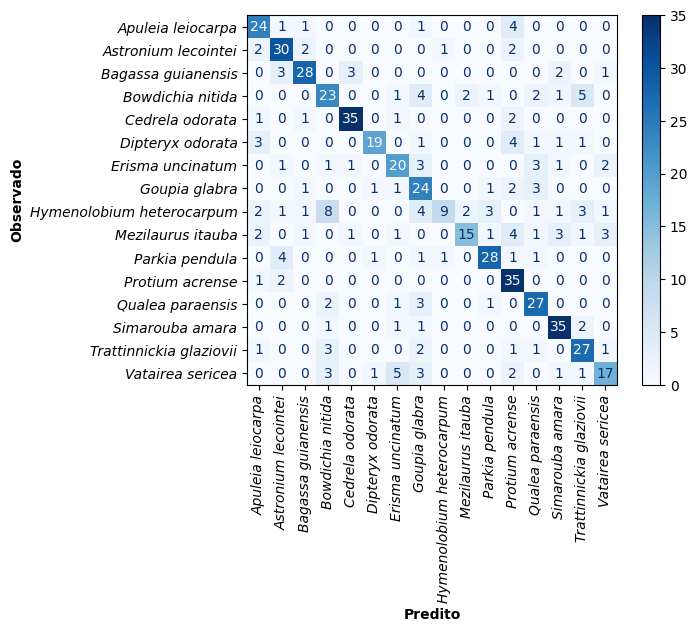

In [ ]:
# ================================================================================
# Matriz de Confusão - conjunto de teste (n = 566)
# ================================================================================
cm_rf = confusion_matrix(y_test, y_pred_rs_rf)
disp_cm_rf = ConfusionMatrixDisplay(confusion_matrix = cm_rf, display_labels= rs_rf.classes_)
disp_cm_rf.plot(cmap = 'Blues', xticks_rotation = 90)
disp_cm_rf.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_cm_rf.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_cm_rf.ax_.xaxis.set_tick_params(labelsize=10)
disp_cm_rf.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output/CNN/CM/cm_rf_resnet', dpi = 800, bbox_inches='tight')
plt.show()


In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================

print(classification_report(y_test, y_pred_rs_rf))

                           precision    recall  f1-score   support

        Apuleia leiocarpa       0.67      0.77      0.72        31
      Astronium lecointei       0.71      0.81      0.76        37
       Bagassa guianensis       0.80      0.76      0.78        37
         Bowdichia nitida       0.56      0.59      0.57        39
          Cedrela odorata       0.88      0.88      0.88        40
         Dipteryx odorata       0.86      0.63      0.73        30
         Erisma uncinatum       0.65      0.62      0.63        32
            Goupia glabra       0.51      0.73      0.60        33
Hymenolobium heterocarpum       0.82      0.25      0.38        36
        Mezilaurus itauba       0.79      0.45      0.58        33
           Parkia pendula       0.80      0.76      0.78        37
          Protium acrense       0.61      0.92      0.74        38
         Qualea paraensis       0.68      0.79      0.73        34
          Simarouba amara       0.78      0.88      0.82     

### Linear Discriminant Analysis - LDA

In [ ]:
# ================================================================================
# Definições do estimador LDA
# ================================================================================
# LinearDiscriminantAnalysis().get_params()

# Define o modelo
model_lda = LinearDiscriminantAnalysis(shrinkage='auto', n_components = None)

In [ ]:
# ================================================================================
# Ajuste de Hiperparâmetros (Hyperparameter tuning) - RandomizedSearchCV()
# ================================================================================

param_grid = {'solver': ['svd', 'lsqr', 'eigen'],
              'tol' : [0.0001, 0.0002, 0.0003]}

# Create the RandomizedSearchCV object
rs_lda = RandomizedSearchCV(estimator = model_lda, param_distributions = param_grid,
                            scoring = metrics, cv = cv, refit = 'accuracy',
                            verbose = 3, return_train_score = False, n_iter = 50)


rs_lda.fit(X_train, y_train, groups = sample_train)

pickle.dump(rs_lda, open(f'./Output/CNN/Models/rs_resnet_lda.pickle', "wb"))
joblib.dump(rs_lda, f'./Output/CNN/Models/rs_resnet_lda.joblib')

print(f'Os melhores parâmetros foram: {rs_lda.best_params_}')
print(f'A melhor acurácia foi de: {rs_lda.best_score_:.4f}')
print(f'O melhor modelo foi: {rs_lda.best_estimator_}')

In [ ]:
# ================================================================================
# Desempenho na Validação Cruzada (Stratified Group 5-fold cross-validation)
# ================================================================================
res1_rs_lda = pd.DataFrame(rs_lda.cv_results_).filter(regex = r'(params|test)').sort_values(by=["rank_test_accuracy"])

accf1_rs_lda = res1_rs_lda.iloc[0].filter(regex = r'(accuracy|f1)').filter(regex = 'split')
min_acc_rs_lda = accf1_rs_lda.filter(regex = 'accuracy').min()
max_acc_rs_lda = accf1_rs_lda.filter(regex = 'accuracy').max()
min_f1_rs_lda = accf1_rs_lda.filter(regex = 'f1').min()
max_f1_rs_lda = accf1_rs_lda.filter(regex = 'f1').max()

print(f'Acurácia min: {min_acc_rs_lda:.6f}')
print(f'Acurácia max: {max_acc_rs_lda:.6f}')
print(f'F1 min: {min_f1_rs_lda:.6f}')
print(f'F1 max: {max_f1_rs_lda:.6f}')

res2_rs_lda = res1_rs_lda.filter(regex = r'(mean|std|params)')
display(res2_rs_lda.iloc[0])

Acurácia min: 0.622222
Acurácia max: 0.672566
F1 min: 0.615445
F1 max: 0.672470


params                 {'tol': 0.0001, 'solver': 'lsqr'}
mean_test_accuracy                              0.638722
std_test_accuracy                                0.01787
mean_test_precision                             0.660164
std_test_precision                              0.018235
mean_test_recall                                0.638722
std_test_recall                                  0.01787
mean_test_f1_score                              0.635352
std_test_f1_score                               0.019751
Name: 3, dtype: object

In [ ]:
# ================================================================================
# Desempenho no conjunto de teste (n = 566)
# ================================================================================
y_pred_rs_lda = rs_lda.predict(X_test)
accuracy_rs_lda = accuracy_score(y_test, y_pred_rs_lda)
f1_rs_lda = f1_score(y_test, y_pred_rs_lda, average = 'weighted')
print(f"Best LDA Accuracy: {accuracy_rs_lda:.6f}")
print(f"Best LDA F1: {f1_rs_lda:.6f}")

Best LDA Accuracy: 0.777385
Best LDA F1: 0.778263


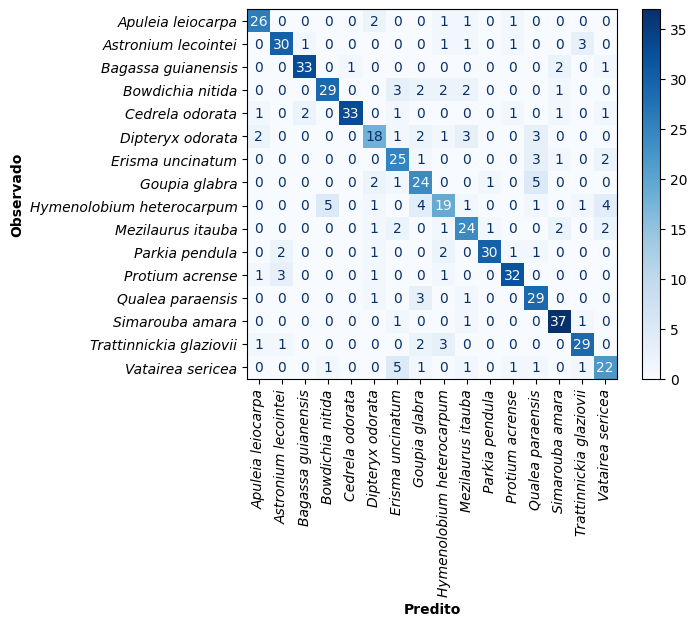

In [ ]:
# ================================================================================
# Matriz de Confusão - conjunto de teste (n = 566)
# ================================================================================
cm_lda = confusion_matrix(y_test, y_pred_rs_lda)
disp_cm_lda = ConfusionMatrixDisplay(confusion_matrix = cm_lda, display_labels= rs_lda.classes_)
disp_cm_lda.plot(cmap = 'Blues', xticks_rotation = 90)
disp_cm_lda.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_cm_lda.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_cm_lda.ax_.xaxis.set_tick_params(labelsize=10)
disp_cm_lda.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output/CNN/CM/cm_lda_resnet', dpi = 800, bbox_inches='tight')
plt.show()


In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================

print(classification_report(y_test, y_pred_rs_lda))

                           precision    recall  f1-score   support

        Apuleia leiocarpa       0.84      0.84      0.84        31
      Astronium lecointei       0.83      0.81      0.82        37
       Bagassa guianensis       0.92      0.89      0.90        37
         Bowdichia nitida       0.83      0.74      0.78        39
          Cedrela odorata       0.97      0.82      0.89        40
         Dipteryx odorata       0.67      0.60      0.63        30
         Erisma uncinatum       0.64      0.78      0.70        32
            Goupia glabra       0.62      0.73      0.67        33
Hymenolobium heterocarpum       0.61      0.53      0.57        36
        Mezilaurus itauba       0.69      0.73      0.71        33
           Parkia pendula       0.94      0.81      0.87        37
          Protium acrense       0.86      0.84      0.85        38
         Qualea paraensis       0.67      0.85      0.75        34
          Simarouba amara       0.84      0.93      0.88     

## **VGG16**

In [ ]:
#-----------------------------------------------------------------------------#
# Carregar o arquivo com as features
#-----------------------------------------------------------------------------#
with np.load('./Output/CNN/Features/features_vgg16_train.npz', mmap_mode= 'r', allow_pickle=True) as f:
    X_train = f['X_train']
    y_train = f['y_train']
    sample_train = f['sample_train']

with np.load('./Output/CNN/Features/features_vgg16_test.npz', mmap_mode= 'r', allow_pickle=True) as f:
    X_test = f['X_test']
    y_test = f['y_test']
    sample_test = f['sample_test']

In [ ]:
#------------------------------------------------------------------------------#
# Tamanho do conjunto de dados
#------------------------------------------------------------------------------#
print(f'X_train_vgg16: {X_train.shape}')
print(f'y_train_vgg16: {y_train.shape}')
print(f'X_test_vgg16: {X_test.shape}')
print(f'y_test_vgg16: {y_test.shape}')

X_train_vgg16: (2237, 512)
y_train_vgg16: (2237,)
X_test_vgg16: (566, 512)
y_test_vgg16: (566,)


### Artificial Neural Networks - ANN

In [ ]:
# ================================================================================
# Definições do estimador ANN
# ================================================================================
# MLPClassifier().get_params()

# Define o modelo
model_ann = MLPClassifier(random_state = 10, max_iter = 2000)

In [ ]:
# ================================================================================
# Ajuste de Hiperparâmetros (Hyperparameter tuning) - RandomizedSearchCV()
# ================================================================================

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,), (200,), (250,),
                          (300,), (350,), (400,), (450,),(500,)],
    'activation': ['relu', 'identity'],    # ['relu', 'tanh', 'logistic', 'identity']
    'solver': ['adam', 'lbfgs'],           # ['sgd', 'adam', 'lbfgs']
    'alpha': uniform(loc = 0.0001, scale = 0.09).rvs(size = 20, random_state = 10),
    'learning_rate': ['constant','adaptive', 'invscaling']}

# Create the RandomizedSearchCV object
rs_ann = RandomizedSearchCV(estimator = model_ann, param_distributions = param_grid,
                                 scoring = metrics, cv = cv, refit = 'accuracy',
                                 verbose = 3, return_train_score = False, n_iter = 20)


rs_ann.fit(X_train, y_train, groups = sample_train)

pickle.dump(rs_ann, open(f'./Output/CNN/Models/rs_vgg16_ann.pickle', "wb"))
joblib.dump(rs_ann, f'./Output/CNN/Models/rs_vgg16_ann.joblib')

print(f'Os melhores parâmetros foram: {rs_ann.best_params_}')
print(f'A melhor acurácia foi de: {rs_ann.best_score_:.4f}')
print(f'O melhor modelo foi: {rs_ann.best_estimator_}')

In [ ]:
# ================================================================================
# Desempenho na Validação Cruzada (Stratified Group 5-fold cross-validation)
# ================================================================================
res1_rs_ann = pd.DataFrame(rs_ann.cv_results_).filter(regex = r'(params|test)').sort_values(by=["rank_test_accuracy"])

accf1_rs_ann = res1_rs_ann.iloc[0].filter(regex = r'(accuracy|f1)').filter(regex = 'split')
min_acc_rs_ann = accf1_rs_ann.filter(regex = 'accuracy').min()
max_acc_rs_ann = accf1_rs_ann.filter(regex = 'accuracy').max()
min_f1_rs_ann = accf1_rs_ann.filter(regex = 'f1').min()
max_f1_rs_ann = accf1_rs_ann.filter(regex = 'f1').max()

print(f'Acurácia min: {min_acc_rs_ann:.6f}')
print(f'Acurácia max: {max_acc_rs_ann:.6f}')
print(f'F1 min: {min_f1_rs_ann:.6f}')
print(f'F1 max: {max_f1_rs_ann:.6f}')

res2_rs_ann = res1_rs_ann.filter(regex = r'(mean|std|params)')
display(res2_rs_ann.iloc[0])

Acurácia min: 0.577528
Acurácia max: 0.623894
F1 min: 0.578569
F1 max: 0.621541


params                 {'solver': 'adam', 'learning_rate': 'invscalin...
mean_test_accuracy                                               0.60388
std_test_accuracy                                                0.01566
mean_test_precision                                             0.609051
std_test_precision                                              0.015431
mean_test_recall                                                 0.60388
std_test_recall                                                  0.01566
mean_test_f1_score                                              0.599433
std_test_f1_score                                               0.014432
Name: 12, dtype: object

In [ ]:
# ================================================================================
# Desempenho no conjunto de teste (n = 566)
# ================================================================================
y_pred_rs_ann = rs_ann.predict(X_test)
accuracy_rs_ann = accuracy_score(y_test, y_pred_rs_ann)
f1_rs_ann = f1_score(y_test, y_pred_rs_ann, average = 'weighted')
print(f"Best ANN Accuracy: {accuracy_rs_ann:.6f}")
print(f"Best ANN F1: {f1_rs_ann:.6f}")

Best ANN Accuracy: 0.740283
Best ANN F1: 0.739764


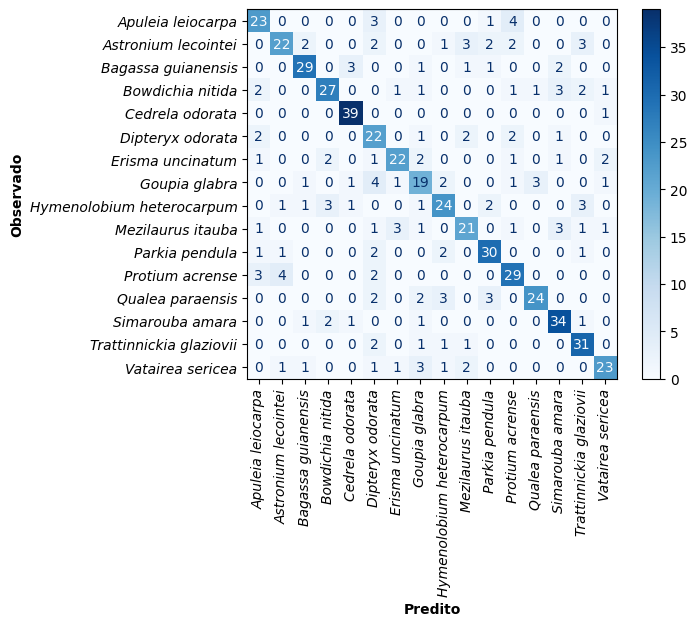

In [ ]:
# ================================================================================
# Matriz de Confusão - conjunto de teste (n = 566)
# ================================================================================
cm = confusion_matrix(y_test, y_pred_rs_ann)
disp_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels= rs_ann.classes_)
disp_cm.plot(cmap = 'Blues', xticks_rotation = 90)
disp_cm.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_cm.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_cm.ax_.xaxis.set_tick_params(labelsize=10)
disp_cm.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output/CNN/CM/cm_ann_vgg16', dpi = 800, bbox_inches='tight')
plt.show()


In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================

print(classification_report(y_test, y_pred_rs_ann))

                           precision    recall  f1-score   support

        Apuleia leiocarpa       0.70      0.74      0.72        31
      Astronium lecointei       0.76      0.59      0.67        37
       Bagassa guianensis       0.83      0.78      0.81        37
         Bowdichia nitida       0.79      0.69      0.74        39
          Cedrela odorata       0.87      0.97      0.92        40
         Dipteryx odorata       0.52      0.73      0.61        30
         Erisma uncinatum       0.79      0.69      0.73        32
            Goupia glabra       0.58      0.58      0.58        33
Hymenolobium heterocarpum       0.71      0.67      0.69        36
        Mezilaurus itauba       0.70      0.64      0.67        33
           Parkia pendula       0.77      0.81      0.79        37
          Protium acrense       0.71      0.76      0.73        38
         Qualea paraensis       0.86      0.71      0.77        34
          Simarouba amara       0.77      0.85      0.81     

### Suport Vector Classifier - SVC

In [ ]:
# ================================================================================
# Definições do estimador SVC
# ================================================================================
# SVC().get_params()

# Define o modelo
model_svc = SVC(decision_function_shape = 'ovo', probability = True)

In [ ]:
# ================================================================================
# Ajuste de Hiperparâmetros (Hyperparameter tuning) - RandomizedSearchCV()
# ================================================================================

param_grid = {
    'C': uniform(loc = 0.1, scale = 10).rvs(size = 20, random_state = 10),             # Uniform distribution between 0.1 and 10
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto'] + list(np.logspace(-9, 3, 13))
}

# Create the RandomizedSearchCV object
rs_svc = RandomizedSearchCV(estimator = model_svc, param_distributions = param_grid,
                                 scoring = metrics, cv = cv, refit = 'accuracy',
                                 verbose = 3, return_train_score = False, n_iter = 20)

rs_svc.fit(X_train, y_train, groups = sample_train)

pickle.dump(rs_svc, open(f'./Output/CNN/Models/rs_vgg16_svc.pickle', "wb"))
joblib.dump(rs_svc, f'./Output/CNN/Models/rs_vgg16_svc.joblib')

print(f'Os melhores parâmetros foram: {rs_svc.best_params_}')
print(f'A melhor acurácia foi de: {rs_svc.best_score_:.4f}')
print(f'O melhor modelo foi: {rs_svc.best_estimator_}')

In [ ]:
# ================================================================================
# Desempenho na Validação Cruzada (Stratified Group 5-fold cross-validation)
# ================================================================================
res1_rs_svc = pd.DataFrame(rs_svc.cv_results_).filter(regex = r'(params|test)').sort_values(by=["rank_test_accuracy"])

accf1_rs_svc = res1_rs_svc.iloc[0].filter(regex = r'(accuracy|f1)').filter(regex = 'split')
min_acc_rs_svc = accf1_rs_svc.filter(regex = 'accuracy').min()
max_acc_rs_svc = accf1_rs_svc.filter(regex = 'accuracy').max()
min_f1_rs_svc = accf1_rs_svc.filter(regex = 'f1').min()
max_f1_rs_svc = accf1_rs_svc.filter(regex = 'f1').max()

print(f'Acurácia min: {min_acc_rs_svc:.6f}')
print(f'Acurácia max: {max_acc_rs_svc:.6f}')
print(f'F1 min: {min_f1_rs_svc:.6f}')
print(f'F1 max: {max_f1_rs_svc:.6f}')

res2_rs_svc = res1_rs_svc.filter(regex = r'(mean|std|params)')
display(res2_rs_svc.iloc[0])

Acurácia min: 0.525843
Acurácia max: 0.592920
F1 min: 0.521967
F1 max: 0.588322


params                 {'kernel': 'rbf', 'gamma': 'scale', 'degree': ...
mean_test_accuracy                                              0.569446
std_test_accuracy                                               0.023224
mean_test_precision                                             0.576605
std_test_precision                                              0.021142
mean_test_recall                                                0.569446
std_test_recall                                                 0.023224
mean_test_f1_score                                              0.563491
std_test_f1_score                                               0.023609
Name: 6, dtype: object

In [ ]:
# ================================================================================
# Desempenho no conjunto de teste (n = 566)
# ================================================================================
y_pred_rs_svc = rs_svc.predict(X_test)
accuracy_rs_svc = accuracy_score(y_test, y_pred_rs_svc)
f1_rs_svc = f1_score(y_test, y_pred_rs_svc, average = 'weighted')
print(f"Best SVC Accuracy: {accuracy_rs_svc:.6f}")
print(f"Best SVC F1: {f1_rs_svc:.6f}")

Best SVC Accuracy: 0.736749
Best SVC F1: 0.737771


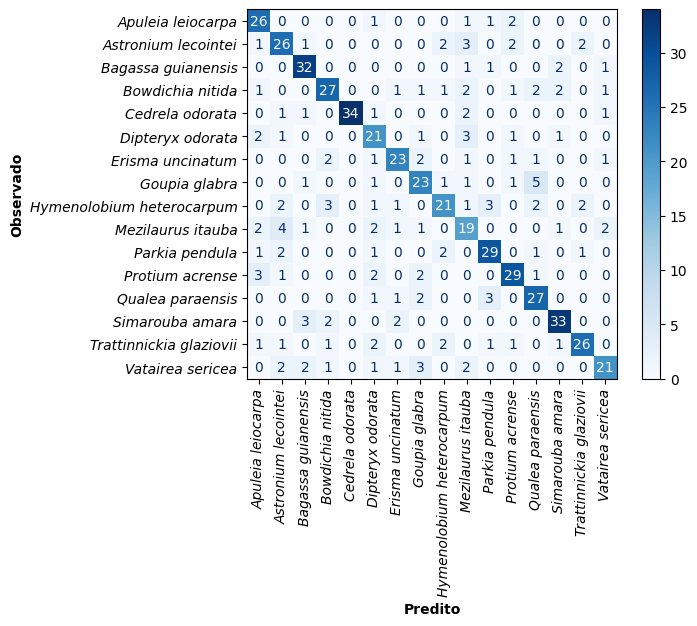

In [ ]:
# ================================================================================
# Matriz de Confusão - conjunto de teste (n = 566)
# ================================================================================
cm_svc = confusion_matrix(y_test, y_pred_rs_svc)
disp_cm_svc = ConfusionMatrixDisplay(confusion_matrix = cm_svc, display_labels= rs_svc.classes_)
disp_cm_svc.plot(cmap = 'Blues', xticks_rotation = 90)
disp_cm_svc.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_cm_svc.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_cm_svc.ax_.xaxis.set_tick_params(labelsize=10)
disp_cm_svc.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output/CNN/CM/cm_svc_vgg16', dpi = 800, bbox_inches='tight')
plt.show()


In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================

print(classification_report(y_test, y_pred_rs_svc))

                           precision    recall  f1-score   support

        Apuleia leiocarpa       0.70      0.84      0.76        31
      Astronium lecointei       0.65      0.70      0.68        37
       Bagassa guianensis       0.78      0.86      0.82        37
         Bowdichia nitida       0.75      0.69      0.72        39
          Cedrela odorata       1.00      0.85      0.92        40
         Dipteryx odorata       0.60      0.70      0.65        30
         Erisma uncinatum       0.77      0.72      0.74        32
            Goupia glabra       0.66      0.70      0.68        33
Hymenolobium heterocarpum       0.72      0.58      0.65        36
        Mezilaurus itauba       0.53      0.58      0.55        33
           Parkia pendula       0.76      0.78      0.77        37
          Protium acrense       0.76      0.76      0.76        38
         Qualea paraensis       0.69      0.79      0.74        34
          Simarouba amara       0.82      0.82      0.82     

### Random Forest - RF

In [ ]:
# ================================================================================
# Definições do estimador RF
# ================================================================================
#RandomForestClassifier().get_params()

# Define o modelo
model_rf = RandomForestClassifier(random_state = 10)

In [ ]:
# ================================================================================
# Ajuste de Hiperparâmetros (Hyperparameter tuning) - RandomizedSearchCV()
# ================================================================================

param_grid = {'n_estimators': np.arange(40, 320, 20),                        # Número de árvores (estimadores) na floresta aleatória
              'max_depth': list(np.arange(10, 100, step=10)) + [None],       # Número máximo de níveis na árvore
              'max_features': list(np.arange(30, 60, 5)) + ['sqrt', "log2"], # Número de variáveis a serem considerados em cada divisão
              'criterion': ['gini','entropy'],
              'min_samples_leaf': np.arange(10, 110, 10),                    # Número mínimo de amostras exigidos em cada nó folha (terminal)
              'min_samples_split': np.arange(2, 10, 2),                      # Número mínimo de amostras exigido para dividir um nó
              'bootstrap': [True, False]                                     # Método de seleção de amostras para treinamento de cada árvore
              }

# Create the RandomizedSearchCV object
rs_rf = RandomizedSearchCV(estimator = model_rf, param_distributions = param_grid,
                           scoring = metrics, cv = cv, refit = 'accuracy',
                           verbose = 3, return_train_score = False, n_iter = 50)

rs_rf.fit(X_train, y_train, groups = sample_train)

pickle.dump(rs_rf, open(f'./Output/CNN/Models/rs_vgg16_rf.pickle', "wb"))
joblib.dump(rs_rf, f'./Output/CNN/Models/rs_vgg16_rf.joblib')

print(f'Melhores hiperparâmetros: {rs_rf.best_params_}')
print(f'Melhor Acurácia: {rs_rf.best_score_}')
print(f'Melhor Estimador: {rs_rf.best_estimator_}')

In [ ]:
# ================================================================================
# Desempenho na Validação Cruzada (Stratified Group 5-fold cross-validation)
# ================================================================================
res1_rs_rf = pd.DataFrame(rs_rf.cv_results_).filter(regex = r'(params|test)').sort_values(by=["rank_test_accuracy"])

accf1_rs_rf = res1_rs_rf.iloc[0].filter(regex = r'(accuracy|f1)').filter(regex = 'split')
min_acc_rs_rf = accf1_rs_rf.filter(regex = 'accuracy').min()
max_acc_rs_rf = accf1_rs_rf.filter(regex = 'accuracy').max()
min_f1_rs_rf = accf1_rs_rf.filter(regex = 'f1').min()
max_f1_rs_rf = accf1_rs_rf.filter(regex = 'f1').max()

print(f'Acurácia min: {min_acc_rs_rf:.6f}')
print(f'Acurácia max: {max_acc_rs_rf:.6f}')
print(f'F1 min: {min_f1_rs_rf:.6f}')
print(f'F1 max: {max_f1_rs_rf:.6f}')

res2_rs_rf = res1_rs_rf.filter(regex = r'(mean|std|params)')
display(res2_rs_rf.iloc[0])

Acurácia min: 0.495556
Acurácia max: 0.572707
F1 min: 0.465945
F1 max: 0.544377


params                 {'n_estimators': 260, 'min_samples_split': 2, ...
mean_test_accuracy                                               0.53465
std_test_accuracy                                               0.025567
mean_test_precision                                             0.531944
std_test_precision                                               0.02128
mean_test_recall                                                 0.53465
std_test_recall                                                 0.025567
mean_test_f1_score                                              0.507051
std_test_f1_score                                               0.025339
Name: 44, dtype: object

In [ ]:
# ================================================================================
# Desempenho no conjunto de teste (n = 566)
# ================================================================================
y_pred_rs_rf = rs_rf.predict(X_test)
accuracy_rs_rf = accuracy_score(y_test, y_pred_rs_rf)
f1_rs_rf = f1_score(y_test, y_pred_rs_rf, average = 'weighted')
print(f"Best RF Accuracy: {accuracy_rs_rf:.6f}")
print(f"Best RF F1: {f1_rs_rf:.6f}")

Best RF Accuracy: 0.591873
Best RF F1: 0.575317


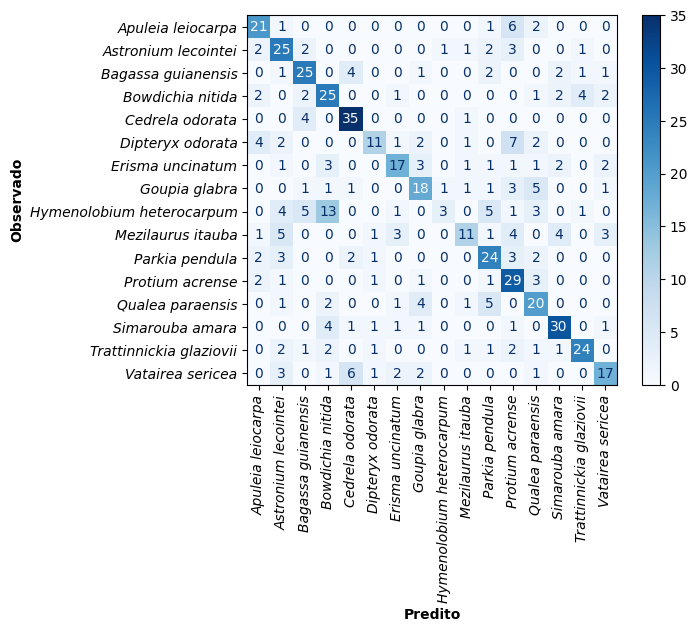

In [ ]:
# ================================================================================
# Matriz de Confusão - conjunto de teste (n = 566)
# ================================================================================
cm_rf = confusion_matrix(y_test, y_pred_rs_rf)
disp_cm_rf = ConfusionMatrixDisplay(confusion_matrix = cm_rf, display_labels= rs_rf.classes_)
disp_cm_rf.plot(cmap = 'Blues', xticks_rotation = 90)
disp_cm_rf.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_cm_rf.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_cm_rf.ax_.xaxis.set_tick_params(labelsize=10)
disp_cm_rf.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output/CNN/CM/cm_rf_vgg16', dpi = 800, bbox_inches='tight')
plt.show()


In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================

print(classification_report(y_test, y_pred_rs_rf))

                           precision    recall  f1-score   support

        Apuleia leiocarpa       0.62      0.68      0.65        31
      Astronium lecointei       0.51      0.68      0.58        37
       Bagassa guianensis       0.62      0.68      0.65        37
         Bowdichia nitida       0.49      0.64      0.56        39
          Cedrela odorata       0.71      0.88      0.79        40
         Dipteryx odorata       0.65      0.37      0.47        30
         Erisma uncinatum       0.63      0.53      0.58        32
            Goupia glabra       0.56      0.55      0.55        33
Hymenolobium heterocarpum       0.60      0.08      0.15        36
        Mezilaurus itauba       0.61      0.33      0.43        33
           Parkia pendula       0.55      0.65      0.59        37
          Protium acrense       0.48      0.76      0.59        38
         Qualea paraensis       0.49      0.59      0.53        34
          Simarouba amara       0.73      0.75      0.74     

### Linear Discriminant Analysis - LDA

In [ ]:
# ================================================================================
# Definições do estimador LDA
# ================================================================================
# LinearDiscriminantAnalysis().get_params()

# Define o modelo
model_lda = LinearDiscriminantAnalysis(shrinkage='auto', n_components = None)

In [ ]:
# ================================================================================
# Ajuste de Hiperparâmetros (Hyperparameter tuning) - RandomizedSearchCV()
# ================================================================================

param_grid = {'solver': ['svd', 'lsqr', 'eigen'],
              'tol' : [0.0001, 0.0002, 0.0003]}

# Create the RandomizedSearchCV object
rs_lda = RandomizedSearchCV(estimator = model_lda, param_distributions = param_grid,
                            scoring = metrics, cv = cv, refit = 'accuracy',
                            verbose = 3, return_train_score = False, n_iter = 50)


rs_lda.fit(X_train, y_train, groups = sample_train)

pickle.dump(rs_lda, open(f'./Output/CNN/Models/rs_vgg16_lda.pickle', "wb"))
joblib.dump(rs_lda, f'./Output/CNN/Models/rs_vgg16_lda.joblib')

print(f'Os melhores parâmetros foram: {rs_lda.best_params_}')
print(f'A melhor acurácia foi de: {rs_lda.best_score_:.4f}')
print(f'O melhor modelo foi: {rs_lda.best_estimator_}')

In [ ]:
# ================================================================================
# Desempenho na Validação Cruzada (Stratified Group 5-fold cross-validation)
# ================================================================================
res1_rs_lda = pd.DataFrame(rs_lda.cv_results_).filter(regex = r'(params|test)').sort_values(by=["rank_test_accuracy"])

accf1_rs_lda = res1_rs_lda.iloc[0].filter(regex = r'(accuracy|f1)').filter(regex = 'split')
min_acc_rs_lda = accf1_rs_lda.filter(regex = 'accuracy').min()
max_acc_rs_lda = accf1_rs_lda.filter(regex = 'accuracy').max()
min_f1_rs_lda = accf1_rs_lda.filter(regex = 'f1').min()
max_f1_rs_lda = accf1_rs_lda.filter(regex = 'f1').max()

print(f'Acurácia min: {min_acc_rs_lda:.6f}')
print(f'Acurácia max: {max_acc_rs_lda:.6f}')
print(f'F1 min: {min_f1_rs_lda:.6f}')
print(f'F1 max: {max_f1_rs_lda:.6f}')

res2_rs_lda = res1_rs_lda.filter(regex = r'(mean|std|params)')
display(res2_rs_lda.iloc[0])

Acurácia min: 0.516854
Acurácia max: 0.548673
F1 min: 0.516838
F1 max: 0.549249


params                 {'tol': 0.0001, 'solver': 'lsqr'}
mean_test_accuracy                              0.530122
std_test_accuracy                               0.014111
mean_test_precision                             0.569867
std_test_precision                              0.021461
mean_test_recall                                0.530122
std_test_recall                                 0.014111
mean_test_f1_score                              0.530818
std_test_f1_score                               0.013044
Name: 3, dtype: object

In [ ]:
# ================================================================================
# Desempenho no conjunto de teste (n = 566)
# ================================================================================
y_pred_rs_lda = rs_lda.predict(X_test)
accuracy_rs_lda = accuracy_score(y_test, y_pred_rs_lda)
f1_rs_lda = f1_score(y_test, y_pred_rs_lda, average = 'weighted')
print(f"Best LDA Accuracy: {accuracy_rs_lda:.6f}")
print(f"Best LDA F1: {f1_rs_lda:.6f}")

Best LDA Accuracy: 0.604240
Best LDA F1: 0.607756


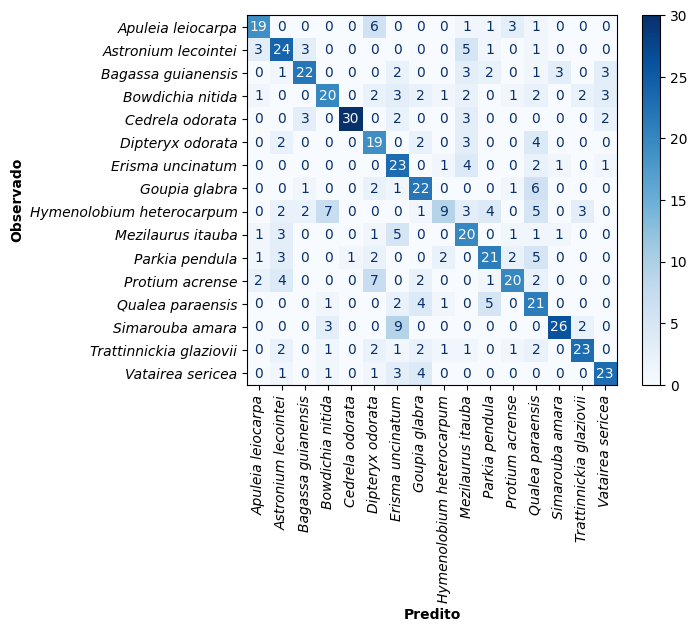

In [ ]:
# ================================================================================
# Matriz de Confusão - conjunto de teste (n = 566)
# ================================================================================
cm_lda = confusion_matrix(y_test, y_pred_rs_lda)
disp_cm_lda = ConfusionMatrixDisplay(confusion_matrix = cm_lda, display_labels= rs_lda.classes_)
disp_cm_lda.plot(cmap = 'Blues', xticks_rotation = 90)
disp_cm_lda.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_cm_lda.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_cm_lda.ax_.xaxis.set_tick_params(labelsize=10)
disp_cm_lda.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output/CNN/CM/cm_lda_vgg16', dpi = 800, bbox_inches='tight')
plt.show()


In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================

print(classification_report(y_test, y_pred_rs_lda))

                           precision    recall  f1-score   support

        Apuleia leiocarpa       0.70      0.61      0.66        31
      Astronium lecointei       0.57      0.65      0.61        37
       Bagassa guianensis       0.71      0.59      0.65        37
         Bowdichia nitida       0.61      0.51      0.56        39
          Cedrela odorata       0.97      0.75      0.85        40
         Dipteryx odorata       0.45      0.63      0.53        30
         Erisma uncinatum       0.45      0.72      0.55        32
            Goupia glabra       0.56      0.67      0.61        33
Hymenolobium heterocarpum       0.60      0.25      0.35        36
        Mezilaurus itauba       0.44      0.61      0.51        33
           Parkia pendula       0.60      0.57      0.58        37
          Protium acrense       0.69      0.53      0.60        38
         Qualea paraensis       0.40      0.62      0.48        34
          Simarouba amara       0.84      0.65      0.73     

## **Inception_V3**

In [ ]:
#-----------------------------------------------------------------------------#
# Carregar o arquivo com as features
#-----------------------------------------------------------------------------#
with np.load('./Output/CNN/Features/features_inception_train.npz', mmap_mode= 'r', allow_pickle=True) as f:
    X_train = f['X_train']
    y_train = f['y_train']
    sample_train = f['sample_train']

with np.load('./Output/CNN/Features/features_inception_test.npz', mmap_mode= 'r', allow_pickle=True) as f:
    X_test = f['X_test']
    y_test = f['y_test']
    sample_test = f['sample_test']

In [ ]:
#------------------------------------------------------------------------------#
# Tamanho do conjunto de dados
#------------------------------------------------------------------------------#
print(f'X_train_inception: {X_train.shape}')
print(f'y_train_inception: {y_train.shape}')
print(f'X_test_inception: {X_test.shape}')
print(f'y_test_inception: {y_test.shape}')

X_train_inception: (2237, 2048)
y_train_inception: (2237,)
X_test_inception: (566, 2048)
y_test_inception: (566,)


### Artificial Neural Networks - ANN

In [ ]:
# ================================================================================
# Definições do estimador ANN
# ================================================================================
# MLPClassifier().get_params()

# Define o modelo
model_ann = MLPClassifier(random_state = 10, max_iter = 2000)

In [ ]:
# ================================================================================
# Ajuste de Hiperparâmetros (Hyperparameter tuning) - RandomizedSearchCV()
# ================================================================================

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,), (200,), (250,),
                          (300,), (350,), (400,), (450,),(500,)],
    'activation': ['relu', 'identity'],    # ['relu', 'tanh', 'logistic', 'identity']
    'solver': ['adam', 'lbfgs'],           # ['sgd', 'adam', 'lbfgs']
    'alpha': uniform(loc = 0.0001, scale = 0.09).rvs(size = 20, random_state = 10),
    'learning_rate': ['constant','adaptive', 'invscaling']}

# Create the RandomizedSearchCV object
rs_ann = RandomizedSearchCV(estimator = model_ann, param_distributions = param_grid,
                                 scoring = metrics, cv = cv, refit = 'accuracy',
                                 verbose = 3, return_train_score = False, n_iter = 20)

rs_ann.fit(X_train, y_train, groups = sample_train)

pickle.dump(rs_ann, open(f'./Output/CNN/Models/rs_inception_ann.pickle', "wb"))
joblib.dump(rs_ann, f'./Output/CNN/Models/rs_inception_ann.joblib')

print(f'Os melhores parâmetros foram: {rs_ann.best_params_}')
print(f'A melhor acurácia foi de: {rs_ann.best_score_:.4f}')
print(f'O melhor modelo foi: {rs_ann.best_estimator_}')

In [ ]:
# ================================================================================
# Desempenho na Validação Cruzada (Stratified Group 5-fold cross-validation)
# ================================================================================
res1_rs_ann = pd.DataFrame(rs_ann.cv_results_).filter(regex = r'(params|test)').sort_values(by=["rank_test_accuracy"])

accf1_rs_ann = res1_rs_ann.iloc[0].filter(regex = r'(accuracy|f1)').filter(regex = 'split')
min_acc_rs_ann = accf1_rs_ann.filter(regex = 'accuracy').min()
max_acc_rs_ann = accf1_rs_ann.filter(regex = 'accuracy').max()
min_f1_rs_ann = accf1_rs_ann.filter(regex = 'f1').min()
max_f1_rs_ann = accf1_rs_ann.filter(regex = 'f1').max()

print(f'Acurácia min: {min_acc_rs_ann:.6f}')
print(f'Acurácia max: {max_acc_rs_ann:.6f}')
print(f'F1 min: {min_f1_rs_ann:.6f}')
print(f'F1 max: {max_f1_rs_ann:.6f}')

res2_rs_ann = res1_rs_ann.filter(regex = r'(mean|std|params)')
display(res2_rs_ann.iloc[0])

Acurácia min: 0.504425
Acurácia max: 0.572707
F1 min: 0.493756
F1 max: 0.565176


params                 {'solver': 'adam', 'learning_rate': 'invscalin...
mean_test_accuracy                                               0.52575
std_test_accuracy                                               0.024278
mean_test_precision                                             0.531962
std_test_precision                                              0.023704
mean_test_recall                                                 0.52575
std_test_recall                                                 0.024278
mean_test_f1_score                                              0.518271
std_test_f1_score                                               0.024691
Name: 3, dtype: object

In [ ]:
# ================================================================================
# Desempenho no conjunto de teste (n = 566)
# ================================================================================
y_pred_rs_ann = rs_ann.predict(X_test)
accuracy_rs_ann = accuracy_score(y_test, y_pred_rs_ann)
f1_rs_ann = f1_score(y_test, y_pred_rs_ann, average = 'weighted')
print(f"Best ANN Accuracy: {accuracy_rs_ann:.6f}")
print(f"Best ANN F1: {f1_rs_ann:.6f}")

Best ANN Accuracy: 0.632509
Best ANN F1: 0.634409


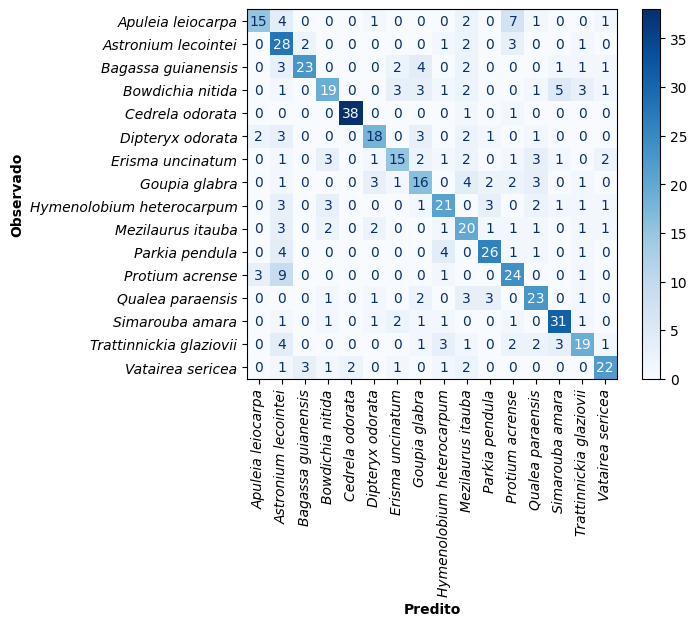

In [ ]:
# ================================================================================
# Matriz de Confusão - conjunto de teste (n = 566)
# ================================================================================
cm = confusion_matrix(y_test, y_pred_rs_ann)
disp_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels= rs_ann.classes_)
disp_cm.plot(cmap = 'Blues', xticks_rotation = 90)
disp_cm.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_cm.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_cm.ax_.xaxis.set_tick_params(labelsize=10)
disp_cm.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output/CNN/CM/cm_ann_inception', dpi = 800, bbox_inches='tight')
plt.show()


In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================

print(classification_report(y_test, y_pred_rs_ann))

                           precision    recall  f1-score   support

        Apuleia leiocarpa       0.75      0.48      0.59        31
      Astronium lecointei       0.42      0.76      0.54        37
       Bagassa guianensis       0.82      0.62      0.71        37
         Bowdichia nitida       0.63      0.49      0.55        39
          Cedrela odorata       0.95      0.95      0.95        40
         Dipteryx odorata       0.67      0.60      0.63        30
         Erisma uncinatum       0.62      0.47      0.54        32
            Goupia glabra       0.48      0.48      0.48        33
Hymenolobium heterocarpum       0.60      0.58      0.59        36
        Mezilaurus itauba       0.47      0.61      0.53        33
           Parkia pendula       0.72      0.70      0.71        37
          Protium acrense       0.56      0.63      0.59        38
         Qualea paraensis       0.61      0.68      0.64        34
          Simarouba amara       0.74      0.78      0.76     

### Suport Vector Classifier - SVC

In [ ]:
# ================================================================================
# Definições do estimador SVC
# ================================================================================
# SVC().get_params()

# Define o modelo
model_svc = SVC(decision_function_shape = 'ovo', probability = True)

In [ ]:
# ================================================================================
# Ajuste de Hiperparâmetros (Hyperparameter tuning) - RandomizedSearchCV()
# ================================================================================

param_grid = {
    'C': uniform(loc = 0.1, scale = 10).rvs(size = 20, random_state = 10),             # Uniform distribution between 0.1 and 10
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto'] + list(np.logspace(-9, 3, 13))
}

# Create the RandomizedSearchCV object
rs_svc = RandomizedSearchCV(estimator = model_svc, param_distributions = param_grid,
                                 scoring = metrics, cv = cv, refit = 'accuracy',
                                 verbose = 3, return_train_score = False, n_iter = 20)

rs_svc.fit(X_train, y_train, groups = sample_train)

pickle.dump(rs_svc, open(f'./Output/CNN/Models/rs_inception_svc.pickle', "wb"))
joblib.dump(rs_svc, f'./Output/CNN/Models/rs_inception_svc.joblib')

print(f'Os melhores parâmetros foram: {rs_svc.best_params_}')
print(f'A melhor acurácia foi de: {rs_svc.best_score_:.4f}')
print(f'O melhor modelo foi: {rs_svc.best_estimator_}')

In [ ]:
# ================================================================================
# Desempenho na Validação Cruzada (Stratified Group 5-fold cross-validation)
# ================================================================================
res1_rs_svc = pd.DataFrame(rs_svc.cv_results_).filter(regex = r'(params|test)').sort_values(by=["rank_test_accuracy"])

accf1_rs_svc = res1_rs_svc.iloc[0].filter(regex = r'(accuracy|f1)').filter(regex = 'split')
min_acc_rs_svc = accf1_rs_svc.filter(regex = 'accuracy').min()
max_acc_rs_svc = accf1_rs_svc.filter(regex = 'accuracy').max()
min_f1_rs_svc = accf1_rs_svc.filter(regex = 'f1').min()
max_f1_rs_svc = accf1_rs_svc.filter(regex = 'f1').max()

print(f'Acurácia min: {min_acc_rs_svc:.6f}')
print(f'Acurácia max: {max_acc_rs_svc:.6f}')
print(f'F1 min: {min_f1_rs_svc:.6f}')
print(f'F1 max: {max_f1_rs_svc:.6f}')

res2_rs_svc = res1_rs_svc.filter(regex = r'(mean|std|params)')
display(res2_rs_svc.iloc[0])

Acurácia min: 0.504425
Acurácia max: 0.539150
F1 min: 0.501323
F1 max: 0.528835


params                 {'kernel': 'poly', 'gamma': 0.1, 'degree': 2, ...
mean_test_accuracy                                              0.519431
std_test_accuracy                                                0.01479
mean_test_precision                                             0.525764
std_test_precision                                              0.015283
mean_test_recall                                                0.519431
std_test_recall                                                  0.01479
mean_test_f1_score                                              0.513622
std_test_f1_score                                               0.012443
Name: 14, dtype: object

In [ ]:
# ================================================================================
# Desempenho no conjunto de teste (n = 566)
# ================================================================================
y_pred_rs_svc = rs_svc.predict(X_test)
accuracy_rs_svc = accuracy_score(y_test, y_pred_rs_svc)
f1_rs_svc = f1_score(y_test, y_pred_rs_svc, average = 'weighted')
print(f"Best SVC Accuracy: {accuracy_rs_svc:.6f}")
print(f"Best SVC F1: {f1_rs_svc:.6f}")

Best SVC Accuracy: 0.634276
Best SVC F1: 0.632465


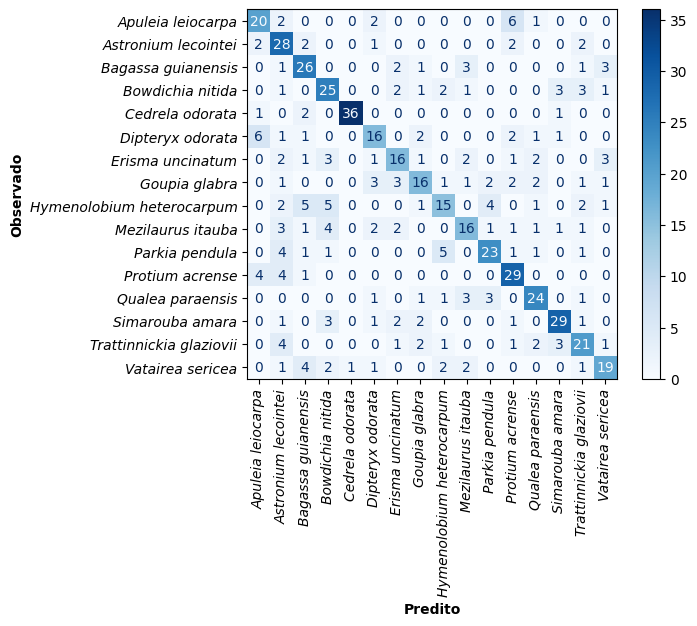

In [ ]:
# ================================================================================
# Matriz de Confusão - conjunto de teste (n = 566)
# ================================================================================
cm_svc = confusion_matrix(y_test, y_pred_rs_svc)
disp_cm_svc = ConfusionMatrixDisplay(confusion_matrix = cm_svc, display_labels= rs_svc.classes_)
disp_cm_svc.plot(cmap = 'Blues', xticks_rotation = 90)
disp_cm_svc.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_cm_svc.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_cm_svc.ax_.xaxis.set_tick_params(labelsize=10)
disp_cm_svc.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output/CNN/CM/cm_svc_inception', dpi = 800, bbox_inches='tight')
plt.show()


In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================

print(classification_report(y_test, y_pred_rs_svc))

                           precision    recall  f1-score   support

        Apuleia leiocarpa       0.61      0.65      0.62        31
      Astronium lecointei       0.51      0.76      0.61        37
       Bagassa guianensis       0.59      0.70      0.64        37
         Bowdichia nitida       0.58      0.64      0.61        39
          Cedrela odorata       0.97      0.90      0.94        40
         Dipteryx odorata       0.57      0.53      0.55        30
         Erisma uncinatum       0.57      0.50      0.53        32
            Goupia glabra       0.59      0.48      0.53        33
Hymenolobium heterocarpum       0.56      0.42      0.48        36
        Mezilaurus itauba       0.57      0.48      0.52        33
           Parkia pendula       0.70      0.62      0.66        37
          Protium acrense       0.63      0.76      0.69        38
         Qualea paraensis       0.69      0.71      0.70        34
          Simarouba amara       0.76      0.72      0.74     

### Random Forest - RF

In [ ]:
# ================================================================================
# Definições do estimador RF
# ================================================================================
#RandomForestClassifier().get_params()

# Define o modelo
model_rf = RandomForestClassifier(random_state = 10)

In [ ]:
# ================================================================================
# Ajuste de Hiperparâmetros (Hyperparameter tuning) - RandomizedSearchCV()
# ================================================================================

param_grid = {'n_estimators': np.arange(40, 320, 20),                        # Número de árvores (estimadores) na floresta aleatória
              'max_depth': list(np.arange(10, 100, step=10)) + [None],       # Número máximo de níveis na árvore
              'max_features': list(np.arange(30, 60, 5)) + ['sqrt', "log2"], # Número de variáveis a serem considerados em cada divisão
              'criterion': ['gini','entropy'],
              'min_samples_leaf': np.arange(10, 110, 10),                    # Número mínimo de amostras exigidos em cada nó folha (terminal)
              'min_samples_split': np.arange(2, 10, 2),                      # Número mínimo de amostras exigido para dividir um nó
              'bootstrap': [True, False]                                     # Método de seleção de amostras para treinamento de cada árvore
              }

# Create the RandomizedSearchCV object
rs_rf = RandomizedSearchCV(estimator = model_rf, param_distributions = param_grid,
                           scoring = metrics, cv = cv, refit = 'accuracy',
                           verbose = 3, return_train_score = False, n_iter = 50)


rs_rf.fit(X_train, y_train, groups = sample_train)

pickle.dump(rs_rf, open(f'./Output/CNN/Models/rs_inception_rf.pickle', "wb"))
joblib.dump(rs_rf, f'./Output/CNN/Models/rs_inception_rf.joblib')

print(f'Melhores hiperparâmetros: {rs_rf.best_params_}')
print(f'Melhor Acurácia: {rs_rf.best_score_}')
print(f'Melhor Estimador: {rs_rf.best_estimator_}')

In [ ]:
# ================================================================================
# Desempenho na Validação Cruzada (Stratified Group 5-fold cross-validation)
# ================================================================================
res1_rs_rf = pd.DataFrame(rs_rf.cv_results_).filter(regex = r'(params|test)').sort_values(by=["rank_test_accuracy"])

accf1_rs_rf = res1_rs_rf.iloc[0].filter(regex = r'(accuracy|f1)').filter(regex = 'split')
min_acc_rs_rf = accf1_rs_rf.filter(regex = 'accuracy').min()
max_acc_rs_rf = accf1_rs_rf.filter(regex = 'accuracy').max()
min_f1_rs_rf = accf1_rs_rf.filter(regex = 'f1').min()
max_f1_rs_rf = accf1_rs_rf.filter(regex = 'f1').max()

print(f'Acurácia min: {min_acc_rs_rf:.6f}')
print(f'Acurácia max: {max_acc_rs_rf:.6f}')
print(f'F1 min: {min_f1_rs_rf:.6f}')
print(f'F1 max: {max_f1_rs_rf:.6f}')

res2_rs_rf = res1_rs_rf.filter(regex = r'(mean|std|params)')
display(res2_rs_rf.iloc[0])

Acurácia min: 0.433628
Acurácia max: 0.489842
F1 min: 0.409884
F1 max: 0.466262


params                 {'n_estimators': 280, 'min_samples_split': 8, ...
mean_test_accuracy                                              0.459216
std_test_accuracy                                               0.022763
mean_test_precision                                              0.46058
std_test_precision                                              0.016053
mean_test_recall                                                0.459216
std_test_recall                                                 0.022763
mean_test_f1_score                                              0.433787
std_test_f1_score                                               0.023886
Name: 9, dtype: object

In [ ]:
# ================================================================================
# Desempenho no conjunto de teste (n = 566)
# ================================================================================
y_pred_rs_rf = rs_rf.predict(X_test)
accuracy_rs_rf = accuracy_score(y_test, y_pred_rs_rf)
f1_rs_rf = f1_score(y_test, y_pred_rs_rf, average = 'weighted')
print(f"Best RF Accuracy: {accuracy_rs_rf:.6f}")
print(f"Best RF F1: {f1_rs_rf:.6f}")

Best RF Accuracy: 0.505300
Best RF F1: 0.487511


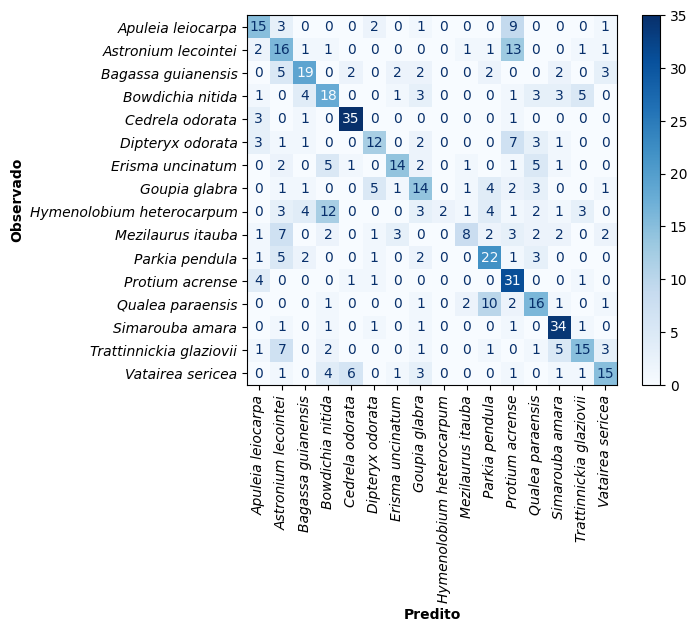

In [ ]:
# ================================================================================
# Matriz de Confusão - conjunto de teste (n = 566)
# ================================================================================
cm_rf = confusion_matrix(y_test, y_pred_rs_rf)
disp_cm_rf = ConfusionMatrixDisplay(confusion_matrix = cm_rf, display_labels= rs_rf.classes_)
disp_cm_rf.plot(cmap = 'Blues', xticks_rotation = 90)
disp_cm_rf.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_cm_rf.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_cm_rf.ax_.xaxis.set_tick_params(labelsize=10)
disp_cm_rf.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output/CNN/CM/cm_rf_inception', dpi = 800, bbox_inches='tight')
plt.show()


In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================

print(classification_report(y_test, y_pred_rs_rf))

                           precision    recall  f1-score   support

        Apuleia leiocarpa       0.48      0.48      0.48        31
      Astronium lecointei       0.31      0.43      0.36        37
       Bagassa guianensis       0.58      0.51      0.54        37
         Bowdichia nitida       0.39      0.46      0.42        39
          Cedrela odorata       0.78      0.88      0.82        40
         Dipteryx odorata       0.52      0.40      0.45        30
         Erisma uncinatum       0.64      0.44      0.52        32
            Goupia glabra       0.40      0.42      0.41        33
Hymenolobium heterocarpum       1.00      0.06      0.11        36
        Mezilaurus itauba       0.57      0.24      0.34        33
           Parkia pendula       0.48      0.59      0.53        37
          Protium acrense       0.42      0.82      0.55        38
         Qualea paraensis       0.42      0.47      0.44        34
          Simarouba amara       0.67      0.85      0.75     

### Linear Discriminant Analysis - LDA

In [ ]:
# ================================================================================
# Definições do estimador LDA
# ================================================================================
# LinearDiscriminantAnalysis().get_params()

# Define o modelo
model_lda = LinearDiscriminantAnalysis(shrinkage='auto', n_components = None)

In [ ]:
# ================================================================================
# Ajuste de Hiperparâmetros (Hyperparameter tuning) - RandomizedSearchCV()
# ================================================================================

param_grid = {'solver': ['svd', 'lsqr', 'eigen'],
              'tol' : [0.0001, 0.0002, 0.0003]}

# Create the RandomizedSearchCV object
rs_lda = RandomizedSearchCV(estimator = model_lda, param_distributions = param_grid,
                            scoring = metrics, cv = cv, refit = 'accuracy',
                            verbose = 3, return_train_score = False, n_iter = 50)


rs_lda.fit(X_train, y_train, groups = sample_train)

pickle.dump(rs_lda, open(f'./Output/CNN/Models/rs_inception_lda.pickle', "wb"))
joblib.dump(rs_lda, f'./Output/CNN/Models/rs_inception_lda.joblib')

print(f'Os melhores parâmetros foram: {rs_lda.best_params_}')
print(f'A melhor acurácia foi de: {rs_lda.best_score_:.4f}')
print(f'O melhor modelo foi: {rs_lda.best_estimator_}')

In [ ]:
# ================================================================================
# Desempenho na Validação Cruzada (Stratified Group 5-fold cross-validation)
# ================================================================================
res1_rs_lda = pd.DataFrame(rs_lda.cv_results_).filter(regex = r'(params|test)').sort_values(by=["rank_test_accuracy"])

accf1_rs_lda = res1_rs_lda.iloc[0].filter(regex = r'(accuracy|f1)').filter(regex = 'split')
min_acc_rs_lda = accf1_rs_lda.filter(regex = 'accuracy').min()
max_acc_rs_lda = accf1_rs_lda.filter(regex = 'accuracy').max()
min_f1_rs_lda = accf1_rs_lda.filter(regex = 'f1').min()
max_f1_rs_lda = accf1_rs_lda.filter(regex = 'f1').max()

print(f'Acurácia min: {min_acc_rs_lda:.6f}')
print(f'Acurácia max: {max_acc_rs_lda:.6f}')
print(f'F1 min: {min_f1_rs_lda:.6f}')
print(f'F1 max: {max_f1_rs_lda:.6f}')

res2_rs_lda = res1_rs_lda.filter(regex = r'(mean|std|params)')
display(res2_rs_lda.iloc[0])

Acurácia min: 0.488938
Acurácia max: 0.572707
F1 min: 0.495818
F1 max: 0.565389


params                 {'tol': 0.0001, 'solver': 'lsqr'}
mean_test_accuracy                              0.522208
std_test_accuracy                               0.029981
mean_test_precision                             0.547448
std_test_precision                              0.022135
mean_test_recall                                0.522208
std_test_recall                                 0.029981
mean_test_f1_score                              0.522772
std_test_f1_score                               0.025388
Name: 3, dtype: object

In [ ]:
# ================================================================================
# Desempenho no conjunto de teste (n = 566)
# ================================================================================
y_pred_rs_lda = rs_lda.predict(X_test)
accuracy_rs_lda = accuracy_score(y_test, y_pred_rs_lda)
f1_rs_lda = f1_score(y_test, y_pred_rs_lda, average = 'weighted')
print(f"Best LDA Accuracy: {accuracy_rs_lda:.6f}")
print(f"Best LDA F1: {f1_rs_lda:.6f}")

Best LDA Accuracy: 0.637809
Best LDA F1: 0.641377


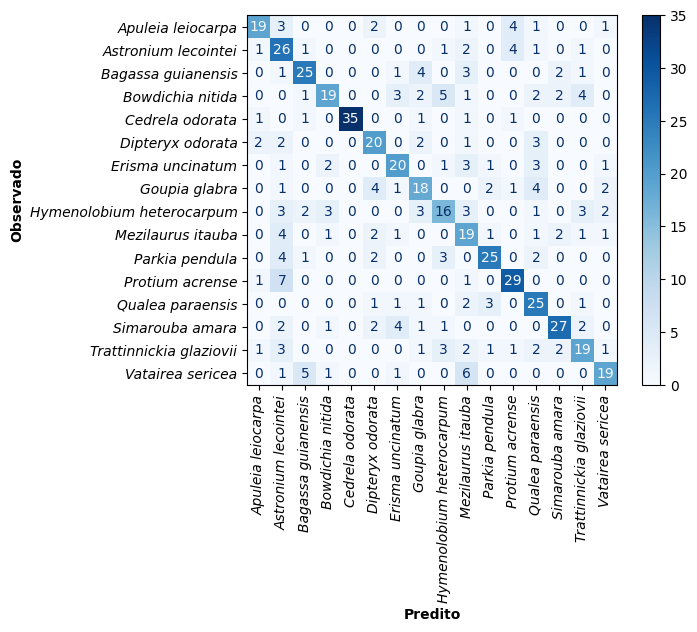

In [ ]:
# ================================================================================
# Matriz de Confusão - conjunto de teste (n = 566)
# ================================================================================
cm_lda = confusion_matrix(y_test, y_pred_rs_lda)
disp_cm_lda = ConfusionMatrixDisplay(confusion_matrix = cm_lda, display_labels= rs_lda.classes_)
disp_cm_lda.plot(cmap = 'Blues', xticks_rotation = 90)
disp_cm_lda.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_cm_lda.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_cm_lda.ax_.xaxis.set_tick_params(labelsize=10)
disp_cm_lda.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output/CNN/CM/cm_lda_inception', dpi = 800, bbox_inches='tight')
plt.show()


In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================

print(classification_report(y_test, y_pred_rs_lda))

                           precision    recall  f1-score   support

        Apuleia leiocarpa       0.76      0.61      0.68        31
      Astronium lecointei       0.45      0.70      0.55        37
       Bagassa guianensis       0.69      0.68      0.68        37
         Bowdichia nitida       0.70      0.49      0.58        39
          Cedrela odorata       1.00      0.88      0.93        40
         Dipteryx odorata       0.61      0.67      0.63        30
         Erisma uncinatum       0.62      0.62      0.62        32
            Goupia glabra       0.55      0.55      0.55        33
Hymenolobium heterocarpum       0.53      0.44      0.48        36
        Mezilaurus itauba       0.42      0.58      0.49        33
           Parkia pendula       0.76      0.68      0.71        37
          Protium acrense       0.72      0.76      0.74        38
         Qualea paraensis       0.56      0.74      0.63        34
          Simarouba amara       0.77      0.68      0.72     

## **MobileNet_V2**

In [ ]:
#-----------------------------------------------------------------------------#
# Carregar o arquivo com as features
#-----------------------------------------------------------------------------#
with np.load('./Output/CNN/Features/features_mobnet_train.npz', mmap_mode= 'r', allow_pickle=True) as f:
    X_train = f['X_train']
    y_train = f['y_train']
    sample_train = f['sample_train']

with np.load('./Output/CNN/Features/features_mobnet_test.npz', mmap_mode= 'r', allow_pickle=True) as f:
    X_test = f['X_test']
    y_test = f['y_test']
    sample_test = f['sample_test']

In [ ]:
#------------------------------------------------------------------------------#
# Tamanho do conjunto de dados
#------------------------------------------------------------------------------#
print(f'X_train_mobnet: {X_train.shape}')
print(f'y_train_mobnet: {y_train.shape}')
print(f'X_test_mobnet: {X_test.shape}')
print(f'y_test_mobnet: {y_test.shape}')

X_train_mobnet: (2237, 1280)
y_train_mobnet: (2237,)
X_test_mobnet: (566, 1280)
y_test_mobnet: (566,)


### Artificial Neural Networks - ANN

In [ ]:
# ================================================================================
# Definições do estimador ANN
# ================================================================================
# MLPClassifier().get_params()

# Define o modelo
model_ann = MLPClassifier(random_state = 10, max_iter = 2000)

In [ ]:
# ================================================================================
# Ajuste de Hiperparâmetros (Hyperparameter tuning) - RandomizedSearchCV()
# ================================================================================

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,), (200,), (250,),
                          (300,), (350,), (400,), (450,),(500,)],
    'activation': ['relu', 'identity'],    # ['relu', 'tanh', 'logistic', 'identity']
    'solver': ['adam', 'lbfgs'],           # ['sgd', 'adam', 'lbfgs']
    'alpha': uniform(loc = 0.0001, scale = 0.09).rvs(size = 20, random_state = 10),
    'learning_rate': ['constant','adaptive', 'invscaling']}

# Create the RandomizedSearchCV object
rs_ann = RandomizedSearchCV(estimator = model_ann, param_distributions = param_grid,
                                 scoring = metrics, cv = cv, refit = 'accuracy',
                                 verbose = 3, return_train_score = False, n_iter = 20)

rs_ann.fit(X_train, y_train, groups = sample_train)

pickle.dump(rs_ann, open(f'./Output/CNN/Models/rs_mobnet_ann.pickle', "wb"))
joblib.dump(rs_ann, f'./Output/CNN/Models/rs_mobnet_ann.joblib')

print(f'Os melhores parâmetros foram: {rs_ann.best_params_}')
print(f'A melhor acurácia foi de: {rs_ann.best_score_:.4f}')
print(f'O melhor modelo foi: {rs_ann.best_estimator_}')

In [ ]:
# ================================================================================
# Desempenho na Validação Cruzada (Stratified Group 5-fold cross-validation)
# ================================================================================
res1_rs_ann = pd.DataFrame(rs_ann.cv_results_).filter(regex = r'(params|test)').sort_values(by=["rank_test_accuracy"])

accf1_rs_ann = res1_rs_ann.iloc[0].filter(regex = r'(accuracy|f1)').filter(regex = 'split')
min_acc_rs_ann = accf1_rs_ann.filter(regex = 'accuracy').min()
max_acc_rs_ann = accf1_rs_ann.filter(regex = 'accuracy').max()
min_f1_rs_ann = accf1_rs_ann.filter(regex = 'f1').min()
max_f1_rs_ann = accf1_rs_ann.filter(regex = 'f1').max()

print(f'Acurácia min: {min_acc_rs_ann:.6f}')
print(f'Acurácia max: {max_acc_rs_ann:.6f}')
print(f'F1 min: {min_f1_rs_ann:.6f}')
print(f'F1 max: {max_f1_rs_ann:.6f}')

res2_rs_ann = res1_rs_ann.filter(regex = r'(mean|std|params)')
display(res2_rs_ann.iloc[0])

Acurácia min: 0.582022
Acurácia max: 0.630531
F1 min: 0.581016
F1 max: 0.625562


params                 {'solver': 'adam', 'learning_rate': 'constant'...
mean_test_accuracy                                              0.612816
std_test_accuracy                                               0.016766
mean_test_precision                                             0.619098
std_test_precision                                              0.011359
mean_test_recall                                                0.612816
std_test_recall                                                 0.016766
mean_test_f1_score                                              0.605987
std_test_f1_score                                               0.014657
Name: 10, dtype: object

In [ ]:
# ================================================================================
# Desempenho no conjunto de teste (n = 566)
# ================================================================================
y_pred_rs_ann = rs_ann.predict(X_test)
accuracy_rs_ann = accuracy_score(y_test, y_pred_rs_ann)
f1_rs_ann = f1_score(y_test, y_pred_rs_ann, average = 'weighted')
print(f"Best ANN Accuracy: {accuracy_rs_ann:.6f}")
print(f"Best ANN F1: {f1_rs_ann:.6f}")

Best ANN Accuracy: 0.765018
Best ANN F1: 0.762357


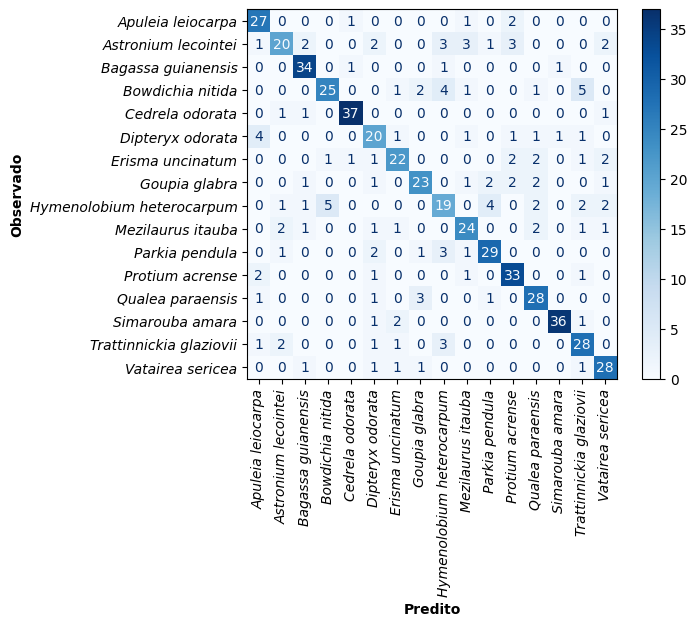

In [ ]:
# ================================================================================
# Matriz de Confusão - conjunto de teste (n = 566)
# ================================================================================
cm = confusion_matrix(y_test, y_pred_rs_ann)
disp_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels= rs_ann.classes_)
disp_cm.plot(cmap = 'Blues', xticks_rotation = 90)
disp_cm.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_cm.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_cm.ax_.xaxis.set_tick_params(labelsize=10)
disp_cm.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output/CNN/CM/cm_ann_mobnet', dpi = 800, bbox_inches='tight')
plt.show()


In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================

print(classification_report(y_test, y_pred_rs_ann))

                           precision    recall  f1-score   support

        Apuleia leiocarpa       0.75      0.87      0.81        31
      Astronium lecointei       0.74      0.54      0.62        37
       Bagassa guianensis       0.83      0.92      0.87        37
         Bowdichia nitida       0.81      0.64      0.71        39
          Cedrela odorata       0.93      0.93      0.93        40
         Dipteryx odorata       0.62      0.67      0.65        30
         Erisma uncinatum       0.76      0.69      0.72        32
            Goupia glabra       0.77      0.70      0.73        33
Hymenolobium heterocarpum       0.58      0.53      0.55        36
        Mezilaurus itauba       0.73      0.73      0.73        33
           Parkia pendula       0.78      0.78      0.78        37
          Protium acrense       0.77      0.87      0.81        38
         Qualea paraensis       0.74      0.82      0.78        34
          Simarouba amara       0.95      0.90      0.92     

### Suport Vector Classifier - SVC

In [ ]:
# ================================================================================
# Definições do estimador SVC
# ================================================================================
# SVC().get_params()

# Define o modelo
model_svc = SVC(decision_function_shape = 'ovo', probability = True)

In [ ]:
# ================================================================================
# Ajuste de Hiperparâmetros (Hyperparameter tuning) - RandomizedSearchCV()
# ================================================================================

param_grid = {
    'C': uniform(loc = 0.1, scale = 10).rvs(size = 20, random_state = 10),             # Uniform distribution between 0.1 and 10
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto'] + list(np.logspace(-9, 3, 13))
}

# Create the RandomizedSearchCV object
rs_svc = RandomizedSearchCV(estimator = model_svc, param_distributions = param_grid,
                                 scoring = metrics, cv = cv, refit = 'accuracy',
                                 verbose = 3, return_train_score = False, n_iter = 20)

rs_svc.fit(X_train, y_train, groups = sample_train)

pickle.dump(rs_svc, open(f'./Output/CNN/Models/rs_mobnet_svc.pickle', "wb"))
joblib.dump(rs_svc, f'./Output/CNN/Models/rs_mobnet_svc.joblib')

print(f'Os melhores parâmetros foram: {rs_svc.best_params_}')
print(f'A melhor acurácia foi de: {rs_svc.best_score_:.4f}')
print(f'O melhor modelo foi: {rs_svc.best_estimator_}')

In [ ]:
# ================================================================================
# Desempenho na Validação Cruzada (Stratified Group 5-fold cross-validation)
# ================================================================================
res1_rs_svc = pd.DataFrame(rs_svc.cv_results_).filter(regex = r'(params|test)').sort_values(by=["rank_test_accuracy"])

accf1_rs_svc = res1_rs_svc.iloc[0].filter(regex = r'(accuracy|f1)').filter(regex = 'split')
min_acc_rs_svc = accf1_rs_svc.filter(regex = 'accuracy').min()
max_acc_rs_svc = accf1_rs_svc.filter(regex = 'accuracy').max()
min_f1_rs_svc = accf1_rs_svc.filter(regex = 'f1').min()
max_f1_rs_svc = accf1_rs_svc.filter(regex = 'f1').max()

print(f'Acurácia min: {min_acc_rs_svc:.6f}')
print(f'Acurácia max: {max_acc_rs_svc:.6f}')
print(f'F1 min: {min_f1_rs_svc:.6f}')
print(f'F1 max: {max_f1_rs_svc:.6f}')

res2_rs_svc = res1_rs_svc.filter(regex = r'(mean|std|params)')
display(res2_rs_svc.iloc[0])

Acurácia min: 0.580135
Acurácia max: 0.626398
F1 min: 0.573628
F1 max: 0.615270


params                 {'kernel': 'poly', 'gamma': 1.0, 'degree': 3, ...
mean_test_accuracy                                               0.60296
std_test_accuracy                                               0.016889
mean_test_precision                                             0.611761
std_test_precision                                              0.013198
mean_test_recall                                                 0.60296
std_test_recall                                                 0.016889
mean_test_f1_score                                               0.59598
std_test_f1_score                                                0.01391
Name: 16, dtype: object

In [ ]:
# ================================================================================
# Desempenho no conjunto de teste (n = 566)
# ================================================================================
y_pred_rs_svc = rs_svc.predict(X_test)
accuracy_rs_svc = accuracy_score(y_test, y_pred_rs_svc)
f1_rs_svc = f1_score(y_test, y_pred_rs_svc, average = 'weighted')
print(f"Best SVC Accuracy: {accuracy_rs_svc:.6f}")
print(f"Best SVC F1: {f1_rs_svc:.6f}")

Best SVC Accuracy: 0.733216
Best SVC F1: 0.728748


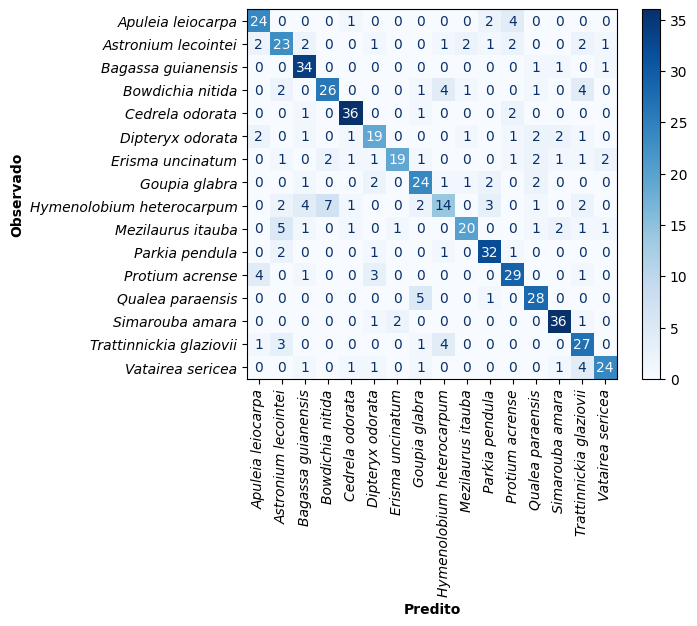

In [ ]:
# ================================================================================
# Matriz de Confusão - conjunto de teste (n = 566)
# ================================================================================
cm_svc = confusion_matrix(y_test, y_pred_rs_svc)
disp_cm_svc = ConfusionMatrixDisplay(confusion_matrix = cm_svc, display_labels= rs_svc.classes_)
disp_cm_svc.plot(cmap = 'Blues', xticks_rotation = 90)
disp_cm_svc.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_cm_svc.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_cm_svc.ax_.xaxis.set_tick_params(labelsize=10)
disp_cm_svc.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output/CNN/CM/cm_svc_mobnet', dpi = 800, bbox_inches='tight')
plt.show()


In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================

print(classification_report(y_test, y_pred_rs_svc))

                           precision    recall  f1-score   support

        Apuleia leiocarpa       0.73      0.77      0.75        31
      Astronium lecointei       0.61      0.62      0.61        37
       Bagassa guianensis       0.74      0.92      0.82        37
         Bowdichia nitida       0.74      0.67      0.70        39
          Cedrela odorata       0.86      0.90      0.88        40
         Dipteryx odorata       0.66      0.63      0.64        30
         Erisma uncinatum       0.86      0.59      0.70        32
            Goupia glabra       0.67      0.73      0.70        33
Hymenolobium heterocarpum       0.56      0.39      0.46        36
        Mezilaurus itauba       0.80      0.61      0.69        33
           Parkia pendula       0.78      0.86      0.82        37
          Protium acrense       0.72      0.76      0.74        38
         Qualea paraensis       0.74      0.82      0.78        34
          Simarouba amara       0.84      0.90      0.87     

### Random Forest - RF

In [ ]:
# ================================================================================
# Definições do estimador RF
# ================================================================================
#RandomForestClassifier().get_params()

# Define o modelo
model_rf = RandomForestClassifier(random_state = 10)

In [ ]:
# ================================================================================
# Ajuste de Hiperparâmetros (Hyperparameter tuning) - RandomizedSearchCV()
# ================================================================================

param_grid = {'n_estimators': np.arange(40, 320, 20),                        # Número de árvores (estimadores) na floresta aleatória
              'max_depth': list(np.arange(10, 100, step=10)) + [None],       # Número máximo de níveis na árvore
              'max_features': list(np.arange(30, 60, 5)) + ['sqrt', "log2"], # Número de variáveis a serem considerados em cada divisão
              'criterion': ['gini','entropy'],
              'min_samples_leaf': np.arange(10, 110, 10),                    # Número mínimo de amostras exigidos em cada nó folha (terminal)
              'min_samples_split': np.arange(2, 10, 2),                      # Número mínimo de amostras exigido para dividir um nó
              'bootstrap': [True, False]                                     # Método de seleção de amostras para treinamento de cada árvore
              }

# Create the RandomizedSearchCV object
rs_rf = RandomizedSearchCV(estimator = model_rf, param_distributions = param_grid,
                           scoring = metrics, cv = cv, refit = 'accuracy',
                           verbose = 3, return_train_score = False, n_iter = 50)

rs_rf.fit(X_train, y_train, groups = sample_train)

pickle.dump(rs_rf, open(f'./Output/CNN/Models/rs_mobnet_rf.pickle', "wb"))
joblib.dump(rs_rf, f'./Output/CNN/Models/rs_mobnet_rf.joblib')

print(f'Melhores hiperparâmetros: {rs_rf.best_params_}')
print(f'Melhor Acurácia: {rs_rf.best_score_}')
print(f'Melhor Estimador: {rs_rf.best_estimator_}')

In [ ]:
# ================================================================================
# Desempenho na Validação Cruzada (Stratified Group 5-fold cross-validation)
# ================================================================================
res1_rs_rf = pd.DataFrame(rs_rf.cv_results_).filter(regex = r'(params|test)').sort_values(by=["rank_test_accuracy"])

accf1_rs_rf = res1_rs_rf.iloc[0].filter(regex = r'(accuracy|f1)').filter(regex = 'split')
min_acc_rs_rf = accf1_rs_rf.filter(regex = 'accuracy').min()
max_acc_rs_rf = accf1_rs_rf.filter(regex = 'accuracy').max()
min_f1_rs_rf = accf1_rs_rf.filter(regex = 'f1').min()
max_f1_rs_rf = accf1_rs_rf.filter(regex = 'f1').max()

print(f'Acurácia min: {min_acc_rs_rf:.6f}')
print(f'Acurácia max: {max_acc_rs_rf:.6f}')
print(f'F1 min: {min_f1_rs_rf:.6f}')
print(f'F1 max: {max_f1_rs_rf:.6f}')

res2_rs_rf = res1_rs_rf.filter(regex = r'(mean|std|params)')
display(res2_rs_rf.iloc[0])

Acurácia min: 0.458239
Acurácia max: 0.519016
F1 min: 0.429021
F1 max: 0.492147


params                 {'n_estimators': 60, 'min_samples_split': 2, '...
mean_test_accuracy                                               0.48946
std_test_accuracy                                               0.022514
mean_test_precision                                             0.496438
std_test_precision                                              0.034976
mean_test_recall                                                 0.48946
std_test_recall                                                 0.022514
mean_test_f1_score                                              0.462919
std_test_f1_score                                               0.025831
Name: 35, dtype: object

In [ ]:
# ================================================================================
# Desempenho no conjunto de teste (n = 566)
# ================================================================================
y_pred_rs_rf = rs_rf.predict(X_test)
accuracy_rs_rf = accuracy_score(y_test, y_pred_rs_rf)
f1_rs_rf = f1_score(y_test, y_pred_rs_rf, average = 'weighted')
print(f"Best RF Accuracy: {accuracy_rs_rf:.6f}")
print(f"Best RF F1: {f1_rs_rf:.6f}")

Best RF Accuracy: 0.574205
Best RF F1: 0.561550


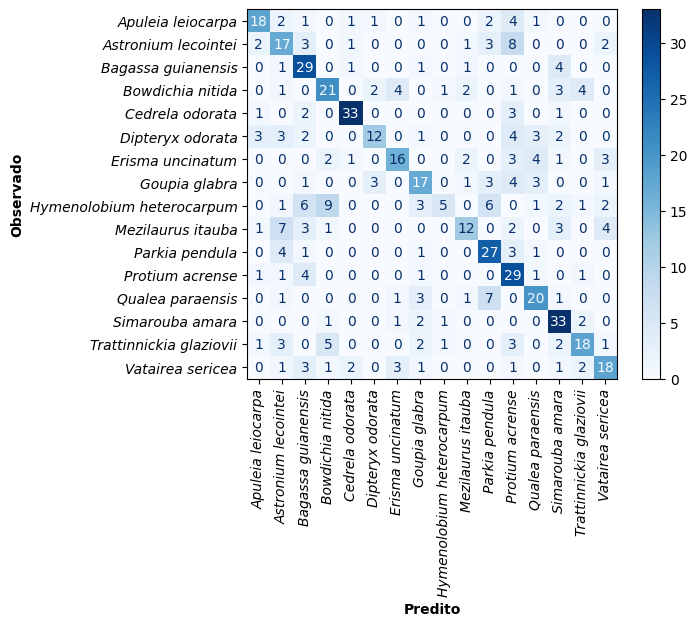

In [ ]:
# ================================================================================
# Matriz de Confusão - conjunto de teste (n = 566)
# ================================================================================
cm_rf = confusion_matrix(y_test, y_pred_rs_rf)
disp_cm_rf = ConfusionMatrixDisplay(confusion_matrix = cm_rf, display_labels= rs_rf.classes_)
disp_cm_rf.plot(cmap = 'Blues', xticks_rotation = 90)
disp_cm_rf.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_cm_rf.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_cm_rf.ax_.xaxis.set_tick_params(labelsize=10)
disp_cm_rf.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output/CNN/CM/cm_rf_mobnet', dpi = 800, bbox_inches='tight')
plt.show()


In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================

print(classification_report(y_test, y_pred_rs_rf))

                           precision    recall  f1-score   support

        Apuleia leiocarpa       0.67      0.58      0.62        31
      Astronium lecointei       0.40      0.46      0.43        37
       Bagassa guianensis       0.53      0.78      0.63        37
         Bowdichia nitida       0.53      0.54      0.53        39
          Cedrela odorata       0.85      0.82      0.84        40
         Dipteryx odorata       0.67      0.40      0.50        30
         Erisma uncinatum       0.64      0.50      0.56        32
            Goupia glabra       0.52      0.52      0.52        33
Hymenolobium heterocarpum       0.62      0.14      0.23        36
        Mezilaurus itauba       0.60      0.36      0.45        33
           Parkia pendula       0.56      0.73      0.64        37
          Protium acrense       0.45      0.76      0.56        38
         Qualea paraensis       0.59      0.59      0.59        34
          Simarouba amara       0.62      0.82      0.71     

### Linear Discriminant Analysis - LDA

In [ ]:
# ================================================================================
# Definições do estimador LDA
# ================================================================================
# LinearDiscriminantAnalysis().get_params()

# Define o modelo
model_lda = LinearDiscriminantAnalysis(shrinkage='auto', n_components = None)

In [ ]:
# ================================================================================
# Ajuste de Hiperparâmetros (Hyperparameter tuning) - RandomizedSearchCV()
# ================================================================================

param_grid = {'solver': ['svd', 'lsqr', 'eigen'],
              'tol' : [0.0001, 0.0002, 0.0003]}

# Create the RandomizedSearchCV object
rs_lda = RandomizedSearchCV(estimator = model_lda, param_distributions = param_grid,
                            scoring = metrics, cv = cv, refit = 'accuracy',
                            verbose = 3, return_train_score = False, n_iter = 50)

rs_lda.fit(X_train, y_train, groups = sample_train)

pickle.dump(rs_lda, open(f'./Output/CNN/Models/rs_mobnet_lda.pickle', "wb"))
joblib.dump(rs_lda, f'./Output/CNN/Models/rs_mobnet_lda.joblib')

print(f'Os melhores parâmetros foram: {rs_lda.best_params_}')
print(f'A melhor acurácia foi de: {rs_lda.best_score_:.4f}')
print(f'O melhor modelo foi: {rs_lda.best_estimator_}')

In [ ]:
# ================================================================================
# Desempenho na Validação Cruzada (Stratified Group 5-fold cross-validation)
# ================================================================================
res1_rs_lda = pd.DataFrame(rs_lda.cv_results_).filter(regex = r'(params|test)').sort_values(by=["rank_test_accuracy"])

accf1_rs_lda = res1_rs_lda.iloc[0].filter(regex = r'(accuracy|f1)').filter(regex = 'split')
min_acc_rs_lda = accf1_rs_lda.filter(regex = 'accuracy').min()
max_acc_rs_lda = accf1_rs_lda.filter(regex = 'accuracy').max()
min_f1_rs_lda = accf1_rs_lda.filter(regex = 'f1').min()
max_f1_rs_lda = accf1_rs_lda.filter(regex = 'f1').max()

print(f'Acurácia min: {min_acc_rs_lda:.6f}')
print(f'Acurácia max: {max_acc_rs_lda:.6f}')
print(f'F1 min: {min_f1_rs_lda:.6f}')
print(f'F1 max: {max_f1_rs_lda:.6f}')

res2_rs_lda = res1_rs_lda.filter(regex = r'(mean|std|params)')
display(res2_rs_lda.iloc[0])

Acurácia min: 0.550562
Acurácia max: 0.612975
F1 min: 0.560201
F1 max: 0.598430


params                 {'tol': 0.0001, 'solver': 'lsqr'}
mean_test_accuracy                              0.590038
std_test_accuracy                               0.021003
mean_test_precision                              0.61279
std_test_precision                              0.010666
mean_test_recall                                0.590038
std_test_recall                                 0.021003
mean_test_f1_score                              0.587882
std_test_f1_score                               0.014097
Name: 3, dtype: object

In [ ]:
# ================================================================================
# Desempenho no conjunto de teste (n = 566)
# ================================================================================
y_pred_rs_lda = rs_lda.predict(X_test)
accuracy_rs_lda = accuracy_score(y_test, y_pred_rs_lda)
f1_rs_lda = f1_score(y_test, y_pred_rs_lda, average = 'weighted')
print(f"Best LDA Accuracy: {accuracy_rs_lda:.6f}")
print(f"Best LDA F1: {f1_rs_lda:.6f}")

Best LDA Accuracy: 0.715548
Best LDA F1: 0.716220


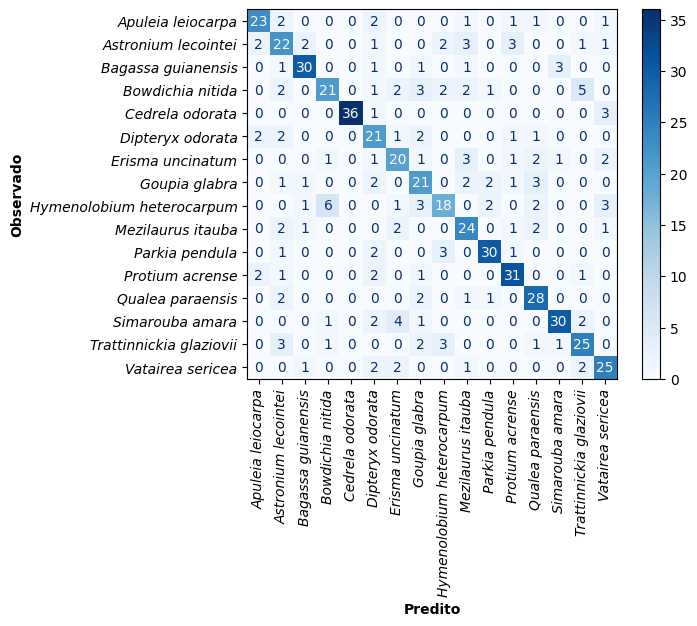

In [ ]:
# ================================================================================
# Matriz de Confusão - conjunto de teste (n = 566)
# ================================================================================
cm_lda = confusion_matrix(y_test, y_pred_rs_lda)
disp_cm_lda = ConfusionMatrixDisplay(confusion_matrix = cm_lda, display_labels= rs_lda.classes_)
disp_cm_lda.plot(cmap = 'Blues', xticks_rotation = 90)
disp_cm_lda.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_cm_lda.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_cm_lda.ax_.xaxis.set_tick_params(labelsize=10)
disp_cm_lda.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output/CNN/CM/cm_lda_mobnet', dpi = 800, bbox_inches='tight')
plt.show()


In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================

print(classification_report(y_test, y_pred_rs_lda))

                           precision    recall  f1-score   support

        Apuleia leiocarpa       0.79      0.74      0.77        31
      Astronium lecointei       0.56      0.59      0.58        37
       Bagassa guianensis       0.83      0.81      0.82        37
         Bowdichia nitida       0.70      0.54      0.61        39
          Cedrela odorata       1.00      0.90      0.95        40
         Dipteryx odorata       0.55      0.70      0.62        30
         Erisma uncinatum       0.62      0.62      0.62        32
            Goupia glabra       0.57      0.64      0.60        33
Hymenolobium heterocarpum       0.64      0.50      0.56        36
        Mezilaurus itauba       0.63      0.73      0.68        33
           Parkia pendula       0.83      0.81      0.82        37
          Protium acrense       0.78      0.82      0.79        38
         Qualea paraensis       0.70      0.82      0.76        34
          Simarouba amara       0.86      0.75      0.80     

# **Patches**

In [ ]:
# ================================================================================
# Configurações gerais do treinamento
# ================================================================================

# Define Stratified Group 10-fold cross-validation
cv = StratifiedGroupKFold(n_splits = 10, random_state = 42, shuffle = True)

# Salvando o modelo (Pasta: Models/)
def save_model_pickle(model, model_name):
    with open(f'./Output_patches/CNN/Models/{model_name}.pickle', "wb") as file:
        pickle.dump(model, file)

def save_model_joblib(model, model_name):
    with open(f'./Output_patches/CNN/Models/{model_name}.joblib', "wb") as file:
        joblib.dump(model, file)

## **ResNet50**

In [ ]:
#-----------------------------------------------------------------------------#
# Carregar o arquivo .npz
#-----------------------------------------------------------------------------#
with np.load('./Output_patches/CNN/Features/patches_resnet_train.npz', mmap_mode= 'r', allow_pickle=True) as f:
    X_train = f['X_train']
    y_train = f['y_train']

with np.load('./Output_patches/CNN/Features/patches_resnet_test.npz', mmap_mode= 'r', allow_pickle=True) as f:
    X_test = f['X_test']
    y_test = f['y_test']

In [ ]:
print(f'X_train resnet: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test resnet: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train resnet: (111850, 2048)
y_train: (111850, 5)
X_test resnet: (28300, 2048)
y_test: (28300, 5)


In [ ]:
#-----------------------------------------------------------------------------#
# Dividindo variáveis
#-----------------------------------------------------------------------------#

dic = { 0: 'Patch', 1: 'Class', 2: 'Sample', 3: 'Id', 4:'Dev'}
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

# Renomeando as colunas
y_train.rename(columns=dic, inplace=True)
y_test.rename(columns=dic, inplace=True)

display(y_train)

In [ ]:
#-----------------------------------------------------------------------------#
# Gerando coluna de código de patches
#-----------------------------------------------------------------------------#

y_test['Id'] = y_test['Dev'] + '_' + y_test['Sample'].astype(str) + '_' + y_test['Id'].astype(str)
y_train['Id'] = y_train['Dev'] + '_' + y_train['Sample'].astype(str) + '_' + y_train['Id'].astype(str)
z_train = y_train.filter(items = ['Id'])
y_train = y_train.filter(items = ['Class', 'Sample'])
display(y_test)

Patch              Class Sample      Id Dev
0         0  Apuleia leiocarpa     30  I_30_5   I
1         1  Apuleia leiocarpa     30  I_30_5   I
2         2  Apuleia leiocarpa     30  I_30_5   I
3         3  Apuleia leiocarpa     30  I_30_5   I
4         4  Apuleia leiocarpa     30  I_30_5   I
...     ...                ...    ...     ...  ..
28295    45   Vatairea sericea     62  C_62_8   C
28296    46   Vatairea sericea     62  C_62_8   C
28297    47   Vatairea sericea     62  C_62_8   C
28298    48   Vatairea sericea     62  C_62_8   C
28299    49   Vatairea sericea     62  C_62_8   C

[28300 rows x 5 columns]

In [ ]:
#-----------------------------------------------------------------------------#
# Codificação dos patches
#-----------------------------------------------------------------------------#
'''Para inserir o código das amostras e dos patches na CV foi necessário codificar os patches e as amostras.'''

def converter_variaveis_objeto_para_int(df):
    # Inicialize o LabelEncoder
    label_encoder = LabelEncoder()

    # Itere sobre as colunas do DataFrame
    for coluna in df.columns:
        # Verifique se a coluna é do tipo 'object'
        if df[coluna].dtype == 'object':
            # Ajuste e transforme os dados usando o LabelEncoder
            df[coluna] = label_encoder.fit_transform(df[coluna])

    return df

z_train = converter_variaveis_objeto_para_int(df = z_train)
y_train = pd.concat([y_train, z_train], axis = 1)
z_train = y_train['Sample'].astype(str) + '_' + y_train['Id'].astype(str)
z_train

### Artificial Neural Networks - ANN

In [ ]:
# ================================================================================
# Definições do estimador ANN
# ================================================================================

rs_resnet_ann = pickle.load(open("./Output/CNN/Models/rs_resnet_ann.pickle", "rb"))
best_ann = rs_resnet_ann.best_estimator_

In [ ]:
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []


for i, (train_index, test_index) in enumerate(cv.split(X_train, y_train['Class'], groups= z_train)):
  print(f'Criando fold {i+1} >>>')
  print('='*70)

  print(f'Conjunto de treino antes da divisão: {X_train.shape}')
  print(f'Conjunto de validação antes da divisão: {X_train.shape}')

  # Separando fold de treino e validação
  x_train_fold, x_test_fold = X_train[train_index], X_train[test_index]
  y_train_fold, y_test_fold = y_train['Class'].iloc[train_index], y_train['Class'].iloc[test_index]
  z_train_fold = [name.split('_')[0] for name in z_train.iloc[train_index]]
  z_test_fold = [name.split('_')[0] for name in z_train.iloc[test_index]]
  w_train_fold = [name.split('_')[1] for name in z_train.iloc[train_index]]
  w_test_fold = [name.split('_')[1] for name in z_train.iloc[test_index]]

  print(f'Conjunto de treino após divisão: {x_train_fold.shape}')
  print(f'Conjunto de validação após divisão: {x_test_fold.shape}')
  print('='*70)
  print(f'Treinando fold {i+1} >>>')

  # Ajuste do modelo para cada fold
  best_ann.fit(x_train_fold, y_train_fold)

  print('='*70)
  print(f'Fazendo previsões para o fold {i+1}>>>')
  # Colete previsões para este fold
  fold_predictions = best_ann.predict_proba(x_test_fold)

  # Soma das probabilidades das classes dentro de cada grupo(w_test_fold)
  fold_predictions = pd.DataFrame(fold_predictions, columns=best_ann.classes_)
  fold_predictions = fold_predictions.groupby(w_test_fold).sum()

  # Encontrando classe com maior probabilidade para cada grupo(w_test_fold)
  fold_predictions = fold_predictions.idxmax(axis=1)

  # Obtain the observed class for each group(w_test_fold)
  fold_obs = y_test_fold.groupby(w_test_fold).first()

  # Obtendo métricas por fold
  accuracy_fold = accuracy_score(fold_obs, fold_predictions)
  f1_fold = f1_score(fold_obs, fold_predictions, average='weighted')
  recall_fold = recall_score(fold_obs, fold_predictions, average='weighted')
  precision_fold = precision_score(fold_obs, fold_predictions, average='weighted')

  print('='*70)
  print(f'Listando métricas para o fold {i+1}>>>')
  # Listando métricas
  accuracy_scores.append(accuracy_fold)
  f1_scores.append(f1_fold)
  recall_scores.append(recall_fold)
  precision_scores.append(precision_fold)

  print(f'Fold {i+1} finalizado!!!')
  print('*'*70)

# Salvando o modelo
print('='*70)
print('Salvando modelo...')
save_model_pickle(best_ann, 'best_ann')
save_model_joblib(best_ann, 'best_ann')

print('MODELO SALVO!')

Criando fold 1 >>>
Conjunto de treino antes da divisão: (111850, 2048)
Conjunto de validação antes da divisão: (111850, 2048)
Conjunto de treino após divisão: (100650, 2048)
Conjunto de validação após divisão: (11200, 2048)
Treinando fold 1 >>>
Fazendo previsões para o fold 1>>>
Listando métricas para o fold 1>>>
Fold 1 finalizado!!!
**********************************************************************
Criando fold 2 >>>
Conjunto de treino antes da divisão: (111850, 2048)
Conjunto de validação antes da divisão: (111850, 2048)
Conjunto de treino após divisão: (100650, 2048)
Conjunto de validação após divisão: (11200, 2048)
Treinando fold 2 >>>
Fazendo previsões para o fold 2>>>
Listando métricas para o fold 2>>>
Fold 2 finalizado!!!
**********************************************************************
Criando fold 3 >>>
Conjunto de treino antes da divisão: (111850, 2048)
Conjunto de validação antes da divisão: (111850, 2048)
Conjunto de treino após divisão: (100650, 2048)
Conjunto de 

In [ ]:
#===============================================================================
# Visualizando métricas por fold - Conjunto de Validação - Voto Majoritário
#===============================================================================

print('='*70)
print("Métricas por fold:")
print('='*70)
for i in range(len(accuracy_scores)):
    print(f"Fold {i+1}: Accuracy={accuracy_scores[i]:.4f}, F1={f1_scores[i]:.4f}, Recall={recall_scores[i]:.4f}, Precision={precision_scores[i]:.4f}")

# Calculando média das métricas
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
min_acc = np.min(accuracy_scores)
max_acc = np.max(accuracy_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
min_f1 = np.min(f1_scores)
max_f1 = np.max(f1_scores)
mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)
min_recall = np.min(recall_scores)
max_recall = np.max(recall_scores)
mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
min_precision = np.min(precision_scores)
max_precision = np.max(precision_scores)

print('='*70)
print("Mean -- Standard Deviation -- Minimum Value -- Maximum Value")
print('='*70)
# Visualizando média das métricas
print(f"Accuracy -> mean: {mean_accuracy:.4f}, std: {std_accuracy:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"F1 Score -> mean: {mean_f1:.4f}, std: {std_f1:.4f}, min: {min_f1:.4f}, max: {max_f1:.4f}")
print(f"Recall -> mean: {mean_recall:.4f}, std: {std_recall:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"Precision -> mean: {mean_precision:.4f}, std: {std_precision:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")

Métricas por fold:
Fold 1: Accuracy=0.9643, F1=0.9637, Recall=0.9643, Precision=0.9653
Fold 2: Accuracy=0.9688, F1=0.9686, Recall=0.9688, Precision=0.9696
Fold 3: Accuracy=0.9643, F1=0.9641, Recall=0.9643, Precision=0.9684
Fold 4: Accuracy=0.9375, F1=0.9373, Recall=0.9375, Precision=0.9422
Fold 5: Accuracy=0.9196, F1=0.9195, Recall=0.9196, Precision=0.9248
Fold 6: Accuracy=0.9596, F1=0.9596, Recall=0.9596, Precision=0.9628
Fold 7: Accuracy=0.9464, F1=0.9461, Recall=0.9464, Precision=0.9532
Fold 8: Accuracy=0.9552, F1=0.9562, Recall=0.9552, Precision=0.9601
Fold 9: Accuracy=0.9420, F1=0.9414, Recall=0.9420, Precision=0.9463
Fold 10: Accuracy=0.9776, F1=0.9775, Recall=0.9776, Precision=0.9787
Mean -- Standard Deviation -- Minimum Value -- Maximum Value
Accuracy -> mean: 0.9535, std: 0.0163, min: 0.9196, max: 0.9776
F1 Score -> mean: 0.9534, std: 0.0164, min: 0.9195, max: 0.9775
Recall -> mean: 0.9535, std: 0.0163, min: 0.9196, max: 0.9776
Precision -> mean: 0.9571, std: 0.0150, min: 0.91

In [ ]:
#===============================================================================
# Obtendo tabela de probabilidades - 28300 patches de imagens
#===============================================================================

prob_ann = best_ann.predict_proba(X_test)
prob_ann = pd.DataFrame(prob_ann, columns = best_ann.classes_)
class_value = prob_ann.idxmax(axis=1)
prob_value = prob_ann.max(axis=1)

# Obtendo tabela de classes preditas e observadas
prob_ann = pd.DataFrame({'Classe_Predita': class_value, 'Probabilidade': prob_value})
prob_ann = pd.concat([y_test, prob_ann], axis = 1)
prob_ann

In [ ]:
#===============================================================================
# Obtendo resultado por Voto Majoritário (n= 566)
#===============================================================================

# Agrupar os dados por 'Id' e calcular a soma das probabilidades para cada classe
soma_prob_ann = prob_ann.groupby('Id').apply(lambda x: x.groupby('Classe_Predita')['Probabilidade'].sum())

#Para cada grupo de 'Id', selecionar a classe com a maior soma de probabilidades
class_ann = soma_prob_ann.groupby('Id').idxmax()

#Obter a classe observada para cada grupo de 'Id'
class_obs_ann = prob_ann.groupby('Id')['Class'].first()

# Criar um DataFrame com as informações de interesse
resultado_ann = pd.DataFrame({'Id': class_ann.index,
                          'Probabilidade': soma_prob_ann.groupby('Id').max(),
                          'Classe_Predita': class_ann.values,
                          'Classe_Observada': class_obs_ann.values})

# Exibir o resultado
resultado_ann = resultado_ann[['Probabilidade', 'Classe_Predita', 'Classe_Observada']]
# Extrair apenas o nome da classe predita
resultado_ann['Classe_Predita'] = resultado_ann['Classe_Predita'].apply(lambda x: x[1])
resultado_ann

In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================
print(classification_report(resultado_ann['Classe_Observada'], resultado_ann['Classe_Predita'], target_names= best_ann.classes_))

                           precision    recall  f1-score   support

        Apuleia leiocarpa       0.86      0.97      0.91        31
      Astronium lecointei       0.97      0.89      0.93        37
       Bagassa guianensis       1.00      0.97      0.99        37
         Bowdichia nitida       0.95      1.00      0.97        39
          Cedrela odorata       1.00      1.00      1.00        40
         Dipteryx odorata       0.83      0.83      0.83        30
         Erisma uncinatum       0.94      0.91      0.92        32
            Goupia glabra       0.94      0.88      0.91        33
Hymenolobium heterocarpum       1.00      0.92      0.96        36
        Mezilaurus itauba       0.97      0.97      0.97        33
           Parkia pendula       0.97      0.89      0.93        37
          Protium acrense       0.84      1.00      0.92        38
         Qualea paraensis       0.94      1.00      0.97        34
          Simarouba amara       1.00      0.97      0.99     

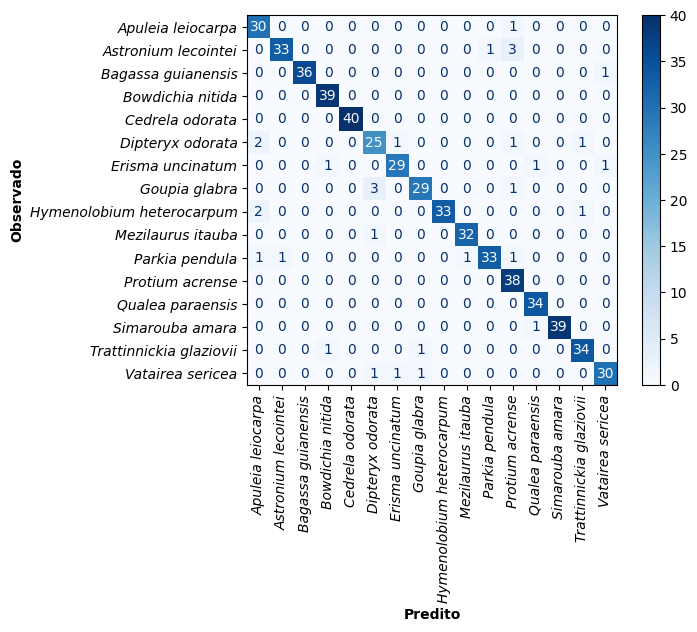

In [ ]:
# ================================================================================
# Matriz de Confusão - Conjunto de Teste (n = 566) - Voto Majoritário
# ================================================================================
cm_ann = confusion_matrix(resultado_ann['Classe_Observada'], resultado_ann['Classe_Predita'])
disp_ann = ConfusionMatrixDisplay(confusion_matrix = cm_ann, display_labels = best_ann.classes_)
disp_ann.plot(cmap = 'Blues', xticks_rotation = 90)
disp_ann.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_ann.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_ann.ax_.xaxis.set_tick_params(labelsize=10)
disp_ann.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output_patches/cm_resnet_ann', dpi=800, bbox_inches='tight')
plt.show()

### Suport Vector Classifier - SVC

In [ ]:
# ================================================================================
# Definições do estimador SVC
# ================================================================================

rs_resnet_svc = pickle.load(open("./Output/CNN/Models/rs_resnet_svc.pickle", "rb"))
best_svc = rs_resnet_svc.best_estimator_
best_svc.get_params()

{'C': 6.953598183677972,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovo',
 'degree': 3,
 'gamma': 1e-06,
 'kernel': 'linear',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []


for i, (train_index, test_index) in enumerate(cv.split(X_train, y_train['Class'], groups= z_train)):
  print(f'Criando fold {i+1} >>>')
  print('='*70)

  print(f'Conjunto de treino antes da divisão: {X_train.shape}')
  print(f'Conjunto de validação antes da divisão: {X_train.shape}')

  # Separando fold de treino e validação
  x_train_fold, x_test_fold = X_train[train_index], X_train[test_index]
  y_train_fold, y_test_fold = y_train['Class'].iloc[train_index], y_train['Class'].iloc[test_index]
  z_train_fold = [name.split('_')[0] for name in z_train.iloc[train_index]]
  z_test_fold = [name.split('_')[0] for name in z_train.iloc[test_index]]
  w_train_fold = [name.split('_')[1] for name in z_train.iloc[train_index]]
  w_test_fold = [name.split('_')[1] for name in z_train.iloc[test_index]]

  print(f'Conjunto de treino após divisão: {x_train_fold.shape}')
  print(f'Conjunto de validação após divisão: {x_test_fold.shape}')
  print('='*70)
  print(f'Treinando fold {i+1} >>>')

  # Ajuste do modelo para cada fold
  best_svc.fit(x_train_fold, y_train_fold)

  print('='*70)
  print(f'Fazendo previsões para o fold {i+1}>>>')
  # Colete previsões para este fold
  fold_predictions = best_svc.predict_proba(x_test_fold)

  # Soma das probabilidades das classes dentro de cada grupo(w_test_fold)
  fold_predictions = pd.DataFrame(fold_predictions, columns=best_svc.classes_)
  fold_predictions = fold_predictions.groupby(w_test_fold).sum()

  # Encontrando classe com maior probabilidade para cada grupo(w_test_fold)
  fold_predictions = fold_predictions.idxmax(axis=1)

  # Obtain the observed class for each group(w_test_fold)
  fold_obs = y_test_fold.groupby(w_test_fold).first()

  # Obtendo métricas por fold
  accuracy_fold = accuracy_score(fold_obs, fold_predictions)
  f1_fold = f1_score(fold_obs, fold_predictions, average='weighted')
  recall_fold = recall_score(fold_obs, fold_predictions, average='weighted')
  precision_fold = precision_score(fold_obs, fold_predictions, average='weighted')

  print('='*70)
  print(f'Listando métricas para o fold {i+1}>>>')
  # Listando métricas
  accuracy_scores.append(accuracy_fold)
  f1_scores.append(f1_fold)
  recall_scores.append(recall_fold)
  precision_scores.append(precision_fold)

  print(f'Fold {i+1} finalizado!!!')
  print('*'*70)

# Salvando o modelo
print('='*70)
print('Salvando modelo...')
save_model_pickle(best_svc, 'best_resnet_svc')
save_model_joblib(best_svc, 'best_resnet_svc')

print('MODELO SALVO!')

In [ ]:
#===============================================================================
# Visualizando métricas por fold - Conjunto de Validação - Voto Majoritário
#===============================================================================

print('='*70)
print("Métricas por fold:")
print('='*70)
for i in range(len(accuracy_scores)):
    print(f"Fold {i+1}: Accuracy={accuracy_scores[i]:.4f}, F1={f1_scores[i]:.4f}, Recall={recall_scores[i]:.4f}, Precision={precision_scores[i]:.4f}")

# Calculando média das métricas
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
min_acc = np.min(accuracy_scores)
max_acc = np.max(accuracy_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
min_f1 = np.min(f1_scores)
max_f1 = np.max(f1_scores)
mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)
min_recall = np.min(recall_scores)
max_recall = np.max(recall_scores)
mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
min_precision = np.min(precision_scores)
max_precision = np.max(precision_scores)

print('='*70)
print("Mean -- Standard Deviation -- Minimum Value -- Maximum Value")
print('='*70)
# Visualizando média das métricas
print(f"Accuracy -> mean: {mean_accuracy:.4f}, std: {std_accuracy:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"F1 Score -> mean: {mean_f1:.4f}, std: {std_f1:.4f}, min: {min_f1:.4f}, max: {max_f1:.4f}")
print(f"Recall -> mean: {mean_recall:.4f}, std: {std_recall:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"Precision -> mean: {mean_precision:.4f}, std: {std_precision:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")

Métricas por fold:
Fold 1: Accuracy=0.9643, F1=0.9642, Recall=0.9643, Precision=0.9675
Fold 2: Accuracy=0.9643, F1=0.9642, Recall=0.9643, Precision=0.9660
Fold 3: Accuracy=0.9464, F1=0.9463, Recall=0.9464, Precision=0.9496
Fold 4: Accuracy=0.9420, F1=0.9416, Recall=0.9420, Precision=0.9444
Fold 5: Accuracy=0.9420, F1=0.9418, Recall=0.9420, Precision=0.9430
Fold 6: Accuracy=0.9552, F1=0.9549, Recall=0.9552, Precision=0.9590
Fold 7: Accuracy=0.9732, F1=0.9731, Recall=0.9732, Precision=0.9748
Fold 8: Accuracy=0.9507, F1=0.9512, Recall=0.9507, Precision=0.9549
Fold 9: Accuracy=0.9688, F1=0.9687, Recall=0.9688, Precision=0.9719
Fold 10: Accuracy=0.9507, F1=0.9510, Recall=0.9507, Precision=0.9556
Mean -- Standard Deviation -- Minimum Value -- Maximum Value
Accuracy -> mean: 0.9557, std: 0.0107, min: 0.9420, max: 0.9732
F1 Score -> mean: 0.9557, std: 0.0107, min: 0.9416, max: 0.9731
Recall -> mean: 0.9557, std: 0.0107, min: 0.9420, max: 0.9732
Precision -> mean: 0.9587, std: 0.0106, min: 0.94

In [ ]:
#===============================================================================
# Obtendo tabela de probabilidades - 28300 patches de imagens
#===============================================================================

#best_svc = pickle.load(open("./Output_patches/CNN/Models/best_resnet_svc.pickle", "rb"))
prob_svc = best_svc.predict_proba(X_test)
prob_svc = pd.DataFrame(prob_svc, columns = best_svc.classes_)
class_value = prob_svc.idxmax(axis=1)
prob_value = prob_svc.max(axis=1)

# Obtendo tabela de classes preditas e observadas
prob_svc = pd.DataFrame({'Classe_Predita': class_value, 'Probabilidade': prob_value})
prob_svc = pd.concat([y_test, prob_svc], axis = 1)
prob_svc

In [ ]:
#===============================================================================
# Obtendo resultado por Voto Majoritário (n= 566)
#===============================================================================

# Agrupar os dados por 'Id' e calcular a soma das probabilidades para cada classe
soma_prob_svc = prob_svc.groupby('Id').apply(lambda x: x.groupby('Classe_Predita')['Probabilidade'].sum())

#Para cada grupo de 'Id', selecionar a classe com a maior soma de probabilidades
class_svc = soma_prob_svc.groupby('Id').idxmax()

#Obter a classe observada para cada grupo de 'Id'
class_obs_svc = prob_svc.groupby('Id')['Class'].first()

# Criar um DataFrame com as informações de interesse
resultado_svc = pd.DataFrame({'Id': class_svc.index,
                          'Probabilidade': soma_prob_svc.groupby('Id').max(),
                          'Classe_Predita': class_svc.values,
                          'Classe_Observada': class_obs_svc.values})

# Exibir o resultado
resultado_svc = resultado_svc[['Probabilidade', 'Classe_Predita', 'Classe_Observada']]
# Extrair apenas o nome da classe predita
resultado_svc['Classe_Predita'] = resultado_svc['Classe_Predita'].apply(lambda x: x[1])
resultado_svc

In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================
print(classification_report(resultado_svc['Classe_Observada'], resultado_svc['Classe_Predita'], target_names= best_svc.classes_))

                           precision    recall  f1-score   support

        Apuleia leiocarpa       0.84      1.00      0.91        31
      Astronium lecointei       0.92      0.97      0.95        37
       Bagassa guianensis       1.00      1.00      1.00        37
         Bowdichia nitida       0.97      1.00      0.99        39
          Cedrela odorata       1.00      1.00      1.00        40
         Dipteryx odorata       0.93      0.87      0.90        30
         Erisma uncinatum       0.91      0.91      0.91        32
            Goupia glabra       0.91      0.94      0.93        33
Hymenolobium heterocarpum       0.97      0.94      0.96        36
        Mezilaurus itauba       0.97      0.94      0.95        33
           Parkia pendula       1.00      0.89      0.94        37
          Protium acrense       0.95      0.95      0.95        38
         Qualea paraensis       0.92      1.00      0.96        34
          Simarouba amara       0.98      1.00      0.99     

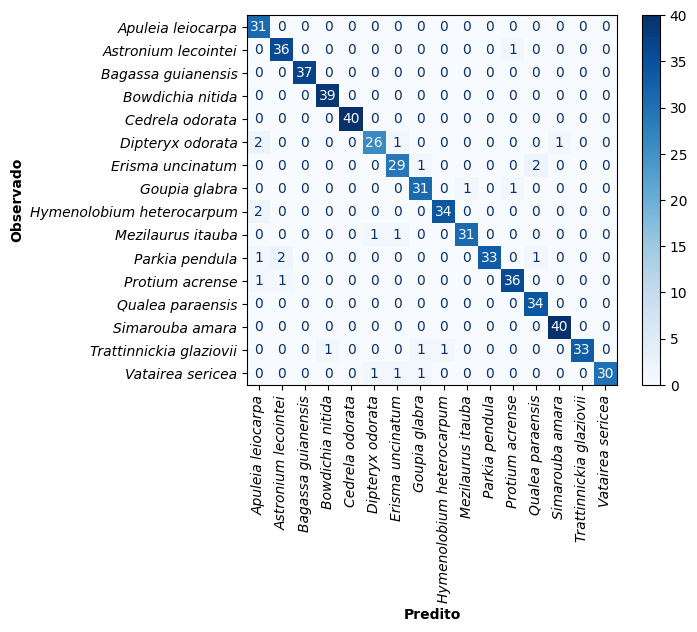

In [ ]:
# ================================================================================
# Matriz de Confusão - Conjunto de Teste (n = 566) - Voto Majoritário
# ================================================================================
cm_svc = confusion_matrix(resultado_svc['Classe_Observada'], resultado_svc['Classe_Predita'])
disp_svc = ConfusionMatrixDisplay(confusion_matrix = cm_svc, display_labels = best_svc.classes_)
disp_svc.plot(cmap = 'Blues', xticks_rotation = 90)
disp_svc.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_svc.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_svc.ax_.xaxis.set_tick_params(labelsize=10)
disp_svc.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output_patches/CNN/CM/cm_resnet_svc', dpi=800, bbox_inches='tight')
plt.show()

### Random Forest - RF

In [ ]:
# ================================================================================
# Definições do estimador RF
# ================================================================================

rs_resnet_rf = pickle.load(open("./Output/CNN/Models/rs_resnet_rf.pickle", "rb"))
best_rf = rs_resnet_rf.best_estimator_

In [ ]:
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []


for i, (train_index, test_index) in enumerate(cv.split(X_train, y_train['Class'], groups= z_train)):
  print(f'Criando fold {i+1} >>>')
  print('='*70)

  print(f'Conjunto de treino antes da divisão: {X_train.shape}')
  print(f'Conjunto de validação antes da divisão: {X_train.shape}')

  # Separando fold de treino e validação
  x_train_fold, x_test_fold = X_train[train_index], X_train[test_index]
  y_train_fold, y_test_fold = y_train['Class'].iloc[train_index], y_train['Class'].iloc[test_index]
  z_train_fold = [name.split('_')[0] for name in z_train.iloc[train_index]]
  z_test_fold = [name.split('_')[0] for name in z_train.iloc[test_index]]
  w_train_fold = [name.split('_')[1] for name in z_train.iloc[train_index]]
  w_test_fold = [name.split('_')[1] for name in z_train.iloc[test_index]]

  print(f'Conjunto de treino após divisão: {x_train_fold.shape}')
  print(f'Conjunto de validação após divisão: {x_test_fold.shape}')
  print('='*70)
  print(f'Treinando fold {i+1} >>>')

  # Ajuste do modelo para cada fold
  best_rf.fit(x_train_fold, y_train_fold)

  print('='*70)
  print(f'Fazendo previsões para o fold {i+1}>>>')
  # Colete previsões para este fold
  fold_predictions = best_rf.predict_proba(x_test_fold)

  # Soma das probabilidades das classes dentro de cada grupo(w_test_fold)
  fold_predictions = pd.DataFrame(fold_predictions, columns=best_rf.classes_)
  fold_predictions = fold_predictions.groupby(w_test_fold).sum()

  # Encontrando classe com maior probabilidade para cada grupo(w_test_fold)
  fold_predictions = fold_predictions.idxmax(axis=1)

  # Obtain the observed class for each group(w_test_fold)
  fold_obs = y_test_fold.groupby(w_test_fold).first()

  # Obtendo métricas por fold
  accuracy_fold = accuracy_score(fold_obs, fold_predictions)
  f1_fold = f1_score(fold_obs, fold_predictions, average='weighted')
  recall_fold = recall_score(fold_obs, fold_predictions, average='weighted')
  precision_fold = precision_score(fold_obs, fold_predictions, average='weighted')

  print('='*70)
  print(f'Listando métricas para o fold {i+1}>>>')
  # Listando métricas
  accuracy_scores.append(accuracy_fold)
  f1_scores.append(f1_fold)
  recall_scores.append(recall_fold)
  precision_scores.append(precision_fold)

  print(f'Fold {i+1} finalizado!!!')
  print('*'*70)

# Salvando o modelo
print('='*70)
print('Salvando modelo...')
save_model_pickle(best_rf, 'best_resnet_rf')
save_model_joblib(best_rf, 'best_resnet_rf')

print('MODELO SALVO!')

In [ ]:
#===============================================================================
# Visualizando métricas por fold - Conjunto de Validação - Voto Majoritário
#===============================================================================

print('='*70)
print("Métricas por fold:")
print('='*70)
for i in range(len(accuracy_scores)):
    print(f"Fold {i+1}: Accuracy={accuracy_scores[i]:.4f}, F1={f1_scores[i]:.4f}, Recall={recall_scores[i]:.4f}, Precision={precision_scores[i]:.4f}")

# Calculando média das métricas
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
min_acc = np.min(accuracy_scores)
max_acc = np.max(accuracy_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
min_f1 = np.min(f1_scores)
max_f1 = np.max(f1_scores)
mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)
min_recall = np.min(recall_scores)
max_recall = np.max(recall_scores)
mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
min_precision = np.min(precision_scores)
max_precision = np.max(precision_scores)

print('='*70)
print("Mean -- Standard Deviation -- Minimum Value -- Maximum Value")
print('='*70)
# Visualizando média das métricas
print(f"Accuracy -> mean: {mean_accuracy:.4f}, std: {std_accuracy:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"F1 Score -> mean: {mean_f1:.4f}, std: {std_f1:.4f}, min: {min_f1:.4f}, max: {max_f1:.4f}")
print(f"Recall -> mean: {mean_recall:.4f}, std: {std_recall:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"Precision -> mean: {mean_precision:.4f}, std: {std_precision:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")

Métricas por fold:
Fold 1: Accuracy=0.8348, F1=0.8312, Recall=0.8348, Precision=0.8489
Fold 2: Accuracy=0.8616, F1=0.8599, Recall=0.8616, Precision=0.8763
Fold 3: Accuracy=0.8750, F1=0.8728, Recall=0.8750, Precision=0.8843
Fold 4: Accuracy=0.8125, F1=0.8039, Recall=0.8125, Precision=0.8162
Fold 5: Accuracy=0.7902, F1=0.7878, Recall=0.7902, Precision=0.8108
Fold 6: Accuracy=0.8475, F1=0.8475, Recall=0.8475, Precision=0.8606
Fold 7: Accuracy=0.8661, F1=0.8611, Recall=0.8661, Precision=0.8722
Fold 8: Accuracy=0.8924, F1=0.8921, Recall=0.8924, Precision=0.8984
Fold 9: Accuracy=0.8482, F1=0.8475, Recall=0.8482, Precision=0.8591
Fold 10: Accuracy=0.8475, F1=0.8439, Recall=0.8475, Precision=0.8501
Mean -- Standard Deviation -- Minimum Value -- Maximum Value
Accuracy -> mean: 0.8476, std: 0.0283, min: 0.7902, max: 0.8924
F1 Score -> mean: 0.8448, std: 0.0294, min: 0.7878, max: 0.8921
Recall -> mean: 0.8476, std: 0.0283, min: 0.7902, max: 0.8924
Precision -> mean: 0.8577, std: 0.0264, min: 0.79

In [ ]:
#===============================================================================
# Obtendo tabela de probabilidades - 28300 patches de imagens
#===============================================================================

prob_rf = best_rf.predict_proba(X_test)
prob_rf = pd.DataFrame(prob_rf, columns = best_rf.classes_)
class_value = prob_rf.idxmax(axis=1)
prob_value = prob_rf.max(axis=1)

# Obtendo tabela de classes preditas e observadas
prob_rf = pd.DataFrame({'Classe_Predita': class_value, 'Probabilidade': prob_value})
prob_rf = pd.concat([y_test, prob_rf], axis = 1)
prob_rf

In [ ]:
#===============================================================================
# Obtendo resultado por Voto Majoritário (n= 566)
#===============================================================================

# Agrupar os dados por 'Id' e calcular a soma das probabilidades para cada classe
soma_prob_rf = prob_rf.groupby('Id').apply(lambda x: x.groupby('Classe_Predita')['Probabilidade'].sum())

#Para cada grupo de 'Id', selecionar a classe com a maior soma de probabilidades
class_rf = soma_prob_rf.groupby('Id').idxmax()

#Obter a classe observada para cada grupo de 'Id'
class_obs_rf = prob_rf.groupby('Id')['Class'].first()

# Criar um DataFrame com as informações de interesse
resultado_rf = pd.DataFrame({'Id': class_rf.index,
                          'Probabilidade': soma_prob_rf.groupby('Id').max(),
                          'Classe_Predita': class_rf.values,
                          'Classe_Observada': class_obs_rf.values})

# Exibir o resultado
resultado_rf = resultado_rf[['Probabilidade', 'Classe_Predita', 'Classe_Observada']]
# Extrair apenas o nome da classe predita
resultado_rf['Classe_Predita'] = resultado_rf['Classe_Predita'].apply(lambda x: x[1])
resultado_rf

In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================
print(classification_report(resultado_rf['Classe_Observada'], resultado_rf['Classe_Predita'], target_names= best_rf.classes_))

                           precision    recall  f1-score   support

        Apuleia leiocarpa       0.67      1.00      0.81        31
      Astronium lecointei       0.90      0.73      0.81        37
       Bagassa guianensis       0.87      0.92      0.89        37
         Bowdichia nitida       0.92      0.90      0.91        39
          Cedrela odorata       0.91      1.00      0.95        40
         Dipteryx odorata       0.75      0.60      0.67        30
         Erisma uncinatum       0.77      0.84      0.81        32
            Goupia glabra       0.68      0.85      0.76        33
Hymenolobium heterocarpum       0.89      0.47      0.62        36
        Mezilaurus itauba       0.95      0.64      0.76        33
           Parkia pendula       0.89      0.89      0.89        37
          Protium acrense       0.77      0.89      0.83        38
         Qualea paraensis       0.89      0.97      0.93        34
          Simarouba amara       0.88      0.95      0.92     

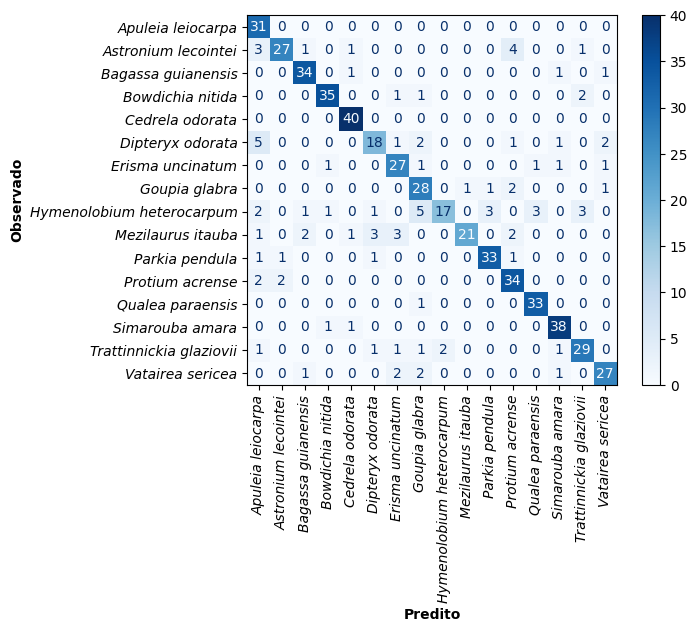

In [ ]:
# ================================================================================
# Matriz de Confusão - Conjunto de Teste (n = 566) - Voto Majoritário
# ================================================================================
cm_rf = confusion_matrix(resultado_rf['Classe_Observada'], resultado_rf['Classe_Predita'])
disp_rf = ConfusionMatrixDisplay(confusion_matrix = cm_rf, display_labels = best_rf.classes_)
disp_rf.plot(cmap = 'Blues', xticks_rotation = 90)
disp_rf.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_rf.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_rf.ax_.xaxis.set_tick_params(labelsize=10)
disp_rf.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output_patches/CNN/CM/cm_resnet_rf', dpi=800, bbox_inches='tight')
plt.show()

### Linear Discriminant Analysis - LDA

In [ ]:
# ================================================================================
# Definições do estimador LDA
# ================================================================================

rs_resnet_lda = pickle.load(open("./Output/CNN/Models/rs_resnet_lda.pickle", "rb"))
best_lda = rs_resnet_lda.best_estimator_

In [ ]:
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []


for i, (train_index, test_index) in enumerate(cv.split(X_train, y_train['Class'], groups= z_train)):
  print(f'Criando fold {i+1} >>>')
  print('='*70)

  print(f'Conjunto de treino antes da divisão: {X_train.shape}')
  print(f'Conjunto de validação antes da divisão: {X_train.shape}')

  # Separando fold de treino e validação
  x_train_fold, x_test_fold = X_train[train_index], X_train[test_index]
  y_train_fold, y_test_fold = y_train['Class'].iloc[train_index], y_train['Class'].iloc[test_index]
  z_train_fold = [name.split('_')[0] for name in z_train.iloc[train_index]]
  z_test_fold = [name.split('_')[0] for name in z_train.iloc[test_index]]
  w_train_fold = [name.split('_')[1] for name in z_train.iloc[train_index]]
  w_test_fold = [name.split('_')[1] for name in z_train.iloc[test_index]]

  print(f'Conjunto de treino após divisão: {x_train_fold.shape}')
  print(f'Conjunto de validação após divisão: {x_test_fold.shape}')
  print('='*70)
  print(f'Treinando fold {i+1} >>>')

  # Ajuste do modelo para cada fold
  best_lda.fit(x_train_fold, y_train_fold)

  print('='*70)
  print(f'Fazendo previsões para o fold {i+1}>>>')
  # Colete previsões para este fold
  fold_predictions = best_lda.predict_proba(x_test_fold)

  # Soma das probabilidades das classes dentro de cada grupo(w_test_fold)
  fold_predictions = pd.DataFrame(fold_predictions, columns=best_lda.classes_)
  fold_predictions = fold_predictions.groupby(w_test_fold).sum()

  # Encontrando classe com maior probabilidade para cada grupo(w_test_fold)
  fold_predictions = fold_predictions.idxmax(axis=1)

  # Obtain the observed class for each group(w_test_fold)
  fold_obs = y_test_fold.groupby(w_test_fold).first()

  # Obtendo métricas por fold
  accuracy_fold = accuracy_score(fold_obs, fold_predictions)
  f1_fold = f1_score(fold_obs, fold_predictions, average='weighted')
  recall_fold = recall_score(fold_obs, fold_predictions, average='weighted')
  precision_fold = precision_score(fold_obs, fold_predictions, average='weighted')

  print('='*70)
  print(f'Listando métricas para o fold {i+1}>>>')
  # Listando métricas
  accuracy_scores.append(accuracy_fold)
  f1_scores.append(f1_fold)
  recall_scores.append(recall_fold)
  precision_scores.append(precision_fold)

  print(f'Fold {i+1} finalizado!!!')
  print('*'*70)

# Salvando o modelo
print('='*70)
print('Salvando modelo...')
save_model_pickle(best_lda, 'best_resnet_lda')
save_model_joblib(best_lda, 'best_resnet_lda')

print('MODELO SALVO!')

In [ ]:
#===============================================================================
# Visualizando métricas por fold - Conjunto de Validação - Voto Majoritário
#===============================================================================

print('='*70)
print("Métricas por fold:")
print('='*70)
for i in range(len(accuracy_scores)):
    print(f"Fold {i+1}: Accuracy={accuracy_scores[i]:.4f}, F1={f1_scores[i]:.4f}, Recall={recall_scores[i]:.4f}, Precision={precision_scores[i]:.4f}")

# Calculando média das métricas
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
min_acc = np.min(accuracy_scores)
max_acc = np.max(accuracy_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
min_f1 = np.min(f1_scores)
max_f1 = np.max(f1_scores)
mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)
min_recall = np.min(recall_scores)
max_recall = np.max(recall_scores)
mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
min_precision = np.min(precision_scores)
max_precision = np.max(precision_scores)

print('='*70)
print("Mean -- Standard Deviation -- Minimum Value -- Maximum Value")
print('='*70)
# Visualizando média das métricas
print(f"Accuracy -> mean: {mean_accuracy:.4f}, std: {std_accuracy:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"F1 Score -> mean: {mean_f1:.4f}, std: {std_f1:.4f}, min: {min_f1:.4f}, max: {max_f1:.4f}")
print(f"Recall -> mean: {mean_recall:.4f}, std: {std_recall:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"Precision -> mean: {mean_precision:.4f}, std: {std_precision:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")

Métricas por fold:
Fold 1: Accuracy=0.9062, F1=0.9071, Recall=0.9062, Precision=0.9168
Fold 2: Accuracy=0.9196, F1=0.9210, Recall=0.9196, Precision=0.9311
Fold 3: Accuracy=0.8973, F1=0.8991, Recall=0.8973, Precision=0.9079
Fold 4: Accuracy=0.8705, F1=0.8702, Recall=0.8705, Precision=0.8792
Fold 5: Accuracy=0.8973, F1=0.8986, Recall=0.8973, Precision=0.9058
Fold 6: Accuracy=0.9327, F1=0.9328, Recall=0.9327, Precision=0.9392
Fold 7: Accuracy=0.8973, F1=0.8976, Recall=0.8973, Precision=0.9055
Fold 8: Accuracy=0.9552, F1=0.9557, Recall=0.9552, Precision=0.9599
Fold 9: Accuracy=0.9196, F1=0.9213, Recall=0.9196, Precision=0.9318
Fold 10: Accuracy=0.8969, F1=0.8974, Recall=0.8969, Precision=0.9085
Mean -- Standard Deviation -- Minimum Value -- Maximum Value
Accuracy -> mean: 0.9093, std: 0.0223, min: 0.8705, max: 0.9552
F1 Score -> mean: 0.9101, std: 0.0224, min: 0.8702, max: 0.9557
Recall -> mean: 0.9093, std: 0.0223, min: 0.8705, max: 0.9552
Precision -> mean: 0.9186, std: 0.0214, min: 0.87

In [ ]:
#===============================================================================
# Obtendo tabela de probabilidades - 28300 patches de imagens
#===============================================================================

prob_lda = best_lda.predict_proba(X_test)
prob_lda = pd.DataFrame(prob_lda, columns = best_lda.classes_)
class_value = prob_lda.idxmax(axis=1)
prob_value = prob_lda.max(axis=1)

# Obtendo tabela de classes preditas e observadas
prob_lda = pd.DataFrame({'Classe_Predita': class_value, 'Probabilidade': prob_value})
prob_lda = pd.concat([y_test, prob_lda], axis = 1)
prob_lda

In [ ]:
#===============================================================================
# Obtendo resultado por Voto Majoritário (n= 566)
#===============================================================================

# Agrupar os dados por 'Id' e calcular a soma das probabilidades para cada classe
soma_prob_lda = prob_lda.groupby('Id').apply(lambda x: x.groupby('Classe_Predita')['Probabilidade'].sum())

#Para cada grupo de 'Id', selecionar a classe com a maior soma de probabilidades
class_lda = soma_prob_lda.groupby('Id').idxmax()

#Obter a classe observada para cada grupo de 'Id'
class_obs_lda = prob_lda.groupby('Id')['Class'].first()

# Criar um DataFrame com as informações de interesse
resultado_lda = pd.DataFrame({'Id': class_lda.index,
                          'Probabilidade': soma_prob_lda.groupby('Id').max(),
                          'Classe_Predita': class_lda.values,
                          'Classe_Observada': class_obs_lda.values})

# Exibir o resultado
resultado_lda = resultado_lda[['Probabilidade', 'Classe_Predita', 'Classe_Observada']]
# Extrair apenas o nome da classe predita
resultado_lda['Classe_Predita'] = resultado_lda['Classe_Predita'].apply(lambda x: x[1])
resultado_lda

In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================
print(classification_report(resultado_lda['Classe_Observada'], resultado_lda['Classe_Predita'], target_names= best_lda.classes_))

                           precision    recall  f1-score   support

        Apuleia leiocarpa       0.86      1.00      0.93        31
      Astronium lecointei       0.97      0.95      0.96        37
       Bagassa guianensis       1.00      0.95      0.97        37
         Bowdichia nitida       0.95      0.90      0.92        39
          Cedrela odorata       1.00      0.97      0.99        40
         Dipteryx odorata       0.96      0.83      0.89        30
         Erisma uncinatum       0.88      0.91      0.89        32
            Goupia glabra       0.78      0.94      0.85        33
Hymenolobium heterocarpum       0.88      0.78      0.82        36
        Mezilaurus itauba       0.84      0.94      0.89        33
           Parkia pendula       0.97      0.84      0.90        37
          Protium acrense       0.95      0.95      0.95        38
         Qualea paraensis       0.92      1.00      0.96        34
          Simarouba amara       0.95      0.95      0.95     

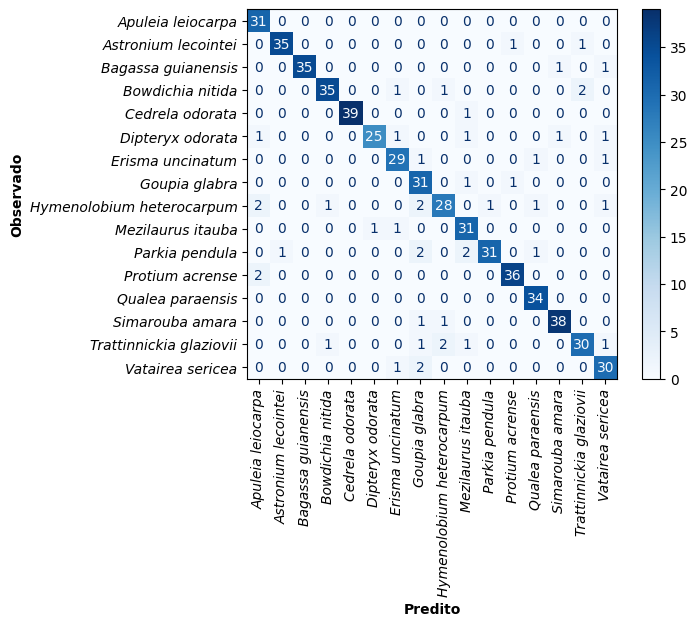

In [ ]:
# ================================================================================
# Matriz de Confusão - Conjunto de Teste (n = 566) - Voto Majoritário
# ================================================================================
cm_lda = confusion_matrix(resultado_lda['Classe_Observada'], resultado_lda['Classe_Predita'])
disp_lda = ConfusionMatrixDisplay(confusion_matrix = cm_lda, display_labels = best_lda.classes_)
disp_lda.plot(cmap = 'Blues', xticks_rotation = 90)
disp_lda.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_lda.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_lda.ax_.xaxis.set_tick_params(labelsize=10)
disp_lda.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output_patches/CNN/CM/cm_resnet_lda', dpi=800, bbox_inches='tight')
plt.show()

## **VGG16**

In [ ]:
#-----------------------------------------------------------------------------#
# Carregar o arquivo .npz
#-----------------------------------------------------------------------------#
with np.load('./Output_patches/CNN/Features/patches_vgg16_train.npz', mmap_mode= 'r', allow_pickle=True) as f:
    X_train = f['X_train']
    y_train = f['y_train']

with np.load('./Output_patches/CNN/Features/patches_vgg16_test.npz', mmap_mode= 'r', allow_pickle=True) as f:
    X_test = f['X_test']
    y_test = f['y_test']

In [ ]:
print('Conjunto de treinamento VGG16:')
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print('Conjunto de teste VGG16:')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

Conjunto de treinamento VGG16:
X_train: (111850, 512)
y_train: (111850, 5)
Conjunto de teste VGG16:
X_test: (28300, 512)
y_test: (28300, 5)


In [ ]:
#-----------------------------------------------------------------------------#
# Dividindo variáveis
#-----------------------------------------------------------------------------#

dic = { 0: 'Patch', 1: 'Class', 2: 'Sample', 3: 'Id', 4:'Dev'}
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

# Renomeando as colunas
y_train.rename(columns=dic, inplace=True)
y_test.rename(columns=dic, inplace=True)

display(y_train)

In [ ]:
#-----------------------------------------------------------------------------#
# Gerando coluna de código de patches
#-----------------------------------------------------------------------------#

y_test['Id'] = y_test['Dev'] + '_' + y_test['Sample'].astype(str) + '_' + y_test['Id'].astype(str)
y_train['Id'] = y_train['Dev'] + '_' + y_train['Sample'].astype(str) + '_' + y_train['Id'].astype(str)
z_train = y_train.filter(items = ['Id'])
y_train = y_train.filter(items = ['Class', 'Sample'])
display(y_test)

In [ ]:
#-----------------------------------------------------------------------------#
# Convertendo códigos - Label encoder
#-----------------------------------------------------------------------------#
'''Para inserir o código das amostras e dos patches na CV foi necessário codificar os patches e as amostras.'''

def converter_variaveis_objeto_para_int(df):
    # Inicialize o LabelEncoder
    label_encoder = LabelEncoder()

    # Itere sobre as colunas do DataFrame
    for coluna in df.columns:
        # Verifique se a coluna é do tipo 'object'
        if df[coluna].dtype == 'object':
            # Ajuste e transforme os dados usando o LabelEncoder
            df[coluna] = label_encoder.fit_transform(df[coluna])

    return df

z_train = converter_variaveis_objeto_para_int(df = z_train)
y_train = pd.concat([y_train, z_train], axis = 1)
z_train = y_train['Sample'].astype(str) + '_' + y_train['Id'].astype(str)
z_train

### Artificial Neural Networks - ANN

In [ ]:
# ================================================================================
# Definições do estimador ANN
# ================================================================================

rs_resnet_ann = pickle.load(open("./Output/CNN/Models/rs_vgg16_ann.pickle", "rb"))
best_ann = rs_resnet_ann.best_estimator_
best_ann.get_params()

In [ ]:
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []


for i, (train_index, test_index) in enumerate(cv.split(X_train, y_train['Class'], groups= z_train)):
  print(f'Criando fold {i+1} >>>')
  print('='*70)

  print(f'Conjunto de treino antes da divisão: {X_train.shape}')
  print(f'Conjunto de validação antes da divisão: {X_train.shape}')

  # Separando fold de treino e validação
  x_train_fold, x_test_fold = X_train[train_index], X_train[test_index]
  y_train_fold, y_test_fold = y_train['Class'].iloc[train_index], y_train['Class'].iloc[test_index]
  z_train_fold = [name.split('_')[0] for name in z_train.iloc[train_index]]
  z_test_fold = [name.split('_')[0] for name in z_train.iloc[test_index]]
  w_train_fold = [name.split('_')[1] for name in z_train.iloc[train_index]]
  w_test_fold = [name.split('_')[1] for name in z_train.iloc[test_index]]

  print(f'Conjunto de treino após divisão: {x_train_fold.shape}')
  print(f'Conjunto de validação após divisão: {x_test_fold.shape}')
  print('='*70)
  print(f'Treinando fold {i+1} >>>')

  # Ajuste do modelo para cada fold
  best_ann.fit(x_train_fold, y_train_fold)

  print('='*70)
  print(f'Fazendo previsões para o fold {i+1}>>>')
  # Colete previsões para este fold
  fold_predictions = best_ann.predict_proba(x_test_fold)

  # Soma das probabilidades das classes dentro de cada grupo(w_test_fold)
  fold_predictions = pd.DataFrame(fold_predictions, columns=best_ann.classes_)
  fold_predictions = fold_predictions.groupby(w_test_fold).sum()

  # Encontrando classe com maior probabilidade para cada grupo(w_test_fold)
  fold_predictions = fold_predictions.idxmax(axis=1)

  # Obtain the observed class for each group(w_test_fold)
  fold_obs = y_test_fold.groupby(w_test_fold).first()

  # Obtendo métricas por fold
  accuracy_fold = accuracy_score(fold_obs, fold_predictions)
  f1_fold = f1_score(fold_obs, fold_predictions, average='weighted')
  recall_fold = recall_score(fold_obs, fold_predictions, average='weighted')
  precision_fold = precision_score(fold_obs, fold_predictions, average='weighted')

  print('='*70)
  print(f'Listando métricas para o fold {i+1}>>>')
  # Listando métricas
  accuracy_scores.append(accuracy_fold)
  f1_scores.append(f1_fold)
  recall_scores.append(recall_fold)
  precision_scores.append(precision_fold)

  print(f'Fold {i+1} finalizado!!!')
  print('*'*70)

# Salvando o modelo
print('='*70)
print('Salvando modelo...')
save_model_pickle(best_ann, 'best_vgg16_ann')
save_model_joblib(best_ann, 'best_vgg16_ann')

print('MODELO SALVO!')

In [ ]:
#===============================================================================
# Visualizando métricas por fold - Conjunto de Validação - Voto Majoritário
#===============================================================================

print('='*70)
print("Métricas por fold:")
print('='*70)
for i in range(len(accuracy_scores)):
    print(f"Fold {i+1}: Accuracy={accuracy_scores[i]:.4f}, F1={f1_scores[i]:.4f}, Recall={recall_scores[i]:.4f}, Precision={precision_scores[i]:.4f}")

# Calculando média das métricas
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
min_acc = np.min(accuracy_scores)
max_acc = np.max(accuracy_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
min_f1 = np.min(f1_scores)
max_f1 = np.max(f1_scores)
mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)
min_recall = np.min(recall_scores)
max_recall = np.max(recall_scores)
mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
min_precision = np.min(precision_scores)
max_precision = np.max(precision_scores)

print('='*70)
print("Mean -- Standard Deviation -- Minimum Value -- Maximum Value")
print('='*70)
# Visualizando média das métricas
print(f"Accuracy -> mean: {mean_accuracy:.4f}, std: {std_accuracy:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"F1 Score -> mean: {mean_f1:.4f}, std: {std_f1:.4f}, min: {min_f1:.4f}, max: {max_f1:.4f}")
print(f"Recall -> mean: {mean_recall:.4f}, std: {std_recall:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"Precision -> mean: {mean_precision:.4f}, std: {std_precision:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")

Métricas por fold:
Fold 1: Accuracy=0.9286, F1=0.9284, Recall=0.9286, Precision=0.9352
Fold 2: Accuracy=0.9375, F1=0.9385, Recall=0.9375, Precision=0.9453
Fold 3: Accuracy=0.9375, F1=0.9362, Recall=0.9375, Precision=0.9416
Fold 4: Accuracy=0.8705, F1=0.8686, Recall=0.8705, Precision=0.8797
Fold 5: Accuracy=0.9062, F1=0.9062, Recall=0.9062, Precision=0.9101
Fold 6: Accuracy=0.9193, F1=0.9199, Recall=0.9193, Precision=0.9253
Fold 7: Accuracy=0.9062, F1=0.9061, Recall=0.9062, Precision=0.9173
Fold 8: Accuracy=0.9462, F1=0.9463, Recall=0.9462, Precision=0.9530
Fold 9: Accuracy=0.9062, F1=0.9031, Recall=0.9062, Precision=0.9158
Fold 10: Accuracy=0.8700, F1=0.8677, Recall=0.8700, Precision=0.8868
Mean -- Standard Deviation -- Minimum Value -- Maximum Value
Accuracy -> mean: 0.9128, std: 0.0253, min: 0.8700, max: 0.9462
F1 Score -> mean: 0.9121, std: 0.0261, min: 0.8677, max: 0.9463
Recall -> mean: 0.9128, std: 0.0253, min: 0.8700, max: 0.9462
Precision -> mean: 0.9210, std: 0.0230, min: 0.87

In [ ]:
#===============================================================================
# Obtendo tabela de probabilidades - 28300 patches de imagens
#===============================================================================

prob_ann = best_ann.predict_proba(X_test)
prob_ann = pd.DataFrame(prob_ann, columns = best_ann.classes_)
class_value = prob_ann.idxmax(axis=1)
prob_value = prob_ann.max(axis=1)

# Obtendo tabela de classes preditas e observadas
prob_ann = pd.DataFrame({'Classe_Predita': class_value, 'Probabilidade': prob_value})
prob_ann = pd.concat([y_test, prob_ann], axis = 1)
prob_ann

In [ ]:
#===============================================================================
# Obtendo resultado por Voto Majoritário (n= 566)
#===============================================================================

# Agrupar os dados por 'Id' e calcular a soma das probabilidades para cada classe
soma_prob_ann = prob_ann.groupby('Id').apply(lambda x: x.groupby('Classe_Predita')['Probabilidade'].sum())

#Para cada grupo de 'Id', selecionar a classe com a maior soma de probabilidades
class_ann = soma_prob_ann.groupby('Id').idxmax()

#Obter a classe observada para cada grupo de 'Id'
class_obs_ann = prob_ann.groupby('Id')['Class'].first()

# Criar um DataFrame com as informações de interesse
resultado_ann = pd.DataFrame({'Id': class_ann.index,
                          'Probabilidade': soma_prob_ann.groupby('Id').max(),
                          'Classe_Predita': class_ann.values,
                          'Classe_Observada': class_obs_ann.values})

# Exibir o resultado
resultado_ann = resultado_ann[['Probabilidade', 'Classe_Predita', 'Classe_Observada']]
# Extrair apenas o nome da classe predita
resultado_ann['Classe_Predita'] = resultado_ann['Classe_Predita'].apply(lambda x: x[1])
resultado_ann

In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================
print(classification_report(resultado_ann['Classe_Observada'], resultado_ann['Classe_Predita'], target_names= best_ann.classes_))

                           precision    recall  f1-score   support

        Apuleia leiocarpa       0.81      0.97      0.88        31
      Astronium lecointei       0.92      0.92      0.92        37
       Bagassa guianensis       0.88      0.97      0.92        37
         Bowdichia nitida       0.95      0.95      0.95        39
          Cedrela odorata       0.87      1.00      0.93        40
         Dipteryx odorata       0.90      0.93      0.92        30
         Erisma uncinatum       0.85      0.72      0.78        32
            Goupia glabra       0.78      0.76      0.77        33
Hymenolobium heterocarpum       0.86      0.89      0.88        36
        Mezilaurus itauba       0.89      0.76      0.82        33
           Parkia pendula       0.94      0.92      0.93        37
          Protium acrense       0.90      0.92      0.91        38
         Qualea paraensis       0.97      0.82      0.89        34
          Simarouba amara       0.89      0.97      0.93     

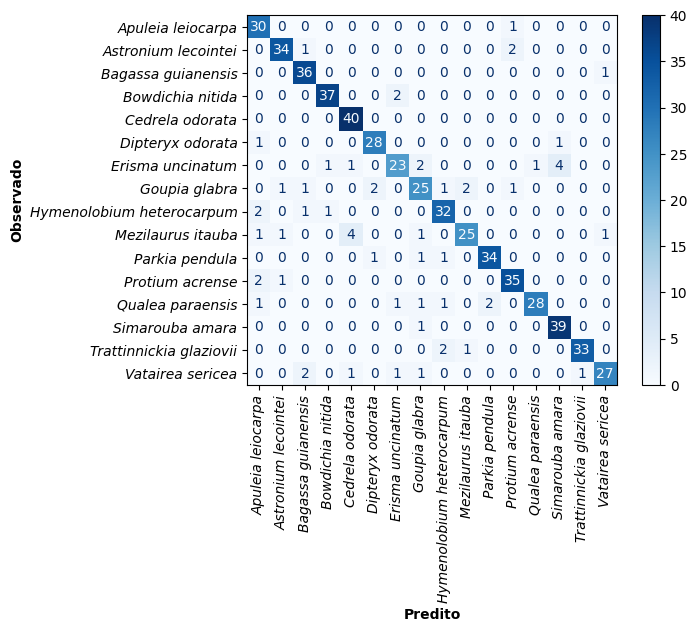

In [ ]:
# ================================================================================
# Matriz de Confusão - Conjunto de Teste (n = 566) - Voto Majoritário
# ================================================================================
cm_ann = confusion_matrix(resultado_ann['Classe_Observada'], resultado_ann['Classe_Predita'])
disp_ann = ConfusionMatrixDisplay(confusion_matrix = cm_ann, display_labels = best_ann.classes_)
disp_ann.plot(cmap = 'Blues', xticks_rotation = 90)
disp_ann.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_ann.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_ann.ax_.xaxis.set_tick_params(labelsize=10)
disp_ann.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output_patches/CNN/CM/cm_vgg16_ann', dpi=800, bbox_inches='tight')
plt.show()

### Suport Vector Classifier - SVC

In [ ]:
# ================================================================================
# Definições do estimador SVC
# ================================================================================

rs_resnet_svc = pickle.load(open("./Output/CNN/Models/rs_vgg16_svc.pickle", "rb"))
best_svc = rs_resnet_svc.best_estimator_
best_svc.get_params()

In [ ]:
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []


for i, (train_index, test_index) in enumerate(cv.split(X_train, y_train['Class'], groups= z_train)):
  print(f'Criando fold {i+1} >>>')
  print('='*70)

  print(f'Conjunto de treino antes da divisão: {X_train.shape}')
  print(f'Conjunto de validação antes da divisão: {X_train.shape}')

  # Separando fold de treino e validação
  x_train_fold, x_test_fold = X_train[train_index], X_train[test_index]
  y_train_fold, y_test_fold = y_train['Class'].iloc[train_index], y_train['Class'].iloc[test_index]
  z_train_fold = [name.split('_')[0] for name in z_train.iloc[train_index]]
  z_test_fold = [name.split('_')[0] for name in z_train.iloc[test_index]]
  w_train_fold = [name.split('_')[1] for name in z_train.iloc[train_index]]
  w_test_fold = [name.split('_')[1] for name in z_train.iloc[test_index]]

  print(f'Conjunto de treino após divisão: {x_train_fold.shape}')
  print(f'Conjunto de validação após divisão: {x_test_fold.shape}')
  print('='*70)
  print(f'Treinando fold {i+1} >>>')

  # Ajuste do modelo para cada fold
  best_svc.fit(x_train_fold, y_train_fold)

  print('='*70)
  print(f'Fazendo previsões para o fold {i+1}>>>')
  # Colete previsões para este fold
  fold_predictions = best_svc.predict_proba(x_test_fold)

  # Soma das probabilidades das classes dentro de cada grupo(w_test_fold)
  fold_predictions = pd.DataFrame(fold_predictions, columns=best_svc.classes_)
  fold_predictions = fold_predictions.groupby(w_test_fold).sum()

  # Encontrando classe com maior probabilidade para cada grupo(w_test_fold)
  fold_predictions = fold_predictions.idxmax(axis=1)

  # Obtain the observed class for each group(w_test_fold)
  fold_obs = y_test_fold.groupby(w_test_fold).first()

  # Obtendo métricas por fold
  accuracy_fold = accuracy_score(fold_obs, fold_predictions)
  f1_fold = f1_score(fold_obs, fold_predictions, average='weighted')
  recall_fold = recall_score(fold_obs, fold_predictions, average='weighted')
  precision_fold = precision_score(fold_obs, fold_predictions, average='weighted')

  print('='*70)
  print(f'Listando métricas para o fold {i+1}>>>')
  # Listando métricas
  accuracy_scores.append(accuracy_fold)
  f1_scores.append(f1_fold)
  recall_scores.append(recall_fold)
  precision_scores.append(precision_fold)

  print(f'Fold {i+1} finalizado!!!')
  print('*'*70)

# Salvando o modelo
print('='*70)
print('Salvando modelo...')
save_model_pickle(best_svc, 'best_vgg16_svc')
save_model_joblib(best_svc, 'best_vgg16_svc')

print('MODELO SALVO!')

In [ ]:
#===============================================================================
# Visualizando métricas por fold - Conjunto de Validação - Voto Majoritário
#===============================================================================

print('='*70)
print("Métricas por fold:")
print('='*70)
for i in range(len(accuracy_scores)):
    print(f"Fold {i+1}: Accuracy={accuracy_scores[i]:.4f}, F1={f1_scores[i]:.4f}, Recall={recall_scores[i]:.4f}, Precision={precision_scores[i]:.4f}")

# Calculando média das métricas
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
min_acc = np.min(accuracy_scores)
max_acc = np.max(accuracy_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
min_f1 = np.min(f1_scores)
max_f1 = np.max(f1_scores)
mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)
min_recall = np.min(recall_scores)
max_recall = np.max(recall_scores)
mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
min_precision = np.min(precision_scores)
max_precision = np.max(precision_scores)

print('='*70)
print("Mean -- Standard Deviation -- Minimum Value -- Maximum Value")
print('='*70)
# Visualizando média das métricas
print(f"Accuracy -> mean: {mean_accuracy:.4f}, std: {std_accuracy:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"F1 Score -> mean: {mean_f1:.4f}, std: {std_f1:.4f}, min: {min_f1:.4f}, max: {max_f1:.4f}")
print(f"Recall -> mean: {mean_recall:.4f}, std: {std_recall:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"Precision -> mean: {mean_precision:.4f}, std: {std_precision:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")

Métricas por fold:
Fold 1: Accuracy=0.9286, F1=0.9278, Recall=0.9286, Precision=0.9323
Fold 2: Accuracy=0.9286, F1=0.9293, Recall=0.9286, Precision=0.9360
Fold 3: Accuracy=0.9286, F1=0.9277, Recall=0.9286, Precision=0.9323
Fold 4: Accuracy=0.9018, F1=0.9016, Recall=0.9018, Precision=0.9101
Fold 5: Accuracy=0.8929, F1=0.8943, Recall=0.8929, Precision=0.9049
Fold 6: Accuracy=0.9148, F1=0.9150, Recall=0.9148, Precision=0.9195
Fold 7: Accuracy=0.9241, F1=0.9231, Recall=0.9241, Precision=0.9274
Fold 8: Accuracy=0.9148, F1=0.9148, Recall=0.9148, Precision=0.9188
Fold 9: Accuracy=0.9107, F1=0.9098, Recall=0.9107, Precision=0.9156
Fold 10: Accuracy=0.8969, F1=0.8951, Recall=0.8969, Precision=0.9081
Mean -- Standard Deviation -- Minimum Value -- Maximum Value
Accuracy -> mean: 0.9142, std: 0.0128, min: 0.8929, max: 0.9286
F1 Score -> mean: 0.9138, std: 0.0127, min: 0.8943, max: 0.9293
Recall -> mean: 0.9142, std: 0.0128, min: 0.8929, max: 0.9286
Precision -> mean: 0.9205, std: 0.0105, min: 0.89

In [ ]:
#===============================================================================
# Obtendo tabela de probabilidades - 28300 patches de imagens
#===============================================================================

prob_svc = best_svc.predict_proba(X_test)
prob_svc = pd.DataFrame(prob_svc, columns = best_svc.classes_)
class_value = prob_svc.idxmax(axis=1)
prob_value = prob_svc.max(axis=1)

# Obtendo tabela de classes preditas e observadas
prob_svc = pd.DataFrame({'Classe_Predita': class_value, 'Probabilidade': prob_value})
prob_svc = pd.concat([y_test, prob_svc], axis = 1)
prob_svc

In [ ]:
#===============================================================================
# Obtendo resultado por Voto Majoritário (n= 566)
#===============================================================================

# Agrupar os dados por 'Id' e calcular a soma das probabilidades para cada classe
soma_prob_svc = prob_svc.groupby('Id').apply(lambda x: x.groupby('Classe_Predita')['Probabilidade'].sum())

#Para cada grupo de 'Id', selecionar a classe com a maior soma de probabilidades
class_svc = soma_prob_svc.groupby('Id').idxmax()

#Obter a classe observada para cada grupo de 'Id'
class_obs_svc = prob_svc.groupby('Id')['Class'].first()

# Criar um DataFrame com as informações de interesse
resultado_svc = pd.DataFrame({'Id': class_svc.index,
                          'Probabilidade': soma_prob_svc.groupby('Id').max(),
                          'Classe_Predita': class_svc.values,
                          'Classe_Observada': class_obs_svc.values})

# Exibir o resultado
resultado_svc = resultado_svc[['Probabilidade', 'Classe_Predita', 'Classe_Observada']]
# Extrair apenas o nome da classe predita
resultado_svc['Classe_Predita'] = resultado_svc['Classe_Predita'].apply(lambda x: x[1])
resultado_svc

In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================
print(classification_report(resultado_svc['Classe_Observada'], resultado_svc['Classe_Predita'], target_names= best_svc.classes_))

                           precision    recall  f1-score   support

        Apuleia leiocarpa       0.78      0.90      0.84        31
      Astronium lecointei       0.90      0.95      0.92        37
       Bagassa guianensis       1.00      0.97      0.99        37
         Bowdichia nitida       1.00      0.90      0.95        39
          Cedrela odorata       1.00      1.00      1.00        40
         Dipteryx odorata       0.85      0.77      0.81        30
         Erisma uncinatum       0.85      0.88      0.86        32
            Goupia glabra       0.72      0.79      0.75        33
Hymenolobium heterocarpum       0.91      0.83      0.87        36
        Mezilaurus itauba       0.94      0.94      0.94        33
           Parkia pendula       1.00      0.92      0.96        37
          Protium acrense       0.90      0.92      0.91        38
         Qualea paraensis       0.92      0.97      0.94        34
          Simarouba amara       0.93      0.95      0.94     

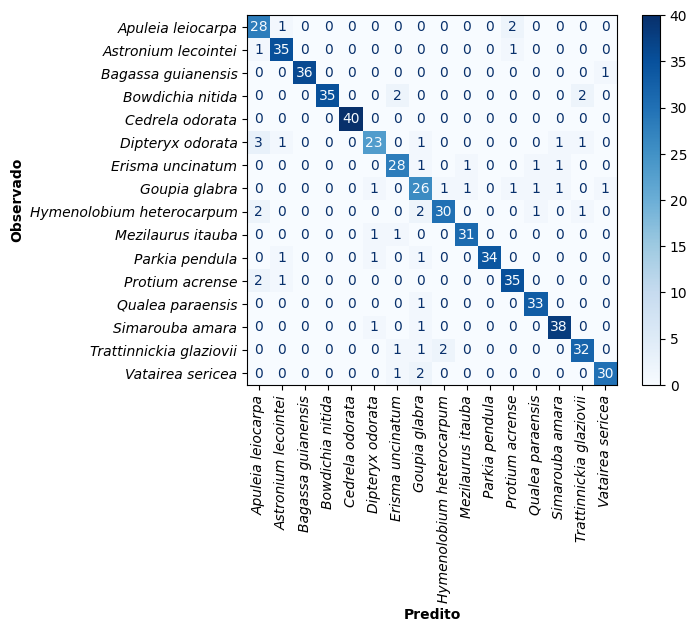

In [ ]:
# ================================================================================
# Matriz de Confusão - Conjunto de Teste (n = 566) - Voto Majoritário
# ================================================================================
cm_svc = confusion_matrix(resultado_svc['Classe_Observada'], resultado_svc['Classe_Predita'])
disp_svc = ConfusionMatrixDisplay(confusion_matrix = cm_svc, display_labels = best_svc.classes_)
disp_svc.plot(cmap = 'Blues', xticks_rotation = 90)
disp_svc.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_svc.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_svc.ax_.xaxis.set_tick_params(labelsize=10)
disp_svc.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output_patches/CNN/CM/cm_vgg16_svc', dpi=800, bbox_inches='tight')
plt.show()

### Random Forest - RF

In [ ]:
# ================================================================================
# Definições do estimador RF
# ================================================================================

rs_resnet_rf = pickle.load(open("./Output/CNN/Models/rs_vgg16_rf.pickle", "rb"))
best_rf = rs_resnet_rf.best_estimator_
best_rf.get_params()

In [ ]:
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []


for i, (train_index, test_index) in enumerate(cv.split(X_train, y_train['Class'], groups= z_train)):
  print(f'Criando fold {i+1} >>>')
  print('='*70)

  print(f'Conjunto de treino antes da divisão: {X_train.shape}')
  print(f'Conjunto de validação antes da divisão: {X_train.shape}')

  # Separando fold de treino e validação
  x_train_fold, x_test_fold = X_train[train_index], X_train[test_index]
  y_train_fold, y_test_fold = y_train['Class'].iloc[train_index], y_train['Class'].iloc[test_index]
  z_train_fold = [name.split('_')[0] for name in z_train.iloc[train_index]]
  z_test_fold = [name.split('_')[0] for name in z_train.iloc[test_index]]
  w_train_fold = [name.split('_')[1] for name in z_train.iloc[train_index]]
  w_test_fold = [name.split('_')[1] for name in z_train.iloc[test_index]]

  print(f'Conjunto de treino após divisão: {x_train_fold.shape}')
  print(f'Conjunto de validação após divisão: {x_test_fold.shape}')
  print('='*70)
  print(f'Treinando fold {i+1} >>>')

  # Ajuste do modelo para cada fold
  best_rf.fit(x_train_fold, y_train_fold)

  print('='*70)
  print(f'Fazendo previsões para o fold {i+1}>>>')
  # Colete previsões para este fold
  fold_predictions = best_rf.predict_proba(x_test_fold)

  # Soma das probabilidades das classes dentro de cada grupo(w_test_fold)
  fold_predictions = pd.DataFrame(fold_predictions, columns=best_rf.classes_)
  fold_predictions = fold_predictions.groupby(w_test_fold).sum()

  # Encontrando classe com maior probabilidade para cada grupo(w_test_fold)
  fold_predictions = fold_predictions.idxmax(axis=1)

  # Obtain the observed class for each group(w_test_fold)
  fold_obs = y_test_fold.groupby(w_test_fold).first()

  # Obtendo métricas por fold
  accuracy_fold = accuracy_score(fold_obs, fold_predictions)
  f1_fold = f1_score(fold_obs, fold_predictions, average='weighted')
  recall_fold = recall_score(fold_obs, fold_predictions, average='weighted')
  precision_fold = precision_score(fold_obs, fold_predictions, average='weighted')

  print('='*70)
  print(f'Listando métricas para o fold {i+1}>>>')
  # Listando métricas
  accuracy_scores.append(accuracy_fold)
  f1_scores.append(f1_fold)
  recall_scores.append(recall_fold)
  precision_scores.append(precision_fold)

  print(f'Fold {i+1} finalizado!!!')
  print('*'*70)

# Salvando o modelo
print('='*70)
print('Salvando modelo...')
save_model_pickle(best_rf, 'best_vgg16_rf')
save_model_joblib(best_rf, 'best_vgg16_rf')

print('MODELO SALVO!')

In [ ]:
#===============================================================================
# Visualizando métricas por fold - Conjunto de Validação - Voto Majoritário
#===============================================================================

print('='*70)
print("Métricas por fold:")
print('='*70)
for i in range(len(accuracy_scores)):
    print(f"Fold {i+1}: Accuracy={accuracy_scores[i]:.4f}, F1={f1_scores[i]:.4f}, Recall={recall_scores[i]:.4f}, Precision={precision_scores[i]:.4f}")

# Calculando média das métricas
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
min_acc = np.min(accuracy_scores)
max_acc = np.max(accuracy_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
min_f1 = np.min(f1_scores)
max_f1 = np.max(f1_scores)
mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)
min_recall = np.min(recall_scores)
max_recall = np.max(recall_scores)
mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
min_precision = np.min(precision_scores)
max_precision = np.max(precision_scores)

print('='*70)
print("Mean -- Standard Deviation -- Minimum Value -- Maximum Value")
print('='*70)
# Visualizando média das métricas
print(f"Accuracy -> mean: {mean_accuracy:.4f}, std: {std_accuracy:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"F1 Score -> mean: {mean_f1:.4f}, std: {std_f1:.4f}, min: {min_f1:.4f}, max: {max_f1:.4f}")
print(f"Recall -> mean: {mean_recall:.4f}, std: {std_recall:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"Precision -> mean: {mean_precision:.4f}, std: {std_precision:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")

Métricas por fold:
Fold 1: Accuracy=0.8170, F1=0.8089, Recall=0.8170, Precision=0.8422
Fold 2: Accuracy=0.8527, F1=0.8499, Recall=0.8527, Precision=0.8701
Fold 3: Accuracy=0.8482, F1=0.8475, Recall=0.8482, Precision=0.8612
Fold 4: Accuracy=0.7500, F1=0.7366, Recall=0.7500, Precision=0.7466
Fold 5: Accuracy=0.7812, F1=0.7802, Recall=0.7812, Precision=0.8052
Fold 6: Accuracy=0.8027, F1=0.7980, Recall=0.8027, Precision=0.8189
Fold 7: Accuracy=0.8170, F1=0.8129, Recall=0.8170, Precision=0.8369
Fold 8: Accuracy=0.8296, F1=0.8271, Recall=0.8296, Precision=0.8346
Fold 9: Accuracy=0.8125, F1=0.8082, Recall=0.8125, Precision=0.8314
Fold 10: Accuracy=0.7713, F1=0.7619, Recall=0.7713, Precision=0.7714
Mean -- Standard Deviation -- Minimum Value -- Maximum Value
Accuracy -> mean: 0.8082, std: 0.0312, min: 0.7500, max: 0.8527
F1 Score -> mean: 0.8031, std: 0.0340, min: 0.7366, max: 0.8499
Recall -> mean: 0.8082, std: 0.0312, min: 0.7500, max: 0.8527
Precision -> mean: 0.8218, std: 0.0364, min: 0.75

In [ ]:
#===============================================================================
# Obtendo tabela de probabilidades - 28300 patches de imagens
#===============================================================================

prob_rf = best_rf.predict_proba(X_test)
prob_rf = pd.DataFrame(prob_rf, columns = best_rf.classes_)
class_value = prob_rf.idxmax(axis=1)
prob_value = prob_rf.max(axis=1)

# Obtendo tabela de classes preditas e observadas
prob_rf = pd.DataFrame({'Classe_Predita': class_value, 'Probabilidade': prob_value})
prob_rf = pd.concat([y_test, prob_rf], axis = 1)
prob_rf

In [ ]:
#===============================================================================
# Obtendo resultado por Voto Majoritário (n= 566)
#===============================================================================

# Agrupar os dados por 'Id' e calcular a soma das probabilidades para cada classe
soma_prob_rf = prob_rf.groupby('Id').apply(lambda x: x.groupby('Classe_Predita')['Probabilidade'].sum())

#Para cada grupo de 'Id', selecionar a classe com a maior soma de probabilidades
class_rf = soma_prob_rf.groupby('Id').idxmax()

#Obter a classe observada para cada grupo de 'Id'
class_obs_rf = prob_rf.groupby('Id')['Class'].first()

# Criar um DataFrame com as informações de interesse
resultado_rf = pd.DataFrame({'Id': class_rf.index,
                          'Probabilidade': soma_prob_rf.groupby('Id').max(),
                          'Classe_Predita': class_rf.values,
                          'Classe_Observada': class_obs_rf.values})

# Exibir o resultado
resultado_rf = resultado_rf[['Probabilidade', 'Classe_Predita', 'Classe_Observada']]
# Extrair apenas o nome da classe predita
resultado_rf['Classe_Predita'] = resultado_rf['Classe_Predita'].apply(lambda x: x[1])
resultado_rf

In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================
print(classification_report(resultado_rf['Classe_Observada'], resultado_rf['Classe_Predita'], target_names= best_rf.classes_))

                           precision    recall  f1-score   support

        Apuleia leiocarpa       0.68      0.90      0.78        31
      Astronium lecointei       0.77      0.89      0.82        37
       Bagassa guianensis       0.84      0.84      0.84        37
         Bowdichia nitida       0.97      0.82      0.89        39
          Cedrela odorata       0.89      1.00      0.94        40
         Dipteryx odorata       0.67      0.47      0.55        30
         Erisma uncinatum       0.69      0.91      0.78        32
            Goupia glabra       0.59      0.82      0.68        33
Hymenolobium heterocarpum       1.00      0.47      0.64        36
        Mezilaurus itauba       0.95      0.58      0.72        33
           Parkia pendula       0.86      0.84      0.85        37
          Protium acrense       0.81      0.89      0.85        38
         Qualea paraensis       0.84      0.79      0.82        34
          Simarouba amara       0.88      0.90      0.89     

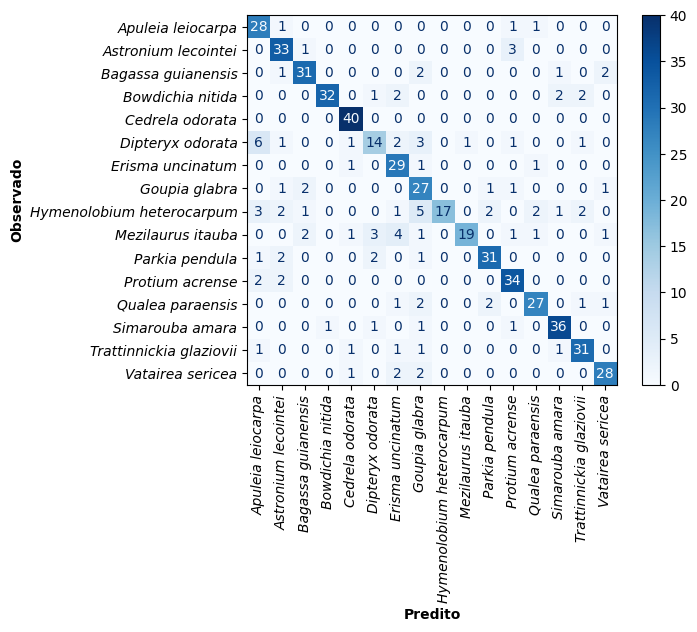

In [ ]:
# ================================================================================
# Matriz de Confusão - Conjunto de Teste (n = 566) - Voto Majoritário
# ================================================================================
cm_rf = confusion_matrix(resultado_rf['Classe_Observada'], resultado_rf['Classe_Predita'])
disp_rf = ConfusionMatrixDisplay(confusion_matrix = cm_rf, display_labels = best_rf.classes_)
disp_rf.plot(cmap = 'Blues', xticks_rotation = 90)
disp_rf.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_rf.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_rf.ax_.xaxis.set_tick_params(labelsize=10)
disp_rf.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output_patches/CNN/CM/cm_vgg16_rf', dpi=800, bbox_inches='tight')
plt.show()

### Linear Discriminant Analysis - LDA

In [ ]:
# ================================================================================
# Definições do estimador LDA
# ================================================================================

rs_resnet_lda = pickle.load(open("./Output/CNN/Models/rs_vgg16_lda.pickle", "rb"))
best_lda = rs_resnet_lda.best_estimator_
best_lda.get_params()

In [ ]:
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []


for i, (train_index, test_index) in enumerate(cv.split(X_train, y_train['Class'], groups= z_train)):
  print(f'Criando fold {i+1} >>>')
  print('='*70)

  print(f'Conjunto de treino antes da divisão: {X_train.shape}')
  print(f'Conjunto de validação antes da divisão: {X_train.shape}')

  # Separando fold de treino e validação
  x_train_fold, x_test_fold = X_train[train_index], X_train[test_index]
  y_train_fold, y_test_fold = y_train['Class'].iloc[train_index], y_train['Class'].iloc[test_index]
  z_train_fold = [name.split('_')[0] for name in z_train.iloc[train_index]]
  z_test_fold = [name.split('_')[0] for name in z_train.iloc[test_index]]
  w_train_fold = [name.split('_')[1] for name in z_train.iloc[train_index]]
  w_test_fold = [name.split('_')[1] for name in z_train.iloc[test_index]]

  print(f'Conjunto de treino após divisão: {x_train_fold.shape}')
  print(f'Conjunto de validação após divisão: {x_test_fold.shape}')
  print('='*70)
  print(f'Treinando fold {i+1} >>>')

  # Ajuste do modelo para cada fold
  best_lda.fit(x_train_fold, y_train_fold)

  print('='*70)
  print(f'Fazendo previsões para o fold {i+1}>>>')
  # Colete previsões para este fold
  fold_predictions = best_lda.predict_proba(x_test_fold)

  # Soma das probabilidades das classes dentro de cada grupo(w_test_fold)
  fold_predictions = pd.DataFrame(fold_predictions, columns=best_lda.classes_)
  fold_predictions = fold_predictions.groupby(w_test_fold).sum()

  # Encontrando classe com maior probabilidade para cada grupo(w_test_fold)
  fold_predictions = fold_predictions.idxmax(axis=1)

  # Obtain the observed class for each group(w_test_fold)
  fold_obs = y_test_fold.groupby(w_test_fold).first()

  # Obtendo métricas por fold
  accuracy_fold = accuracy_score(fold_obs, fold_predictions)
  f1_fold = f1_score(fold_obs, fold_predictions, average='weighted')
  recall_fold = recall_score(fold_obs, fold_predictions, average='weighted')
  precision_fold = precision_score(fold_obs, fold_predictions, average='weighted')

  print('='*70)
  print(f'Listando métricas para o fold {i+1}>>>')
  # Listando métricas
  accuracy_scores.append(accuracy_fold)
  f1_scores.append(f1_fold)
  recall_scores.append(recall_fold)
  precision_scores.append(precision_fold)

  print(f'Fold {i+1} finalizado!!!')
  print('*'*70)

# Salvando o modelo
print('='*70)
print('Salvando modelo...')
save_model_pickle(best_lda, 'best_vgg16_lda')
save_model_joblib(best_lda, 'best_vgg16_lda')

print('MODELO SALVO!')

In [ ]:
#===============================================================================
# Visualizando métricas por fold - Conjunto de Validação - Voto Majoritário
#===============================================================================

print('='*70)
print("Métricas por fold:")
print('='*70)
for i in range(len(accuracy_scores)):
    print(f"Fold {i+1}: Accuracy={accuracy_scores[i]:.4f}, F1={f1_scores[i]:.4f}, Recall={recall_scores[i]:.4f}, Precision={precision_scores[i]:.4f}")

# Calculando média das métricas
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
min_acc = np.min(accuracy_scores)
max_acc = np.max(accuracy_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
min_f1 = np.min(f1_scores)
max_f1 = np.max(f1_scores)
mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)
min_recall = np.min(recall_scores)
max_recall = np.max(recall_scores)
mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
min_precision = np.min(precision_scores)
max_precision = np.max(precision_scores)

print('='*70)
print("Mean -- Standard Deviation -- Minimum Value -- Maximum Value")
print('='*70)
# Visualizando média das métricas
print(f"Accuracy -> mean: {mean_accuracy:.4f}, std: {std_accuracy:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"F1 Score -> mean: {mean_f1:.4f}, std: {std_f1:.4f}, min: {min_f1:.4f}, max: {max_f1:.4f}")
print(f"Recall -> mean: {mean_recall:.4f}, std: {std_recall:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"Precision -> mean: {mean_precision:.4f}, std: {std_precision:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")

Métricas por fold:
Fold 1: Accuracy=0.7902, F1=0.7867, Recall=0.7902, Precision=0.8048
Fold 2: Accuracy=0.8080, F1=0.8128, Recall=0.8080, Precision=0.8348
Fold 3: Accuracy=0.8482, F1=0.8515, Recall=0.8482, Precision=0.8647
Fold 4: Accuracy=0.7679, F1=0.7698, Recall=0.7679, Precision=0.7912
Fold 5: Accuracy=0.8036, F1=0.8081, Recall=0.8036, Precision=0.8263
Fold 6: Accuracy=0.8161, F1=0.8147, Recall=0.8161, Precision=0.8283
Fold 7: Accuracy=0.7991, F1=0.7994, Recall=0.7991, Precision=0.8143
Fold 8: Accuracy=0.8341, F1=0.8370, Recall=0.8341, Precision=0.8471
Fold 9: Accuracy=0.7991, F1=0.8009, Recall=0.7991, Precision=0.8156
Fold 10: Accuracy=0.7668, F1=0.7652, Recall=0.7668, Precision=0.7774
Mean -- Standard Deviation -- Minimum Value -- Maximum Value
Accuracy -> mean: 0.8033, std: 0.0244, min: 0.7668, max: 0.8482
F1 Score -> mean: 0.8046, std: 0.0256, min: 0.7652, max: 0.8515
Recall -> mean: 0.8033, std: 0.0244, min: 0.7668, max: 0.8482
Precision -> mean: 0.8204, std: 0.0245, min: 0.76

In [ ]:
#===============================================================================
# Obtendo tabela de probabilidades - 28300 patches de imagens
#===============================================================================

prob_lda = best_lda.predict_proba(X_test)
prob_lda = pd.DataFrame(prob_lda, columns = best_lda.classes_)
class_value = prob_lda.idxmax(axis=1)
prob_value = prob_lda.max(axis=1)

# Obtendo tabela de classes preditas e observadas
prob_lda = pd.DataFrame({'Classe_Predita': class_value, 'Probabilidade': prob_value})
prob_lda = pd.concat([y_test, prob_lda], axis = 1)
prob_lda

In [ ]:
#===============================================================================
# Obtendo resultado por Voto Majoritário (n= 566)
#===============================================================================

# Agrupar os dados por 'Id' e calcular a soma das probabilidades para cada classe
soma_prob_lda = prob_lda.groupby('Id').apply(lambda x: x.groupby('Classe_Predita')['Probabilidade'].sum())

#Para cada grupo de 'Id', selecionar a classe com a maior soma de probabilidades
class_lda = soma_prob_lda.groupby('Id').idxmax()

#Obter a classe observada para cada grupo de 'Id'
class_obs_lda = prob_lda.groupby('Id')['Class'].first()

# Criar um DataFrame com as informações de interesse
resultado_lda = pd.DataFrame({'Id': class_lda.index,
                          'Probabilidade': soma_prob_lda.groupby('Id').max(),
                          'Classe_Predita': class_lda.values,
                          'Classe_Observada': class_obs_lda.values})

# Exibir o resultado
resultado_lda = resultado_lda[['Probabilidade', 'Classe_Predita', 'Classe_Observada']]
# Extrair apenas o nome da classe predita
resultado_lda['Classe_Predita'] = resultado_lda['Classe_Predita'].apply(lambda x: x[1])
resultado_lda

In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================
print(classification_report(resultado_lda['Classe_Observada'], resultado_lda['Classe_Predita'], target_names= best_lda.classes_))

                           precision    recall  f1-score   support

        Apuleia leiocarpa       0.76      0.94      0.84        31
      Astronium lecointei       0.74      0.86      0.80        37
       Bagassa guianensis       1.00      0.84      0.91        37
         Bowdichia nitida       0.92      0.85      0.88        39
          Cedrela odorata       0.97      0.97      0.97        40
         Dipteryx odorata       0.70      0.70      0.70        30
         Erisma uncinatum       0.63      0.84      0.72        32
            Goupia glabra       0.65      0.79      0.71        33
Hymenolobium heterocarpum       0.85      0.47      0.61        36
        Mezilaurus itauba       0.86      0.76      0.81        33
           Parkia pendula       0.85      0.76      0.80        37
          Protium acrense       0.92      0.87      0.89        38
         Qualea paraensis       0.74      0.91      0.82        34
          Simarouba amara       0.91      0.75      0.82     

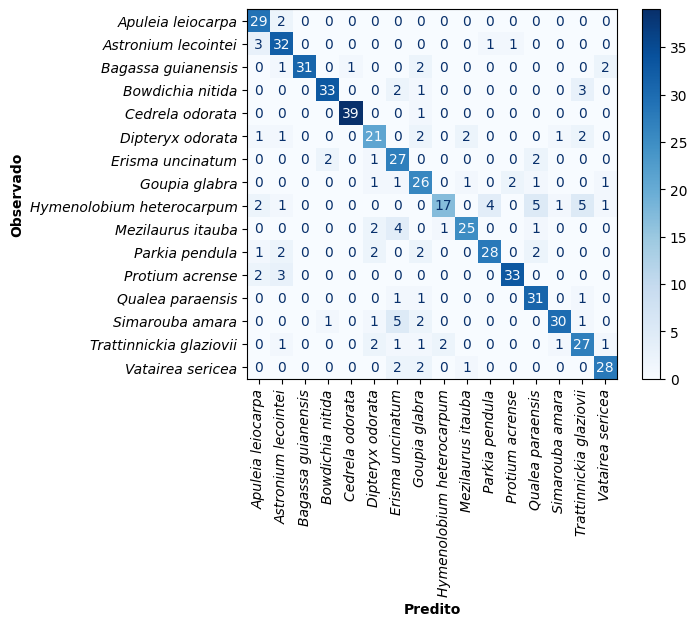

In [ ]:
# ================================================================================
# Matriz de Confusão - Conjunto de Teste (n = 566) - Voto Majoritário
# ================================================================================
cm_lda = confusion_matrix(resultado_lda['Classe_Observada'], resultado_lda['Classe_Predita'])
disp_lda = ConfusionMatrixDisplay(confusion_matrix = cm_lda, display_labels = best_lda.classes_)
disp_lda.plot(cmap = 'Blues', xticks_rotation = 90)
disp_lda.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_lda.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_lda.ax_.xaxis.set_tick_params(labelsize=10)
disp_lda.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output_patches/CNN/CM/cm_vgg16_lda', dpi=800, bbox_inches='tight')
plt.show()

## **Inception_V3**

In [ ]:
#-----------------------------------------------------------------------------#
# Carregar o arquivo .npz
#-----------------------------------------------------------------------------#
with np.load('./Output_patches/CNN/Features/patches_inception_train.npz', mmap_mode= 'r', allow_pickle=True) as f:
    X_train = f['X_train']
    y_train = f['y_train']

with np.load('./Output_patches/CNN/Features/patches_inception_test.npz', mmap_mode= 'r', allow_pickle=True) as f:
    X_test = f['X_test']
    y_test = f['y_test']

In [ ]:
#-----------------------------------------------------------------------------#
# Tamanho do conjunto do vetor de features Inception
#-----------------------------------------------------------------------------#
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: (111850, 2048)
y_train: (111850, 5)
X_test: (28300, 2048)
y_test: (28300, 5)


In [ ]:
#-----------------------------------------------------------------------------#
# Dividindo variáveis
#-----------------------------------------------------------------------------#

dic = { 0: 'Patch', 1: 'Class', 2: 'Sample', 3: 'Id', 4:'Dev'}
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

# Renomeando as colunas
y_train.rename(columns=dic, inplace=True)
y_test.rename(columns=dic, inplace=True)

display(y_train)

In [ ]:
#-----------------------------------------------------------------------------#
# Gerando coluna de código de patches
#-----------------------------------------------------------------------------#

y_test['Id'] = y_test['Dev'] + '_' + y_test['Sample'].astype(str) + '_' + y_test['Id'].astype(str)
y_train['Id'] = y_train['Dev'] + '_' + y_train['Sample'].astype(str) + '_' + y_train['Id'].astype(str)
z_train = y_train.filter(items = ['Id'])
y_train = y_train.filter(items = ['Class', 'Sample'])
display(y_test)

In [ ]:
#-----------------------------------------------------------------------------#
# Convertendo códigos - Label encoder
#-----------------------------------------------------------------------------#
'''Para inserir o código das amostras e dos patches na CV foi necessário codificar os patches e as amostras.'''

def converter_variaveis_objeto_para_int(df):
    # Inicialize o LabelEncoder
    label_encoder = LabelEncoder()

    # Itere sobre as colunas do DataFrame
    for coluna in df.columns:
        # Verifique se a coluna é do tipo 'object'
        if df[coluna].dtype == 'object':
            # Ajuste e transforme os dados usando o LabelEncoder
            df[coluna] = label_encoder.fit_transform(df[coluna])

    return df

z_train = converter_variaveis_objeto_para_int(df = z_train)
y_train = pd.concat([y_train, z_train], axis = 1)
z_train = y_train['Sample'].astype(str) + '_' + y_train['Id'].astype(str)
z_train

### Artificial Neural Networks - ANN

In [ ]:
# ================================================================================
# Definições do estimador ANN
# ================================================================================

rs_resnet_ann = pickle.load(open("./Output/CNN/Models/rs_inception_ann.pickle", "rb"))
best_ann = rs_resnet_ann.best_estimator_
best_ann.get_params()

In [ ]:
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []


for i, (train_index, test_index) in enumerate(cv.split(X_train, y_train['Class'], groups= z_train)):
  print(f'Criando fold {i+1} >>>')
  print('='*70)

  print(f'Conjunto de treino antes da divisão: {X_train.shape}')
  print(f'Conjunto de validação antes da divisão: {X_train.shape}')

  # Separando fold de treino e validação
  x_train_fold, x_test_fold = X_train[train_index], X_train[test_index]
  y_train_fold, y_test_fold = y_train['Class'].iloc[train_index], y_train['Class'].iloc[test_index]
  z_train_fold = [name.split('_')[0] for name in z_train.iloc[train_index]]
  z_test_fold = [name.split('_')[0] for name in z_train.iloc[test_index]]
  w_train_fold = [name.split('_')[1] for name in z_train.iloc[train_index]]
  w_test_fold = [name.split('_')[1] for name in z_train.iloc[test_index]]

  print(f'Conjunto de treino após divisão: {x_train_fold.shape}')
  print(f'Conjunto de validação após divisão: {x_test_fold.shape}')
  print('='*70)
  print(f'Treinando fold {i+1} >>>')

  # Ajuste do modelo para cada fold
  best_ann.fit(x_train_fold, y_train_fold)

  print('='*70)
  print(f'Fazendo previsões para o fold {i+1}>>>')
  # Colete previsões para este fold
  fold_predictions = best_ann.predict_proba(x_test_fold)

  # Soma das probabilidades das classes dentro de cada grupo(w_test_fold)
  fold_predictions = pd.DataFrame(fold_predictions, columns=best_ann.classes_)
  fold_predictions = fold_predictions.groupby(w_test_fold).sum()

  # Encontrando classe com maior probabilidade para cada grupo(w_test_fold)
  fold_predictions = fold_predictions.idxmax(axis=1)

  # Obtain the observed class for each group(w_test_fold)
  fold_obs = y_test_fold.groupby(w_test_fold).first()

  # Obtendo métricas por fold
  accuracy_fold = accuracy_score(fold_obs, fold_predictions)
  f1_fold = f1_score(fold_obs, fold_predictions, average='weighted')
  recall_fold = recall_score(fold_obs, fold_predictions, average='weighted')
  precision_fold = precision_score(fold_obs, fold_predictions, average='weighted')

  print('='*70)
  print(f'Listando métricas para o fold {i+1}>>>')
  # Listando métricas
  accuracy_scores.append(accuracy_fold)
  f1_scores.append(f1_fold)
  recall_scores.append(recall_fold)
  precision_scores.append(precision_fold)

  print(f'Fold {i+1} finalizado!!!')
  print('*'*70)

# Salvando o modelo
print('='*70)
print('Salvando modelo...')
save_model_pickle(best_ann, 'best_inception_ann')
save_model_joblib(best_ann, 'best_inception_ann')

print('MODELO SALVO!')

In [ ]:
#===============================================================================
# Visualizando métricas por fold - Conjunto de Validação - Voto Majoritário
#===============================================================================

print('='*70)
print("Métricas por fold:")
print('='*70)
for i in range(len(accuracy_scores)):
    print(f"Fold {i+1}: Accuracy={accuracy_scores[i]:.4f}, F1={f1_scores[i]:.4f}, Recall={recall_scores[i]:.4f}, Precision={precision_scores[i]:.4f}")

# Calculando média das métricas
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
min_acc = np.min(accuracy_scores)
max_acc = np.max(accuracy_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
min_f1 = np.min(f1_scores)
max_f1 = np.max(f1_scores)
mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)
min_recall = np.min(recall_scores)
max_recall = np.max(recall_scores)
mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
min_precision = np.min(precision_scores)
max_precision = np.max(precision_scores)

print('='*70)
print("Mean -- Standard Deviation -- Minimum Value -- Maximum Value")
print('='*70)
# Visualizando média das métricas
print(f"Accuracy -> mean: {mean_accuracy:.4f}, std: {std_accuracy:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"F1 Score -> mean: {mean_f1:.4f}, std: {std_f1:.4f}, min: {min_f1:.4f}, max: {max_f1:.4f}")
print(f"Recall -> mean: {mean_recall:.4f}, std: {std_recall:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"Precision -> mean: {mean_precision:.4f}, std: {std_precision:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")

In [ ]:
#===============================================================================
# Obtendo tabela de probabilidades - 28300 patches de imagens
#===============================================================================

prob_ann = best_ann.predict_proba(X_test)
prob_ann = pd.DataFrame(prob_ann, columns = best_ann.classes_)
class_value = prob_ann.idxmax(axis=1)
prob_value = prob_ann.max(axis=1)

# Obtendo tabela de classes preditas e observadas
prob_ann = pd.DataFrame({'Classe_Predita': class_value, 'Probabilidade': prob_value})
prob_ann = pd.concat([y_test, prob_ann], axis = 1)
prob_ann

In [ ]:
#===============================================================================
# Obtendo resultado por Voto Majoritário (n= 566)
#===============================================================================

# Agrupar os dados por 'Id' e calcular a soma das probabilidades para cada classe
soma_prob_ann = prob_ann.groupby('Id').apply(lambda x: x.groupby('Classe_Predita')['Probabilidade'].sum())

#Para cada grupo de 'Id', selecionar a classe com a maior soma de probabilidades
class_ann = soma_prob_ann.groupby('Id').idxmax()

#Obter a classe observada para cada grupo de 'Id'
class_obs_ann = prob_ann.groupby('Id')['Class'].first()

# Criar um DataFrame com as informações de interesse
resultado_ann = pd.DataFrame({'Id': class_ann.index,
                          'Probabilidade': soma_prob_ann.groupby('Id').max(),
                          'Classe_Predita': class_ann.values,
                          'Classe_Observada': class_obs_ann.values})

# Exibir o resultado
resultado_ann = resultado_ann[['Probabilidade', 'Classe_Predita', 'Classe_Observada']]
# Extrair apenas o nome da classe predita
resultado_ann['Classe_Predita'] = resultado_ann['Classe_Predita'].apply(lambda x: x[1])
resultado_ann

In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================
print(classification_report(resultado_ann['Classe_Observada'], resultado_ann['Classe_Predita'], target_names= best_ann.classes_))

In [ ]:
# ================================================================================
# Matriz de Confusão - Conjunto de Teste (n = 566) - Voto Majoritário
# ================================================================================
cm_ann = confusion_matrix(resultado_ann['Classe_Observada'], resultado_ann['Classe_Predita'])
disp_ann = ConfusionMatrixDisplay(confusion_matrix = cm_ann, display_labels = best_ann.classes_)
disp_ann.plot(cmap = 'Blues', xticks_rotation = 90)
disp_ann.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_ann.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_ann.ax_.xaxis.set_tick_params(labelsize=10)
disp_ann.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output_patches/cm_inception_ann', dpi=800, bbox_inches='tight')
plt.show()

### Suport Vector Classifier - SVC

In [ ]:
# ================================================================================
# Definições do estimador SVC
# ================================================================================

rs_resnet_svc = pickle.load(open("./Output/CNN/Models/rs_inception_svc.pickle", "rb"))
best_svc = rs_resnet_svc.best_estimator_

In [ ]:
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []

for i, (train_index, test_index) in enumerate(cv.split(X_train, y_train['Class'], groups= z_train)):
  print(f'Criando fold {i+1} >>>')
  print('='*70)

  print(f'Conjunto de treino antes da divisão: {X_train.shape}')
  print(f'Conjunto de validação antes da divisão: {X_train.shape}')

  # Separando fold de treino e validação
  x_train_fold, x_test_fold = X_train[train_index], X_train[test_index]
  y_train_fold, y_test_fold = y_train['Class'].iloc[train_index], y_train['Class'].iloc[test_index]
  z_train_fold = [name.split('_')[0] for name in z_train.iloc[train_index]]
  z_test_fold = [name.split('_')[0] for name in z_train.iloc[test_index]]
  w_train_fold = [name.split('_')[1] for name in z_train.iloc[train_index]]
  w_test_fold = [name.split('_')[1] for name in z_train.iloc[test_index]]

  print(f'Conjunto de treino após divisão: {x_train_fold.shape}')
  print(f'Conjunto de validação após divisão: {x_test_fold.shape}')
  print('='*70)
  print(f'Treinando fold {i+1} >>>')

  # Ajuste do modelo para cada fold
  best_svc.fit(x_train_fold, y_train_fold)

  print('='*70)
  print(f'Fazendo previsões para o fold {i+1}>>>')
  # Colete previsões para este fold
  fold_predictions = best_svc.predict_proba(x_test_fold)

  # Soma das probabilidades das classes dentro de cada grupo(w_test_fold)
  fold_predictions = pd.DataFrame(fold_predictions, columns=best_svc.classes_)
  fold_predictions = fold_predictions.groupby(w_test_fold).sum()

  # Encontrando classe com maior probabilidade para cada grupo(w_test_fold)
  fold_predictions = fold_predictions.idxmax(axis=1)

  # Obtain the observed class for each group(w_test_fold)
  fold_obs = y_test_fold.groupby(w_test_fold).first()

  # Obtendo métricas por fold
  accuracy_fold = accuracy_score(fold_obs, fold_predictions)
  f1_fold = f1_score(fold_obs, fold_predictions, average='weighted')
  recall_fold = recall_score(fold_obs, fold_predictions, average='weighted')
  precision_fold = precision_score(fold_obs, fold_predictions, average='weighted')

  print('='*70)
  print(f'Listando métricas para o fold {i+1}>>>')
  # Listando métricas
  accuracy_scores.append(accuracy_fold)
  f1_scores.append(f1_fold)
  recall_scores.append(recall_fold)
  precision_scores.append(precision_fold)

  print(f'Fold {i+1} finalizado!!!')
  print('*'*70)

# Salvando o modelo
print('='*70)
print('Salvando modelo...')
save_model_pickle(best_svc, 'best_inception_svc')
save_model_joblib(best_svc, 'best_inception_svc')

print('MODELO SALVO!')

In [ ]:
#===============================================================================
# Visualizando métricas por fold - Conjunto de Validação - Voto Majoritário
#===============================================================================

print('='*70)
print("Métricas por fold:")
print('='*70)
for i in range(len(accuracy_scores)):
    print(f"Fold {i+1}: Accuracy={accuracy_scores[i]:.4f}, F1={f1_scores[i]:.4f}, Recall={recall_scores[i]:.4f}, Precision={precision_scores[i]:.4f}")

# Calculando média das métricas
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
min_acc = np.min(accuracy_scores)
max_acc = np.max(accuracy_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
min_f1 = np.min(f1_scores)
max_f1 = np.max(f1_scores)
mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)
min_recall = np.min(recall_scores)
max_recall = np.max(recall_scores)
mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
min_precision = np.min(precision_scores)
max_precision = np.max(precision_scores)

print('='*70)
print("Mean -- Standard Deviation -- Minimum Value -- Maximum Value")
print('='*70)
# Visualizando média das métricas
print(f"Accuracy -> mean: {mean_accuracy:.4f}, std: {std_accuracy:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"F1 Score -> mean: {mean_f1:.4f}, std: {std_f1:.4f}, min: {min_f1:.4f}, max: {max_f1:.4f}")
print(f"Recall -> mean: {mean_recall:.4f}, std: {std_recall:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"Precision -> mean: {mean_precision:.4f}, std: {std_precision:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")

In [ ]:
#===============================================================================
# Obtendo tabela de probabilidades - 28300 patches de imagens
#===============================================================================

prob_svc = best_svc.predict_proba(X_test)
prob_svc = pd.DataFrame(prob_svc, columns = best_svc.classes_)
class_value = prob_svc.idxmax(axis=1)
prob_value = prob_svc.max(axis=1)

# Obtendo tabela de classes preditas e observadas
prob_svc = pd.DataFrame({'Classe_Predita': class_value, 'Probabilidade': prob_value})
prob_svc = pd.concat([y_test, prob_svc], axis = 1)
prob_svc

In [ ]:
#===============================================================================
# Obtendo resultado por Voto Majoritário (n= 566)
#===============================================================================

# Agrupar os dados por 'Id' e calcular a soma das probabilidades para cada classe
soma_prob_svc = prob_svc.groupby('Id').apply(lambda x: x.groupby('Classe_Predita')['Probabilidade'].sum())

#Para cada grupo de 'Id', selecionar a classe com a maior soma de probabilidades
class_svc = soma_prob_svc.groupby('Id').idxmax()

#Obter a classe observada para cada grupo de 'Id'
class_obs_svc = prob_svc.groupby('Id')['Class'].first()

# Criar um DataFrame com as informações de interesse
resultado_svc = pd.DataFrame({'Id': class_svc.index,
                          'Probabilidade': soma_prob_svc.groupby('Id').max(),
                          'Classe_Predita': class_svc.values,
                          'Classe_Observada': class_obs_svc.values})

# Exibir o resultado
resultado_svc = resultado_svc[['Probabilidade', 'Classe_Predita', 'Classe_Observada']]
# Extrair apenas o nome da classe predita
resultado_svc['Classe_Predita'] = resultado_svc['Classe_Predita'].apply(lambda x: x[1])
resultado_svc

In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================
print(classification_report(resultado_svc['Classe_Observada'], resultado_svc['Classe_Predita'], target_names= best_svc.classes_))

In [ ]:
# ================================================================================
# Matriz de Confusão - Conjunto de Teste (n = 566) - Voto Majoritário
# ================================================================================
cm_svc = confusion_matrix(resultado_svc['Classe_Observada'], resultado_svc['Classe_Predita'])
disp_svc = ConfusionMatrixDisplay(confusion_matrix = cm_svc, display_labels = best_svc.classes_)
disp_svc.plot(cmap = 'Blues', xticks_rotation = 90)
disp_svc.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_svc.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_svc.ax_.xaxis.set_tick_params(labelsize=10)
disp_svc.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output_patches/CNN/CM/cm_inception_svc', dpi=800, bbox_inches='tight')
plt.show()

### Random Forest - RF

In [ ]:
# ================================================================================
# Definições do estimador RF
# ================================================================================

rs_resnet_rf = pickle.load(open("./Output/CNN/Models/rs_inception_rf.pickle", "rb"))
best_rf = rs_resnet_rf.best_estimator_
best_rf.get_params()

In [ ]:
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []


for i, (train_index, test_index) in enumerate(cv.split(X_train, y_train['Class'], groups= z_train)):
  print(f'Criando fold {i+1} >>>')
  print('='*70)

  print(f'Conjunto de treino antes da divisão: {X_train.shape}')
  print(f'Conjunto de validação antes da divisão: {X_train.shape}')

  # Separando fold de treino e validação
  x_train_fold, x_test_fold = X_train[train_index], X_train[test_index]
  y_train_fold, y_test_fold = y_train['Class'].iloc[train_index], y_train['Class'].iloc[test_index]
  z_train_fold = [name.split('_')[0] for name in z_train.iloc[train_index]]
  z_test_fold = [name.split('_')[0] for name in z_train.iloc[test_index]]
  w_train_fold = [name.split('_')[1] for name in z_train.iloc[train_index]]
  w_test_fold = [name.split('_')[1] for name in z_train.iloc[test_index]]

  print(f'Conjunto de treino após divisão: {x_train_fold.shape}')
  print(f'Conjunto de validação após divisão: {x_test_fold.shape}')
  print('='*70)
  print(f'Treinando fold {i+1} >>>')

  # Ajuste do modelo para cada fold
  best_rf.fit(x_train_fold, y_train_fold)

  print('='*70)
  print(f'Fazendo previsões para o fold {i+1}>>>')
  # Colete previsões para este fold
  fold_predictions = best_rf.predict_proba(x_test_fold)

  # Soma das probabilidades das classes dentro de cada grupo(w_test_fold)
  fold_predictions = pd.DataFrame(fold_predictions, columns=best_rf.classes_)
  fold_predictions = fold_predictions.groupby(w_test_fold).sum()

  # Encontrando classe com maior probabilidade para cada grupo(w_test_fold)
  fold_predictions = fold_predictions.idxmax(axis=1)

  # Obtain the observed class for each group(w_test_fold)
  fold_obs = y_test_fold.groupby(w_test_fold).first()

  # Obtendo métricas por fold
  accuracy_fold = accuracy_score(fold_obs, fold_predictions)
  f1_fold = f1_score(fold_obs, fold_predictions, average='weighted')
  recall_fold = recall_score(fold_obs, fold_predictions, average='weighted')
  precision_fold = precision_score(fold_obs, fold_predictions, average='weighted')

  print('='*70)
  print(f'Listando métricas para o fold {i+1}>>>')
  # Listando métricas
  accuracy_scores.append(accuracy_fold)
  f1_scores.append(f1_fold)
  recall_scores.append(recall_fold)
  precision_scores.append(precision_fold)

  print(f'Fold {i+1} finalizado!!!')
  print('*'*70)

# Salvando o modelo
print('='*70)
print('Salvando modelo...')
save_model_pickle(best_rf, 'best_inception_rf')
save_model_joblib(best_rf, 'best_inception_rf')

print('MODELO SALVO!')

In [ ]:
#===============================================================================
# Visualizando métricas por fold - Conjunto de Validação - Voto Majoritário
#===============================================================================

print('='*70)
print("Métricas por fold:")
print('='*70)
for i in range(len(accuracy_scores)):
    print(f"Fold {i+1}: Accuracy={accuracy_scores[i]:.4f}, F1={f1_scores[i]:.4f}, Recall={recall_scores[i]:.4f}, Precision={precision_scores[i]:.4f}")

# Calculando média das métricas
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
min_acc = np.min(accuracy_scores)
max_acc = np.max(accuracy_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
min_f1 = np.min(f1_scores)
max_f1 = np.max(f1_scores)
mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)
min_recall = np.min(recall_scores)
max_recall = np.max(recall_scores)
mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
min_precision = np.min(precision_scores)
max_precision = np.max(precision_scores)

print('='*70)
print("Mean -- Standard Deviation -- Minimum Value -- Maximum Value")
print('='*70)
# Visualizando média das métricas
print(f"Accuracy -> mean: {mean_accuracy:.4f}, std: {std_accuracy:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"F1 Score -> mean: {mean_f1:.4f}, std: {std_f1:.4f}, min: {min_f1:.4f}, max: {max_f1:.4f}")
print(f"Recall -> mean: {mean_recall:.4f}, std: {std_recall:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"Precision -> mean: {mean_precision:.4f}, std: {std_precision:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")

Métricas por fold:
Fold 1: Accuracy=0.7143, F1=0.7027, Recall=0.7143, Precision=0.7491
Fold 2: Accuracy=0.6920, F1=0.6818, Recall=0.6920, Precision=0.7267
Fold 3: Accuracy=0.7143, F1=0.7043, Recall=0.7143, Precision=0.7679
Fold 4: Accuracy=0.6786, F1=0.6551, Recall=0.6786, Precision=0.7228
Fold 5: Accuracy=0.6607, F1=0.6449, Recall=0.6607, Precision=0.6900
Fold 6: Accuracy=0.7489, F1=0.7443, Recall=0.7489, Precision=0.7840
Fold 7: Accuracy=0.7054, F1=0.6932, Recall=0.7054, Precision=0.7385
Fold 8: Accuracy=0.7848, F1=0.7804, Recall=0.7848, Precision=0.8027
Fold 9: Accuracy=0.7366, F1=0.7274, Recall=0.7366, Precision=0.7831
Fold 10: Accuracy=0.7354, F1=0.7138, Recall=0.7354, Precision=0.7713
Mean -- Standard Deviation -- Minimum Value -- Maximum Value
Accuracy -> mean: 0.7171, std: 0.0343, min: 0.6607, max: 0.7848
F1 Score -> mean: 0.7048, std: 0.0382, min: 0.6449, max: 0.7804
Recall -> mean: 0.7171, std: 0.0343, min: 0.6607, max: 0.7848
Precision -> mean: 0.7536, std: 0.0327, min: 0.66

In [ ]:
#===============================================================================
# Obtendo tabela de probabilidades - 28300 patches de imagens
#===============================================================================

prob_rf = best_rf.predict_proba(X_test)
prob_rf = pd.DataFrame(prob_rf, columns = best_rf.classes_)
class_value = prob_rf.idxmax(axis=1)
prob_value = prob_rf.max(axis=1)

# Obtendo tabela de classes preditas e observadas
prob_rf = pd.DataFrame({'Classe_Predita': class_value, 'Probabilidade': prob_value})
prob_rf = pd.concat([y_test, prob_rf], axis = 1)
prob_rf

In [ ]:
#===============================================================================
# Obtendo resultado por Voto Majoritário (n= 566)
#===============================================================================

# Agrupar os dados por 'Id' e calcular a soma das probabilidades para cada classe
soma_prob_rf = prob_rf.groupby('Id').apply(lambda x: x.groupby('Classe_Predita')['Probabilidade'].sum())

#Para cada grupo de 'Id', selecionar a classe com a maior soma de probabilidades
class_rf = soma_prob_rf.groupby('Id').idxmax()

#Obter a classe observada para cada grupo de 'Id'
class_obs_rf = prob_rf.groupby('Id')['Class'].first()

# Criar um DataFrame com as informações de interesse
resultado_rf = pd.DataFrame({'Id': class_rf.index,
                          'Probabilidade': soma_prob_rf.groupby('Id').max(),
                          'Classe_Predita': class_rf.values,
                          'Classe_Observada': class_obs_rf.values})

# Exibir o resultado
resultado_rf = resultado_rf[['Probabilidade', 'Classe_Predita', 'Classe_Observada']]
# Extrair apenas o nome da classe predita
resultado_rf['Classe_Predita'] = resultado_rf['Classe_Predita'].apply(lambda x: x[1])
resultado_rf

In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================
print(classification_report(resultado_rf['Classe_Observada'], resultado_rf['Classe_Predita'], target_names= best_rf.classes_))

                           precision    recall  f1-score   support

        Apuleia leiocarpa       0.59      0.65      0.62        31
      Astronium lecointei       0.57      0.70      0.63        37
       Bagassa guianensis       0.83      0.68      0.75        37
         Bowdichia nitida       0.72      0.72      0.72        39
          Cedrela odorata       0.67      1.00      0.80        40
         Dipteryx odorata       0.91      0.33      0.49        30
         Erisma uncinatum       0.58      0.78      0.67        32
            Goupia glabra       0.57      0.73      0.64        33
Hymenolobium heterocarpum       0.92      0.33      0.49        36
        Mezilaurus itauba       0.92      0.33      0.49        33
           Parkia pendula       0.61      0.84      0.70        37
          Protium acrense       0.57      0.87      0.69        38
         Qualea paraensis       0.68      0.50      0.58        34
          Simarouba amara       0.79      0.82      0.80     

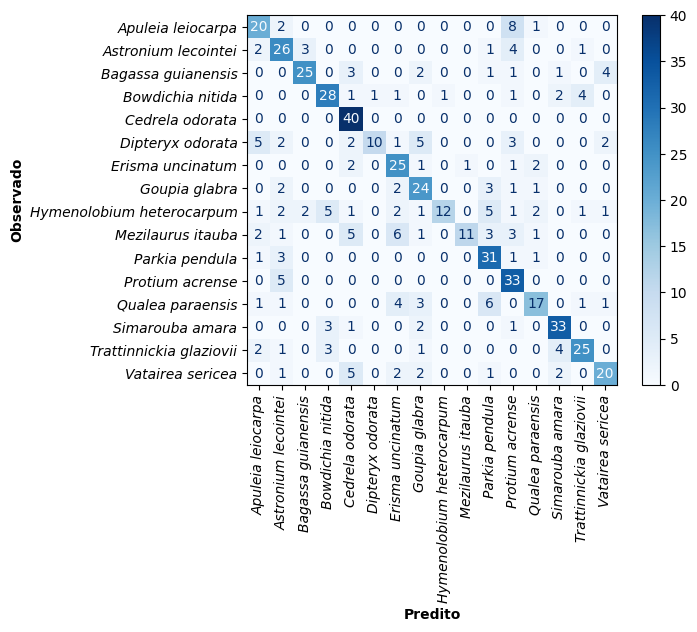

In [ ]:
# ================================================================================
# Matriz de Confusão - Conjunto de Teste (n = 566) - Voto Majoritário
# ================================================================================
cm_rf = confusion_matrix(resultado_rf['Classe_Observada'], resultado_rf['Classe_Predita'])
disp_rf = ConfusionMatrixDisplay(confusion_matrix = cm_rf, display_labels = best_rf.classes_)
disp_rf.plot(cmap = 'Blues', xticks_rotation = 90)
disp_rf.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_rf.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_rf.ax_.xaxis.set_tick_params(labelsize=10)
disp_rf.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output_patches/CNN/CM/cm_inception_rf', dpi=800, bbox_inches='tight')
plt.show()

### Linear Discriminant Analysis - LDA

In [ ]:
# ================================================================================
# Definições do estimador LDA
# ================================================================================

rs_resnet_lda = pickle.load(open("./Output/CNN/Models/rs_inception_lda.pickle", "rb"))
best_lda = rs_resnet_lda.best_estimator_
best_lda.get_params()

In [ ]:
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []


for i, (train_index, test_index) in enumerate(cv.split(X_train, y_train['Class'], groups= z_train)):
  print(f'Criando fold {i+1} >>>')
  print('='*70)

  print(f'Conjunto de treino antes da divisão: {X_train.shape}')
  print(f'Conjunto de validação antes da divisão: {X_train.shape}')

  # Separando fold de treino e validação
  x_train_fold, x_test_fold = X_train[train_index], X_train[test_index]
  y_train_fold, y_test_fold = y_train['Class'].iloc[train_index], y_train['Class'].iloc[test_index]
  z_train_fold = [name.split('_')[0] for name in z_train.iloc[train_index]]
  z_test_fold = [name.split('_')[0] for name in z_train.iloc[test_index]]
  w_train_fold = [name.split('_')[1] for name in z_train.iloc[train_index]]
  w_test_fold = [name.split('_')[1] for name in z_train.iloc[test_index]]

  print(f'Conjunto de treino após divisão: {x_train_fold.shape}')
  print(f'Conjunto de validação após divisão: {x_test_fold.shape}')
  print('='*70)
  print(f'Treinando fold {i+1} >>>')

  # Ajuste do modelo para cada fold
  best_lda.fit(x_train_fold, y_train_fold)

  print('='*70)
  print(f'Fazendo previsões para o fold {i+1}>>>')
  # Colete previsões para este fold
  fold_predictions = best_lda.predict_proba(x_test_fold)

  # Soma das probabilidades das classes dentro de cada grupo(w_test_fold)
  fold_predictions = pd.DataFrame(fold_predictions, columns=best_lda.classes_)
  fold_predictions = fold_predictions.groupby(w_test_fold).sum()

  # Encontrando classe com maior probabilidade para cada grupo(w_test_fold)
  fold_predictions = fold_predictions.idxmax(axis=1)

  # Obtain the observed class for each group(w_test_fold)
  fold_obs = y_test_fold.groupby(w_test_fold).first()

  # Obtendo métricas por fold
  accuracy_fold = accuracy_score(fold_obs, fold_predictions)
  f1_fold = f1_score(fold_obs, fold_predictions, average='weighted')
  recall_fold = recall_score(fold_obs, fold_predictions, average='weighted')
  precision_fold = precision_score(fold_obs, fold_predictions, average='weighted')

  print('='*70)
  print(f'Listando métricas para o fold {i+1}>>>')
  # Listando métricas
  accuracy_scores.append(accuracy_fold)
  f1_scores.append(f1_fold)
  recall_scores.append(recall_fold)
  precision_scores.append(precision_fold)

  print(f'Fold {i+1} finalizado!!!')
  print('*'*70)

# Salvando o modelo
print('='*70)
print('Salvando modelo...')
save_model_pickle(best_lda, 'best_inception_lda')
save_model_joblib(best_lda, 'best_inception_lda')

print('MODELO SALVO!')

In [ ]:
#===============================================================================
# Visualizando métricas por fold - Conjunto de Validação - Voto Majoritário
#===============================================================================

print('='*70)
print("Métricas por fold:")
print('='*70)
for i in range(len(accuracy_scores)):
    print(f"Fold {i+1}: Accuracy={accuracy_scores[i]:.4f}, F1={f1_scores[i]:.4f}, Recall={recall_scores[i]:.4f}, Precision={precision_scores[i]:.4f}")

# Calculando média das métricas
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
min_acc = np.min(accuracy_scores)
max_acc = np.max(accuracy_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
min_f1 = np.min(f1_scores)
max_f1 = np.max(f1_scores)
mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)
min_recall = np.min(recall_scores)
max_recall = np.max(recall_scores)
mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
min_precision = np.min(precision_scores)
max_precision = np.max(precision_scores)

print('='*70)
print("Mean -- Standard Deviation -- Minimum Value -- Maximum Value")
print('='*70)
# Visualizando média das métricas
print(f"Accuracy -> mean: {mean_accuracy:.4f}, std: {std_accuracy:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"F1 Score -> mean: {mean_f1:.4f}, std: {std_f1:.4f}, min: {min_f1:.4f}, max: {max_f1:.4f}")
print(f"Recall -> mean: {mean_recall:.4f}, std: {std_recall:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"Precision -> mean: {mean_precision:.4f}, std: {std_precision:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")

Métricas por fold:
Fold 1: Accuracy=0.8438, F1=0.8395, Recall=0.8438, Precision=0.8587
Fold 2: Accuracy=0.8482, F1=0.8502, Recall=0.8482, Precision=0.8659
Fold 3: Accuracy=0.8705, F1=0.8693, Recall=0.8705, Precision=0.8828
Fold 4: Accuracy=0.8214, F1=0.8160, Recall=0.8214, Precision=0.8256
Fold 5: Accuracy=0.8214, F1=0.8212, Recall=0.8214, Precision=0.8336
Fold 6: Accuracy=0.8655, F1=0.8647, Recall=0.8655, Precision=0.8769
Fold 7: Accuracy=0.8259, F1=0.8277, Recall=0.8259, Precision=0.8473
Fold 8: Accuracy=0.8924, F1=0.8930, Recall=0.8924, Precision=0.9003
Fold 9: Accuracy=0.8616, F1=0.8618, Recall=0.8616, Precision=0.8720
Fold 10: Accuracy=0.8430, F1=0.8437, Recall=0.8430, Precision=0.8622
Mean -- Standard Deviation -- Minimum Value -- Maximum Value
Accuracy -> mean: 0.8494, std: 0.0221, min: 0.8214, max: 0.8924
F1 Score -> mean: 0.8487, std: 0.0228, min: 0.8160, max: 0.8930
Recall -> mean: 0.8494, std: 0.0221, min: 0.8214, max: 0.8924
Precision -> mean: 0.8625, std: 0.0214, min: 0.82

In [ ]:
#===============================================================================
# Obtendo tabela de probabilidades - 28300 patches de imagens
#===============================================================================

prob_lda = best_lda.predict_proba(X_test)
prob_lda = pd.DataFrame(prob_lda, columns = best_lda.classes_)
class_value = prob_lda.idxmax(axis=1)
prob_value = prob_lda.max(axis=1)

# Obtendo tabela de classes preditas e observadas
prob_lda = pd.DataFrame({'Classe_Predita': class_value, 'Probabilidade': prob_value})
prob_lda = pd.concat([y_test, prob_lda], axis = 1)
prob_lda

In [ ]:
#===============================================================================
# Obtendo resultado por Voto Majoritário (n= 566)
#===============================================================================

# Agrupar os dados por 'Id' e calcular a soma das probabilidades para cada classe
soma_prob_lda = prob_lda.groupby('Id').apply(lambda x: x.groupby('Classe_Predita')['Probabilidade'].sum())

#Para cada grupo de 'Id', selecionar a classe com a maior soma de probabilidades
class_lda = soma_prob_lda.groupby('Id').idxmax()

#Obter a classe observada para cada grupo de 'Id'
class_obs_lda = prob_lda.groupby('Id')['Class'].first()

# Criar um DataFrame com as informações de interesse
resultado_lda = pd.DataFrame({'Id': class_lda.index,
                          'Probabilidade': soma_prob_lda.groupby('Id').max(),
                          'Classe_Predita': class_lda.values,
                          'Classe_Observada': class_obs_lda.values})

# Exibir o resultado
resultado_lda = resultado_lda[['Probabilidade', 'Classe_Predita', 'Classe_Observada']]
# Extrair apenas o nome da classe predita
resultado_lda['Classe_Predita'] = resultado_lda['Classe_Predita'].apply(lambda x: x[1])
resultado_lda

In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================
print(classification_report(resultado_lda['Classe_Observada'], resultado_lda['Classe_Predita'], target_names= best_lda.classes_))

                           precision    recall  f1-score   support

        Apuleia leiocarpa       0.71      0.97      0.82        31
      Astronium lecointei       0.89      0.84      0.86        37
       Bagassa guianensis       0.87      0.89      0.88        37
         Bowdichia nitida       0.97      0.77      0.86        39
          Cedrela odorata       1.00      0.97      0.99        40
         Dipteryx odorata       0.76      0.83      0.79        30
         Erisma uncinatum       0.68      0.88      0.77        32
            Goupia glabra       0.68      0.85      0.76        33
Hymenolobium heterocarpum       0.91      0.56      0.69        36
        Mezilaurus itauba       0.82      0.82      0.82        33
           Parkia pendula       0.81      0.78      0.79        37
          Protium acrense       0.89      0.84      0.86        38
         Qualea paraensis       0.85      0.85      0.85        34
          Simarouba amara       0.89      0.82      0.86     

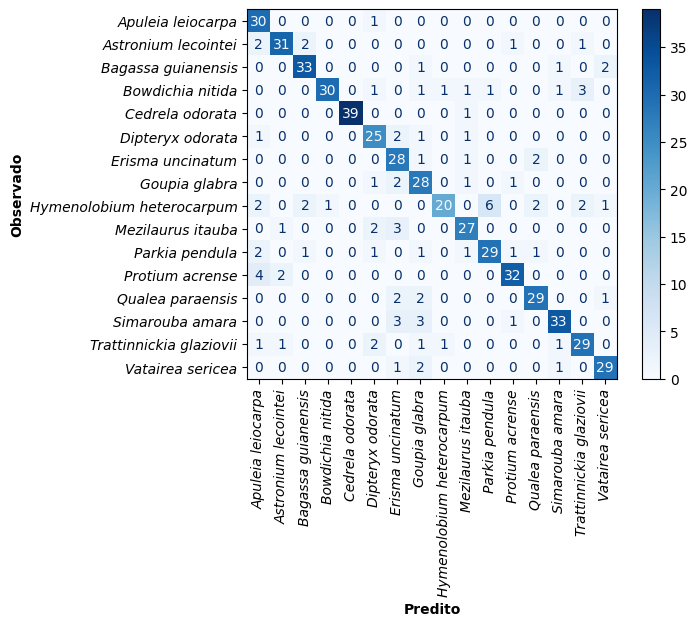

In [ ]:
# ================================================================================
# Matriz de Confusão - Conjunto de Teste (n = 566) - Voto Majoritário
# ================================================================================
cm_lda = confusion_matrix(resultado_lda['Classe_Observada'], resultado_lda['Classe_Predita'])
disp_lda = ConfusionMatrixDisplay(confusion_matrix = cm_lda, display_labels = best_lda.classes_)
disp_lda.plot(cmap = 'Blues', xticks_rotation = 90)
disp_lda.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_lda.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_lda.ax_.xaxis.set_tick_params(labelsize=10)
disp_lda.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output_patches/CNN/CM/cm_inception_lda', dpi=800, bbox_inches='tight')
plt.show()

## **MobileNet_V2**

In [ ]:
#-----------------------------------------------------------------------------#
# Carregar o arquivo .npz
#-----------------------------------------------------------------------------#
with np.load('./Output_patches/CNN/Features/patches_mobnet_train.npz', mmap_mode= 'r', allow_pickle=True) as f:
    X_train = f['X_train']
    y_train = f['y_train']

with np.load('./Output_patches/CNN/Features/patches_mobnet_test.npz', mmap_mode= 'r', allow_pickle=True) as f:
    X_test = f['X_test']
    y_test = f['y_test']

In [ ]:
#-----------------------------------------------------------------------------#
# Tamanho do conjunto do vetor de features MobileNet
#-----------------------------------------------------------------------------#
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

In [ ]:
#-----------------------------------------------------------------------------#
# Dividindo variáveis
#-----------------------------------------------------------------------------#

dic = { 0: 'Patch', 1: 'Class', 2: 'Sample', 3: 'Id', 4:'Dev'}
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

# Renomeando as colunas
y_train.rename(columns=dic, inplace=True)
y_test.rename(columns=dic, inplace=True)

display(y_train)

In [ ]:
#-----------------------------------------------------------------------------#
# Gerando coluna de código de patches
#-----------------------------------------------------------------------------#

y_test['Id'] = y_test['Dev'] + '_' + y_test['Sample'].astype(str) + '_' + y_test['Id'].astype(str)
y_train['Id'] = y_train['Dev'] + '_' + y_train['Sample'].astype(str) + '_' + y_train['Id'].astype(str)
z_train = y_train.filter(items = ['Id'])
y_train = y_train.filter(items = ['Class', 'Sample'])
display(y_test)

In [ ]:
#-----------------------------------------------------------------------------#
# Convertendo códigos - Label encoder
#-----------------------------------------------------------------------------#
'''Para inserir o código das amostras e dos patches na CV foi necessário codificar os patches e as amostras.'''

def converter_variaveis_objeto_para_int(df):
    # Inicialize o LabelEncoder
    label_encoder = LabelEncoder()

    # Itere sobre as colunas do DataFrame
    for coluna in df.columns:
        # Verifique se a coluna é do tipo 'object'
        if df[coluna].dtype == 'object':
            # Ajuste e transforme os dados usando o LabelEncoder
            df[coluna] = label_encoder.fit_transform(df[coluna])

    return df

z_train = converter_variaveis_objeto_para_int(df = z_train)
y_train = pd.concat([y_train, z_train], axis = 1)
z_train = y_train['Sample'].astype(str) + '_' + y_train['Id'].astype(str)
z_train

### Artificial Neural Networks - ANN

In [ ]:
# ================================================================================
# Definições do estimador ANN
# ================================================================================

rs_resnet_ann = pickle.load(open("./Output/CNN/Models/rs_mobnet_ann.pickle", "rb"))
best_ann = rs_resnet_ann.best_estimator_
best_ann.get_params()

In [ ]:
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []


for i, (train_index, test_index) in enumerate(cv.split(X_train, y_train['Class'], groups= z_train)):
  print(f'Criando fold {i+1} >>>')
  print('='*70)

  print(f'Conjunto de treino antes da divisão: {X_train.shape}')
  print(f'Conjunto de validação antes da divisão: {X_train.shape}')

  # Separando fold de treino e validação
  x_train_fold, x_test_fold = X_train[train_index], X_train[test_index]
  y_train_fold, y_test_fold = y_train['Class'].iloc[train_index], y_train['Class'].iloc[test_index]
  z_train_fold = [name.split('_')[0] for name in z_train.iloc[train_index]]
  z_test_fold = [name.split('_')[0] for name in z_train.iloc[test_index]]
  w_train_fold = [name.split('_')[1] for name in z_train.iloc[train_index]]
  w_test_fold = [name.split('_')[1] for name in z_train.iloc[test_index]]

  print(f'Conjunto de treino após divisão: {x_train_fold.shape}')
  print(f'Conjunto de validação após divisão: {x_test_fold.shape}')
  print('='*70)
  print(f'Treinando fold {i+1} >>>')

  # Ajuste do modelo para cada fold
  best_ann.fit(x_train_fold, y_train_fold)

  print('='*70)
  print(f'Fazendo previsões para o fold {i+1}>>>')
  # Colete previsões para este fold
  fold_predictions = best_ann.predict_proba(x_test_fold)

  # Soma das probabilidades das classes dentro de cada grupo(w_test_fold)
  fold_predictions = pd.DataFrame(fold_predictions, columns=best_ann.classes_)
  fold_predictions = fold_predictions.groupby(w_test_fold).sum()

  # Encontrando classe com maior probabilidade para cada grupo(w_test_fold)
  fold_predictions = fold_predictions.idxmax(axis=1)

  # Obtain the observed class for each group(w_test_fold)
  fold_obs = y_test_fold.groupby(w_test_fold).first()

  # Obtendo métricas por fold
  accuracy_fold = accuracy_score(fold_obs, fold_predictions)
  f1_fold = f1_score(fold_obs, fold_predictions, average='weighted')
  recall_fold = recall_score(fold_obs, fold_predictions, average='weighted')
  precision_fold = precision_score(fold_obs, fold_predictions, average='weighted')

  print('='*70)
  print(f'Listando métricas para o fold {i+1}>>>')
  # Listando métricas
  accuracy_scores.append(accuracy_fold)
  f1_scores.append(f1_fold)
  recall_scores.append(recall_fold)
  precision_scores.append(precision_fold)

  print(f'Fold {i+1} finalizado!!!')
  print('*'*70)

# Salvando o modelo
print('='*70)
print('Salvando modelo...')
save_model_pickle(best_ann, 'best_mobnet_ann')
save_model_joblib(best_ann, 'best_mobnet_ann')

print('MODELO SALVO!')

In [ ]:
#===============================================================================
# Visualizando métricas por fold - Conjunto de Validação - Voto Majoritário
#===============================================================================

print('='*70)
print("Métricas por fold:")
print('='*70)
for i in range(len(accuracy_scores)):
    print(f"Fold {i+1}: Accuracy={accuracy_scores[i]:.4f}, F1={f1_scores[i]:.4f}, Recall={recall_scores[i]:.4f}, Precision={precision_scores[i]:.4f}")

# Calculando média das métricas
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
min_acc = np.min(accuracy_scores)
max_acc = np.max(accuracy_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
min_f1 = np.min(f1_scores)
max_f1 = np.max(f1_scores)
mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)
min_recall = np.min(recall_scores)
max_recall = np.max(recall_scores)
mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
min_precision = np.min(precision_scores)
max_precision = np.max(precision_scores)

print('='*70)
print("Mean -- Standard Deviation -- Minimum Value -- Maximum Value")
print('='*70)
# Visualizando média das métricas
print(f"Accuracy -> mean: {mean_accuracy:.4f}, std: {std_accuracy:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"F1 Score -> mean: {mean_f1:.4f}, std: {std_f1:.4f}, min: {min_f1:.4f}, max: {max_f1:.4f}")
print(f"Recall -> mean: {mean_recall:.4f}, std: {std_recall:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"Precision -> mean: {mean_precision:.4f}, std: {std_precision:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")

Métricas por fold:
Fold 1: Accuracy=0.9330, F1=0.9318, Recall=0.9330, Precision=0.9347
Fold 2: Accuracy=0.9554, F1=0.9550, Recall=0.9554, Precision=0.9582
Fold 3: Accuracy=0.9420, F1=0.9418, Recall=0.9420, Precision=0.9472
Fold 4: Accuracy=0.9152, F1=0.9147, Recall=0.9152, Precision=0.9222
Fold 5: Accuracy=0.9018, F1=0.9001, Recall=0.9018, Precision=0.9103
Fold 6: Accuracy=0.9058, F1=0.9043, Recall=0.9058, Precision=0.9165
Fold 7: Accuracy=0.9420, F1=0.9429, Recall=0.9420, Precision=0.9513
Fold 8: Accuracy=0.9327, F1=0.9328, Recall=0.9327, Precision=0.9387
Fold 9: Accuracy=0.8884, F1=0.8892, Recall=0.8884, Precision=0.8952
Fold 10: Accuracy=0.9193, F1=0.9182, Recall=0.9193, Precision=0.9310
Mean -- Standard Deviation -- Minimum Value -- Maximum Value
Accuracy -> mean: 0.9236, std: 0.0199, min: 0.8884, max: 0.9554
F1 Score -> mean: 0.9231, std: 0.0201, min: 0.8892, max: 0.9550
Recall -> mean: 0.9236, std: 0.0199, min: 0.8884, max: 0.9554
Precision -> mean: 0.9305, std: 0.0187, min: 0.88

In [ ]:
#===============================================================================
# Obtendo tabela de probabilidades - 28300 patches de imagens
#===============================================================================

prob_ann = best_ann.predict_proba(X_test)
prob_ann = pd.DataFrame(prob_ann, columns = best_ann.classes_)
class_value = prob_ann.idxmax(axis=1)
prob_value = prob_ann.max(axis=1)

# Obtendo tabela de classes preditas e observadas
prob_ann = pd.DataFrame({'Classe_Predita': class_value, 'Probabilidade': prob_value})
prob_ann = pd.concat([y_test, prob_ann], axis = 1)
prob_ann

In [ ]:
#===============================================================================
# Obtendo resultado por Voto Majoritário (n= 566)
#===============================================================================

# Agrupar os dados por 'Id' e calcular a soma das probabilidades para cada classe
soma_prob_ann = prob_ann.groupby('Id').apply(lambda x: x.groupby('Classe_Predita')['Probabilidade'].sum())

#Para cada grupo de 'Id', selecionar a classe com a maior soma de probabilidades
class_ann = soma_prob_ann.groupby('Id').idxmax()

#Obter a classe observada para cada grupo de 'Id'
class_obs_ann = prob_ann.groupby('Id')['Class'].first()

# Criar um DataFrame com as informações de interesse
resultado_ann = pd.DataFrame({'Id': class_ann.index,
                          'Probabilidade': soma_prob_ann.groupby('Id').max(),
                          'Classe_Predita': class_ann.values,
                          'Classe_Observada': class_obs_ann.values})

# Exibir o resultado
resultado_ann = resultado_ann[['Probabilidade', 'Classe_Predita', 'Classe_Observada']]
# Extrair apenas o nome da classe predita
resultado_ann['Classe_Predita'] = resultado_ann['Classe_Predita'].apply(lambda x: x[1])
resultado_ann

In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================
print(classification_report(resultado_ann['Classe_Observada'], resultado_ann['Classe_Predita'], target_names= best_ann.classes_))

                           precision    recall  f1-score   support

        Apuleia leiocarpa       0.78      0.94      0.85        31
      Astronium lecointei       1.00      0.95      0.97        37
       Bagassa guianensis       0.95      0.97      0.96        37
         Bowdichia nitida       0.95      0.90      0.92        39
          Cedrela odorata       0.98      1.00      0.99        40
         Dipteryx odorata       0.96      0.80      0.87        30
         Erisma uncinatum       0.88      0.88      0.88        32
            Goupia glabra       0.76      0.94      0.84        33
Hymenolobium heterocarpum       0.85      0.92      0.88        36
        Mezilaurus itauba       1.00      0.70      0.82        33
           Parkia pendula       1.00      0.89      0.94        37
          Protium acrense       0.90      0.95      0.92        38
         Qualea paraensis       0.87      0.97      0.92        34
          Simarouba amara       0.91      1.00      0.95     

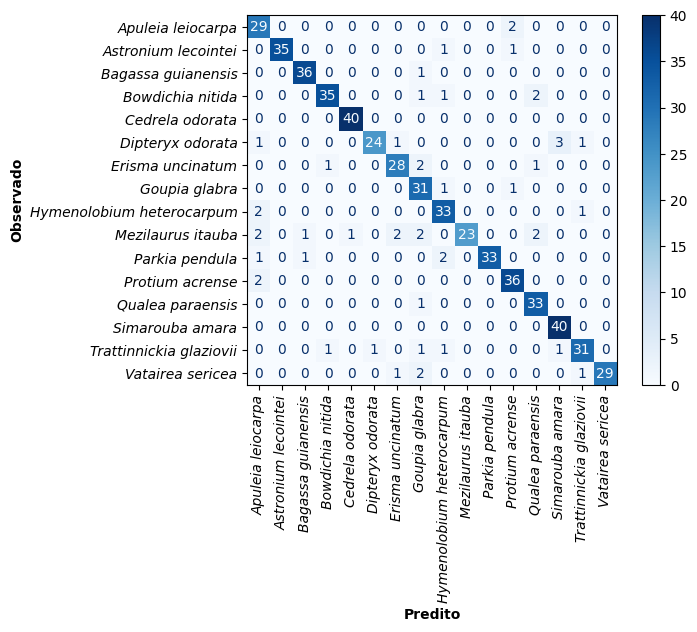

In [ ]:
# ================================================================================
# Matriz de Confusão - Conjunto de Teste (n = 566) - Voto Majoritário
# ================================================================================
cm_ann = confusion_matrix(resultado_ann['Classe_Observada'], resultado_ann['Classe_Predita'])
disp_ann = ConfusionMatrixDisplay(confusion_matrix = cm_ann, display_labels = best_ann.classes_)
disp_ann.plot(cmap = 'Blues', xticks_rotation = 90)
disp_ann.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_ann.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_ann.ax_.xaxis.set_tick_params(labelsize=10)
disp_ann.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output_patches/CNN/CM/cm_mobnet_ann', dpi=800, bbox_inches='tight')
plt.show()

### Suport Vector Classifier - SVC

In [ ]:
# ================================================================================
# Definições do estimador SVC
# ================================================================================

rs_resnet_svc = pickle.load(open("./Output/CNN/Models/rs_mobnet_svc.pickle", "rb"))
best_svc = rs_resnet_svc.best_estimator_
best_svc.get_params()

In [ ]:
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []


for i, (train_index, test_index) in enumerate(cv.split(X_train, y_train['Class'], groups= z_train)):
  print(f'Criando fold {i+1} >>>')
  print('='*70)

  print(f'Conjunto de treino antes da divisão: {X_train.shape}')
  print(f'Conjunto de validação antes da divisão: {X_train.shape}')

  # Separando fold de treino e validação
  x_train_fold, x_test_fold = X_train[train_index], X_train[test_index]
  y_train_fold, y_test_fold = y_train['Class'].iloc[train_index], y_train['Class'].iloc[test_index]
  z_train_fold = [name.split('_')[0] for name in z_train.iloc[train_index]]
  z_test_fold = [name.split('_')[0] for name in z_train.iloc[test_index]]
  w_train_fold = [name.split('_')[1] for name in z_train.iloc[train_index]]
  w_test_fold = [name.split('_')[1] for name in z_train.iloc[test_index]]

  print(f'Conjunto de treino após divisão: {x_train_fold.shape}')
  print(f'Conjunto de validação após divisão: {x_test_fold.shape}')
  print('='*70)
  print(f'Treinando fold {i+1} >>>')

  # Ajuste do modelo para cada fold
  best_svc.fit(x_train_fold, y_train_fold)

  print('='*70)
  print(f'Fazendo previsões para o fold {i+1}>>>')
  # Colete previsões para este fold
  fold_predictions = best_svc.predict_proba(x_test_fold)

  # Soma das probabilidades das classes dentro de cada grupo(w_test_fold)
  fold_predictions = pd.DataFrame(fold_predictions, columns=best_svc.classes_)
  fold_predictions = fold_predictions.groupby(w_test_fold).sum()

  # Encontrando classe com maior probabilidade para cada grupo(w_test_fold)
  fold_predictions = fold_predictions.idxmax(axis=1)

  # Obtain the observed class for each group(w_test_fold)
  fold_obs = y_test_fold.groupby(w_test_fold).first()

  # Obtendo métricas por fold
  accuracy_fold = accuracy_score(fold_obs, fold_predictions)
  f1_fold = f1_score(fold_obs, fold_predictions, average='weighted')
  recall_fold = recall_score(fold_obs, fold_predictions, average='weighted')
  precision_fold = precision_score(fold_obs, fold_predictions, average='weighted')

  print('='*70)
  print(f'Listando métricas para o fold {i+1}>>>')
  # Listando métricas
  accuracy_scores.append(accuracy_fold)
  f1_scores.append(f1_fold)
  recall_scores.append(recall_fold)
  precision_scores.append(precision_fold)

  print(f'Fold {i+1} finalizado!!!')
  print('*'*70)

# Salvando o modelo
print('='*70)
print('Salvando modelo...')
save_model_pickle(best_svc, 'best_mobnet_svc')
save_model_joblib(best_svc, 'best_mobnet_svc')

print('MODELO SALVO!')

In [ ]:
#===============================================================================
# Visualizando métricas por fold - Conjunto de Validação - Voto Majoritário
#===============================================================================

print('='*70)
print("Métricas por fold:")
print('='*70)
for i in range(len(accuracy_scores)):
    print(f"Fold {i+1}: Accuracy={accuracy_scores[i]:.4f}, F1={f1_scores[i]:.4f}, Recall={recall_scores[i]:.4f}, Precision={precision_scores[i]:.4f}")

# Calculando média das métricas
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
min_acc = np.min(accuracy_scores)
max_acc = np.max(accuracy_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
min_f1 = np.min(f1_scores)
max_f1 = np.max(f1_scores)
mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)
min_recall = np.min(recall_scores)
max_recall = np.max(recall_scores)
mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
min_precision = np.min(precision_scores)
max_precision = np.max(precision_scores)

print('='*70)
print("Mean -- Standard Deviation -- Minimum Value -- Maximum Value")
print('='*70)
# Visualizando média das métricas
print(f"Accuracy -> mean: {mean_accuracy:.4f}, std: {std_accuracy:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"F1 Score -> mean: {mean_f1:.4f}, std: {std_f1:.4f}, min: {min_f1:.4f}, max: {max_f1:.4f}")
print(f"Recall -> mean: {mean_recall:.4f}, std: {std_recall:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"Precision -> mean: {mean_precision:.4f}, std: {std_precision:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")

In [ ]:
#===============================================================================
# Obtendo tabela de probabilidades - 28300 patches de imagens
#===============================================================================

prob_svc = best_svc.predict_proba(X_test)
prob_svc = pd.DataFrame(prob_svc, columns = best_svc.classes_)
class_value = prob_svc.idxmax(axis=1)
prob_value = prob_svc.max(axis=1)

# Obtendo tabela de classes preditas e observadas
prob_svc = pd.DataFrame({'Classe_Predita': class_value, 'Probabilidade': prob_value})
prob_svc = pd.concat([y_test, prob_svc], axis = 1)
prob_svc

In [ ]:
#===============================================================================
# Obtendo resultado por Voto Majoritário (n= 566)
#===============================================================================

# Agrupar os dados por 'Id' e calcular a soma das probabilidades para cada classe
soma_prob_svc = prob_svc.groupby('Id').apply(lambda x: x.groupby('Classe_Predita')['Probabilidade'].sum())

#Para cada grupo de 'Id', selecionar a classe com a maior soma de probabilidades
class_svc = soma_prob_svc.groupby('Id').idxmax()

#Obter a classe observada para cada grupo de 'Id'
class_obs_svc = prob_svc.groupby('Id')['Class'].first()

# Criar um DataFrame com as informações de interesse
resultado_svc = pd.DataFrame({'Id': class_svc.index,
                          'Probabilidade': soma_prob_svc.groupby('Id').max(),
                          'Classe_Predita': class_svc.values,
                          'Classe_Observada': class_obs_svc.values})

# Exibir o resultado
resultado_svc = resultado_svc[['Probabilidade', 'Classe_Predita', 'Classe_Observada']]
# Extrair apenas o nome da classe predita
resultado_svc['Classe_Predita'] = resultado_svc['Classe_Predita'].apply(lambda x: x[1])
resultado_svc

In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================
print(classification_report(resultado_svc['Classe_Observada'], resultado_svc['Classe_Predita'], target_names= best_svc.classes_))

In [ ]:
# ================================================================================
# Matriz de Confusão - Conjunto de Teste (n = 566) - Voto Majoritário
# ================================================================================
cm_svc = confusion_matrix(resultado_svc['Classe_Observada'], resultado_svc['Classe_Predita'])
disp_svc = ConfusionMatrixDisplay(confusion_matrix = cm_svc, display_labels = best_svc.classes_)
disp_svc.plot(cmap = 'Blues', xticks_rotation = 90)
disp_svc.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_svc.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_svc.ax_.xaxis.set_tick_params(labelsize=10)
disp_svc.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output_patches/CNN/CM/cm_mobnet_svc', dpi=800, bbox_inches='tight')
plt.show()

### Random Forest - RF

In [ ]:
# ================================================================================
# Definições do estimador RF
# ================================================================================

rs_resnet_rf = pickle.load(open("./Output/CNN/Models/rs_mobnet_rf.pickle", "rb"))
best_rf = rs_resnet_rf.best_estimator_
best_rf.get_params()

In [ ]:
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []

for i, (train_index, test_index) in enumerate(cv.split(X_train, y_train['Class'], groups= z_train)):
  print(f'Criando fold {i+1} >>>')
  print('='*70)

  print(f'Conjunto de treino antes da divisão: {X_train.shape}')
  print(f'Conjunto de validação antes da divisão: {X_train.shape}')

  # Separando fold de treino e validação
  x_train_fold, x_test_fold = X_train[train_index], X_train[test_index]
  y_train_fold, y_test_fold = y_train['Class'].iloc[train_index], y_train['Class'].iloc[test_index]
  z_train_fold = [name.split('_')[0] for name in z_train.iloc[train_index]]
  z_test_fold = [name.split('_')[0] for name in z_train.iloc[test_index]]
  w_train_fold = [name.split('_')[1] for name in z_train.iloc[train_index]]
  w_test_fold = [name.split('_')[1] for name in z_train.iloc[test_index]]

  print(f'Conjunto de treino após divisão: {x_train_fold.shape}')
  print(f'Conjunto de validação após divisão: {x_test_fold.shape}')
  print('='*70)
  print(f'Treinando fold {i+1} >>>')

  # Ajuste do modelo para cada fold
  best_rf.fit(x_train_fold, y_train_fold)

  print('='*70)
  print(f'Fazendo previsões para o fold {i+1}>>>')
  # Colete previsões para este fold
  fold_predictions = best_rf.predict_proba(x_test_fold)

  # Soma das probabilidades das classes dentro de cada grupo(w_test_fold)
  fold_predictions = pd.DataFrame(fold_predictions, columns=best_rf.classes_)
  fold_predictions = fold_predictions.groupby(w_test_fold).sum()

  # Encontrando classe com maior probabilidade para cada grupo(w_test_fold)
  fold_predictions = fold_predictions.idxmax(axis=1)

  # Obtain the observed class for each group(w_test_fold)
  fold_obs = y_test_fold.groupby(w_test_fold).first()

  # Obtendo métricas por fold
  accuracy_fold = accuracy_score(fold_obs, fold_predictions)
  f1_fold = f1_score(fold_obs, fold_predictions, average='weighted')
  recall_fold = recall_score(fold_obs, fold_predictions, average='weighted')
  precision_fold = precision_score(fold_obs, fold_predictions, average='weighted')

  print('='*70)
  print(f'Listando métricas para o fold {i+1}>>>')
  # Listando métricas
  accuracy_scores.append(accuracy_fold)
  f1_scores.append(f1_fold)
  recall_scores.append(recall_fold)
  precision_scores.append(precision_fold)

  print(f'Fold {i+1} finalizado!!!')
  print('*'*70)

# Salvando o modelo
print('='*70)
print('Salvando modelo...')
save_model_pickle(best_rf, 'best_mobnet_rf')
save_model_joblib(best_rf, 'best_mobnet_rf')

print('MODELO SALVO!')

In [ ]:
#===============================================================================
# Visualizando métricas por fold - Conjunto de Validação - Voto Majoritário
#===============================================================================

print('='*70)
print("Métricas por fold:")
print('='*70)
for i in range(len(accuracy_scores)):
    print(f"Fold {i+1}: Accuracy={accuracy_scores[i]:.4f}, F1={f1_scores[i]:.4f}, Recall={recall_scores[i]:.4f}, Precision={precision_scores[i]:.4f}")

# Calculando média das métricas
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
min_acc = np.min(accuracy_scores)
max_acc = np.max(accuracy_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
min_f1 = np.min(f1_scores)
max_f1 = np.max(f1_scores)
mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)
min_recall = np.min(recall_scores)
max_recall = np.max(recall_scores)
mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
min_precision = np.min(precision_scores)
max_precision = np.max(precision_scores)

print('='*70)
print("Mean -- Standard Deviation -- Minimum Value -- Maximum Value")
print('='*70)
# Visualizando média das métricas
print(f"Accuracy -> mean: {mean_accuracy:.4f}, std: {std_accuracy:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"F1 Score -> mean: {mean_f1:.4f}, std: {std_f1:.4f}, min: {min_f1:.4f}, max: {max_f1:.4f}")
print(f"Recall -> mean: {mean_recall:.4f}, std: {std_recall:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"Precision -> mean: {mean_precision:.4f}, std: {std_precision:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")

Métricas por fold:
Fold 1: Accuracy=0.7589, F1=0.7470, Recall=0.7589, Precision=0.7912
Fold 2: Accuracy=0.7902, F1=0.7867, Recall=0.7902, Precision=0.8120
Fold 3: Accuracy=0.7812, F1=0.7732, Recall=0.7812, Precision=0.8145
Fold 4: Accuracy=0.7098, F1=0.6966, Recall=0.7098, Precision=0.7494
Fold 5: Accuracy=0.7098, F1=0.6992, Recall=0.7098, Precision=0.7508
Fold 6: Accuracy=0.7848, F1=0.7731, Recall=0.7848, Precision=0.8010
Fold 7: Accuracy=0.7812, F1=0.7787, Recall=0.7812, Precision=0.8003
Fold 8: Accuracy=0.7982, F1=0.7904, Recall=0.7982, Precision=0.8058
Fold 9: Accuracy=0.7455, F1=0.7358, Recall=0.7455, Precision=0.7714
Fold 10: Accuracy=0.7489, F1=0.7338, Recall=0.7489, Precision=0.7601
Mean -- Standard Deviation -- Minimum Value -- Maximum Value
Accuracy -> mean: 0.7609, std: 0.0304, min: 0.7098, max: 0.7982
F1 Score -> mean: 0.7515, std: 0.0328, min: 0.6966, max: 0.7904
Recall -> mean: 0.7609, std: 0.0304, min: 0.7098, max: 0.7982
Precision -> mean: 0.7856, std: 0.0241, min: 0.70

In [ ]:
#===============================================================================
# Obtendo tabela de probabilidades - 28300 patches de imagens
#===============================================================================

prob_rf = best_rf.predict_proba(X_test)
prob_rf = pd.DataFrame(prob_rf, columns = best_rf.classes_)
class_value = prob_rf.idxmax(axis=1)
prob_value = prob_rf.max(axis=1)

# Obtendo tabela de classes preditas e observadas
prob_rf = pd.DataFrame({'Classe_Predita': class_value, 'Probabilidade': prob_value})
prob_rf = pd.concat([y_test, prob_rf], axis = 1)
prob_rf

In [ ]:
#===============================================================================
# Obtendo resultado por Voto Majoritário (n= 566)
#===============================================================================

# Agrupar os dados por 'Id' e calcular a soma das probabilidades para cada classe
soma_prob_rf = prob_rf.groupby('Id').apply(lambda x: x.groupby('Classe_Predita')['Probabilidade'].sum())

#Para cada grupo de 'Id', selecionar a classe com a maior soma de probabilidades
class_rf = soma_prob_rf.groupby('Id').idxmax()

#Obter a classe observada para cada grupo de 'Id'
class_obs_rf = prob_rf.groupby('Id')['Class'].first()

# Criar um DataFrame com as informações de interesse
resultado_rf = pd.DataFrame({'Id': class_rf.index,
                          'Probabilidade': soma_prob_rf.groupby('Id').max(),
                          'Classe_Predita': class_rf.values,
                          'Classe_Observada': class_obs_rf.values})

# Exibir o resultado
resultado_rf = resultado_rf[['Probabilidade', 'Classe_Predita', 'Classe_Observada']]
# Extrair apenas o nome da classe predita
resultado_rf['Classe_Predita'] = resultado_rf['Classe_Predita'].apply(lambda x: x[1])
resultado_rf

In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================
print(classification_report(resultado_rf['Classe_Observada'], resultado_rf['Classe_Predita'], target_names= best_rf.classes_))

                           precision    recall  f1-score   support

        Apuleia leiocarpa       0.58      0.84      0.68        31
      Astronium lecointei       0.69      0.78      0.73        37
       Bagassa guianensis       0.70      0.84      0.77        37
         Bowdichia nitida       0.82      0.85      0.84        39
          Cedrela odorata       0.82      1.00      0.90        40
         Dipteryx odorata       0.83      0.50      0.62        30
         Erisma uncinatum       0.61      0.78      0.68        32
            Goupia glabra       0.71      0.61      0.66        33
Hymenolobium heterocarpum       0.85      0.31      0.45        36
        Mezilaurus itauba       0.86      0.36      0.51        33
           Parkia pendula       0.77      0.89      0.82        37
          Protium acrense       0.67      0.87      0.76        38
         Qualea paraensis       0.71      0.79      0.75        34
          Simarouba amara       0.77      0.85      0.81     

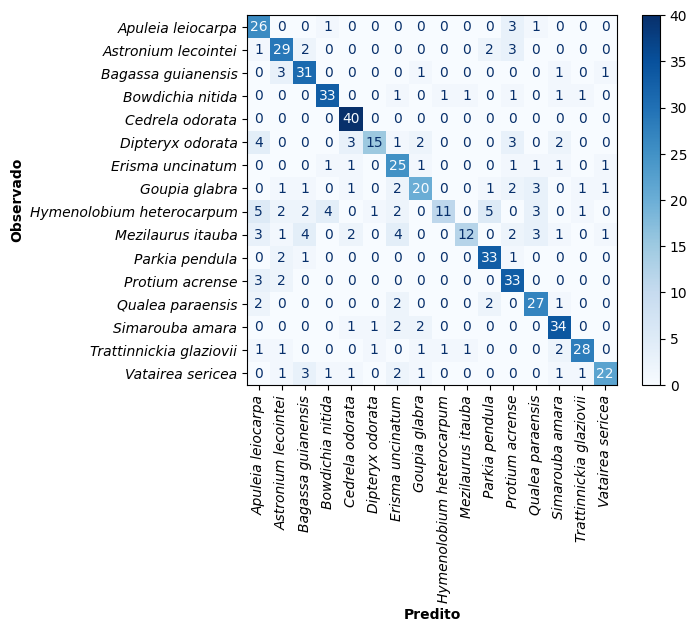

In [ ]:
# ================================================================================
# Matriz de Confusão - Conjunto de Teste (n = 566) - Voto Majoritário
# ================================================================================
cm_rf = confusion_matrix(resultado_rf['Classe_Observada'], resultado_rf['Classe_Predita'])
disp_rf = ConfusionMatrixDisplay(confusion_matrix = cm_rf, display_labels = best_rf.classes_)
disp_rf.plot(cmap = 'Blues', xticks_rotation = 90)
disp_rf.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_rf.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_rf.ax_.xaxis.set_tick_params(labelsize=10)
disp_rf.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output_patches/CNN/CM/cm_mobnet_rf', dpi=800, bbox_inches='tight')
plt.show()

### Linear Discriminant Analysis - LDA

In [ ]:
# ================================================================================
# Definições do estimador LDA
# ================================================================================

rs_resnet_lda = pickle.load(open("./Output/CNN/Models/rs_mobnet_lda.pickle", "rb"))
best_lda = rs_resnet_lda.best_estimator_
best_lda.get_params()

In [ ]:
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []


for i, (train_index, test_index) in enumerate(cv.split(X_train, y_train['Class'], groups= z_train)):
  print(f'Criando fold {i+1} >>>')
  print('='*70)

  print(f'Conjunto de treino antes da divisão: {X_train.shape}')
  print(f'Conjunto de validação antes da divisão: {X_train.shape}')

  # Separando fold de treino e validação
  x_train_fold, x_test_fold = X_train[train_index], X_train[test_index]
  y_train_fold, y_test_fold = y_train['Class'].iloc[train_index], y_train['Class'].iloc[test_index]
  z_train_fold = [name.split('_')[0] for name in z_train.iloc[train_index]]
  z_test_fold = [name.split('_')[0] for name in z_train.iloc[test_index]]
  w_train_fold = [name.split('_')[1] for name in z_train.iloc[train_index]]
  w_test_fold = [name.split('_')[1] for name in z_train.iloc[test_index]]

  print(f'Conjunto de treino após divisão: {x_train_fold.shape}')
  print(f'Conjunto de validação após divisão: {x_test_fold.shape}')
  print('='*70)
  print(f'Treinando fold {i+1} >>>')

  # Ajuste do modelo para cada fold
  best_lda.fit(x_train_fold, y_train_fold)

  print('='*70)
  print(f'Fazendo previsões para o fold {i+1}>>>')
  # Colete previsões para este fold
  fold_predictions = best_lda.predict_proba(x_test_fold)

  # Soma das probabilidades das classes dentro de cada grupo(w_test_fold)
  fold_predictions = pd.DataFrame(fold_predictions, columns=best_lda.classes_)
  fold_predictions = fold_predictions.groupby(w_test_fold).sum()

  # Encontrando classe com maior probabilidade para cada grupo(w_test_fold)
  fold_predictions = fold_predictions.idxmax(axis=1)

  # Obtain the observed class for each group(w_test_fold)
  fold_obs = y_test_fold.groupby(w_test_fold).first()

  # Obtendo métricas por fold
  accuracy_fold = accuracy_score(fold_obs, fold_predictions)
  f1_fold = f1_score(fold_obs, fold_predictions, average='weighted')
  recall_fold = recall_score(fold_obs, fold_predictions, average='weighted')
  precision_fold = precision_score(fold_obs, fold_predictions, average='weighted')

  print('='*70)
  print(f'Listando métricas para o fold {i+1}>>>')
  # Listando métricas
  accuracy_scores.append(accuracy_fold)
  f1_scores.append(f1_fold)
  recall_scores.append(recall_fold)
  precision_scores.append(precision_fold)

  print(f'Fold {i+1} finalizado!!!')
  print('*'*70)

# Salvando o modelo
print('='*70)
print('Salvando modelo...')
save_model_pickle(best_lda, 'best_mobnet_lda')
save_model_joblib(best_lda, 'best_mobnet_lda')

print('MODELO SALVO!')

In [ ]:
#===============================================================================
# Visualizando métricas por fold - Conjunto de Validação - Voto Majoritário
#===============================================================================

print('='*70)
print("Métricas por fold:")
print('='*70)
for i in range(len(accuracy_scores)):
    print(f"Fold {i+1}: Accuracy={accuracy_scores[i]:.4f}, F1={f1_scores[i]:.4f}, Recall={recall_scores[i]:.4f}, Precision={precision_scores[i]:.4f}")

# Calculando média das métricas
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
min_acc = np.min(accuracy_scores)
max_acc = np.max(accuracy_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
min_f1 = np.min(f1_scores)
max_f1 = np.max(f1_scores)
mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)
min_recall = np.min(recall_scores)
max_recall = np.max(recall_scores)
mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
min_precision = np.min(precision_scores)
max_precision = np.max(precision_scores)

print('='*70)
print("Mean -- Standard Deviation -- Minimum Value -- Maximum Value")
print('='*70)
# Visualizando média das métricas
print(f"Accuracy -> mean: {mean_accuracy:.4f}, std: {std_accuracy:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"F1 Score -> mean: {mean_f1:.4f}, std: {std_f1:.4f}, min: {min_f1:.4f}, max: {max_f1:.4f}")
print(f"Recall -> mean: {mean_recall:.4f}, std: {std_recall:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")
print(f"Precision -> mean: {mean_precision:.4f}, std: {std_precision:.4f}, min: {min_acc:.4f}, max: {max_acc:.4f}")

Métricas por fold:
Fold 1: Accuracy=0.8705, F1=0.8665, Recall=0.8705, Precision=0.8808
Fold 2: Accuracy=0.8661, F1=0.8662, Recall=0.8661, Precision=0.8831
Fold 3: Accuracy=0.8884, F1=0.8875, Recall=0.8884, Precision=0.8985
Fold 4: Accuracy=0.8214, F1=0.8204, Recall=0.8214, Precision=0.8313
Fold 5: Accuracy=0.8348, F1=0.8346, Recall=0.8348, Precision=0.8434
Fold 6: Accuracy=0.8744, F1=0.8729, Recall=0.8744, Precision=0.8822
Fold 7: Accuracy=0.8616, F1=0.8613, Recall=0.8616, Precision=0.8722
Fold 8: Accuracy=0.8879, F1=0.8884, Recall=0.8879, Precision=0.8910
Fold 9: Accuracy=0.8304, F1=0.8298, Recall=0.8304, Precision=0.8446
Fold 10: Accuracy=0.8610, F1=0.8623, Recall=0.8610, Precision=0.8769
Mean -- Standard Deviation -- Minimum Value -- Maximum Value
Accuracy -> mean: 0.8597, std: 0.0222, min: 0.8214, max: 0.8884
F1 Score -> mean: 0.8590, std: 0.0222, min: 0.8204, max: 0.8884
Recall -> mean: 0.8597, std: 0.0222, min: 0.8214, max: 0.8884
Precision -> mean: 0.8704, std: 0.0214, min: 0.82

In [ ]:
#===============================================================================
# Obtendo tabela de probabilidades - 28300 patches de imagens
#===============================================================================

prob_lda = best_lda.predict_proba(X_test)
prob_lda = pd.DataFrame(prob_lda, columns = best_lda.classes_)
class_value = prob_lda.idxmax(axis=1)
prob_value = prob_lda.max(axis=1)

# Obtendo tabela de classes preditas e observadas
prob_lda = pd.DataFrame({'Classe_Predita': class_value, 'Probabilidade': prob_value})
prob_lda = pd.concat([y_test, prob_lda], axis = 1)
prob_lda

In [ ]:
#===============================================================================
# Obtendo resultado por Voto Majoritário (n= 566)
#===============================================================================

# Agrupar os dados por 'Id' e calcular a soma das probabilidades para cada classe
soma_prob_lda = prob_lda.groupby('Id').apply(lambda x: x.groupby('Classe_Predita')['Probabilidade'].sum())

#Para cada grupo de 'Id', selecionar a classe com a maior soma de probabilidades
class_lda = soma_prob_lda.groupby('Id').idxmax()

#Obter a classe observada para cada grupo de 'Id'
class_obs_lda = prob_lda.groupby('Id')['Class'].first()

# Criar um DataFrame com as informações de interesse
resultado_lda = pd.DataFrame({'Id': class_lda.index,
                          'Probabilidade': soma_prob_lda.groupby('Id').max(),
                          'Classe_Predita': class_lda.values,
                          'Classe_Observada': class_obs_lda.values})

# Exibir o resultado
resultado_lda = resultado_lda[['Probabilidade', 'Classe_Predita', 'Classe_Observada']]
# Extrair apenas o nome da classe predita
resultado_lda['Classe_Predita'] = resultado_lda['Classe_Predita'].apply(lambda x: x[1])
resultado_lda

In [ ]:
# ================================================================================
# Relatório de classificação (Conjunto de teste)
# ================================================================================
print(classification_report(resultado_lda['Classe_Observada'], resultado_lda['Classe_Predita'], target_names= best_lda.classes_))

                           precision    recall  f1-score   support

        Apuleia leiocarpa       0.86      0.81      0.83        31
      Astronium lecointei       0.80      0.89      0.85        37
       Bagassa guianensis       0.88      0.95      0.91        37
         Bowdichia nitida       0.97      0.85      0.90        39
          Cedrela odorata       1.00      0.97      0.99        40
         Dipteryx odorata       0.81      0.87      0.84        30
         Erisma uncinatum       0.72      0.91      0.81        32
            Goupia glabra       0.68      0.82      0.74        33
Hymenolobium heterocarpum       0.85      0.61      0.71        36
        Mezilaurus itauba       0.93      0.79      0.85        33
           Parkia pendula       0.89      0.84      0.86        37
          Protium acrense       0.89      0.87      0.88        38
         Qualea paraensis       0.76      0.91      0.83        34
          Simarouba amara       0.95      0.90      0.92     

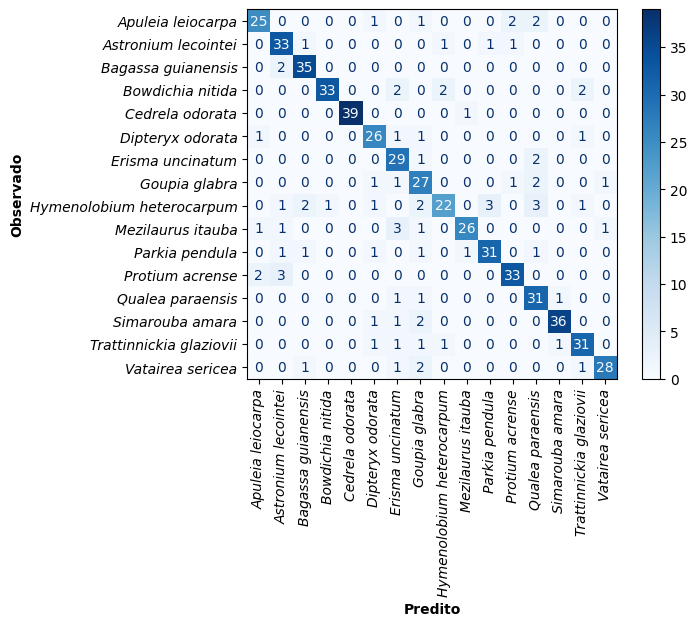

In [ ]:
# ================================================================================
# Matriz de Confusão - Conjunto de Teste (n = 566) - Voto Majoritário
# ================================================================================
cm_lda = confusion_matrix(resultado_lda['Classe_Observada'], resultado_lda['Classe_Predita'])
disp_lda = ConfusionMatrixDisplay(confusion_matrix = cm_lda, display_labels = best_lda.classes_)
disp_lda.plot(cmap = 'Blues', xticks_rotation = 90)
disp_lda.ax_.set_xlabel('Predito', fontsize=10, style='normal', fontweight = 'bold')
disp_lda.ax_.set_ylabel("Observado", fontsize=10, style='normal', fontweight = 'bold')
disp_lda.ax_.xaxis.set_tick_params(labelsize=10)
disp_lda.ax_.yaxis.set_tick_params(labelsize=10)
plt.yticks(style='italic')
plt.xticks(style='italic')

plt.savefig('./Output_patches/CNN/CM/cm_mobnet_lda', dpi=800, bbox_inches='tight')
plt.show()

# **Gráfico Recall LBP x CNN**

In [ ]:
# Importando tabelas
# LBP
lbp = pd.read_csv('./Output_patches/LBP/classification_report_lbp_ann.csv')
lbp.columns = ['Espécies', 'Precisão', 'Recall', 'F1-Score', 'Support']
lbp = lbp[:-3]
lbp = lbp.drop(columns = ['Precisão', 'F1-Score', 'Support'])
#display(lbp)

# CNN
cnn = pd.read_csv('./Output_patches/CNN/classification_report_resnet_svc.csv')
cnn.columns = ['Espécies', 'Precisão', 'Recall', 'F1-Score', 'Support']
cnn = cnn[:-3]
cnn = cnn.drop(columns = ['Precisão', 'F1-Score', 'Support'])
#display(cnn)

recalls = pd.concat([lbp, cnn['Recall']], axis = 1)
recalls.columns = ['Espécies', 'LBP + RNA', 'ResNet50+MVS']

recalls['LBP + RNA'] = (recalls['LBP + RNA'] * 100).round(2)
recalls['ResNet50+MVS'] = (recalls['ResNet50+MVS'] * 100).round(2)

In [ ]:
# Convertendo os dados para um formato adequado ao plotnine
dados_long = recalls.melt(id_vars=['Espécies'], var_name='Abordagem', value_name='Recall')

# Ordenando os dados
df_sorted = dados_long.sort_values(by='Recall', ascending=False)

# Definindo cores personalizadas para as barras
cores_personalizadas = ['#c6d0f5', '#6d85db']  # Cor para LBP e Cor para CNN '#9eb8f1', '#446eb5'

# Criando o gráfico de barras
grafico = (ggplot(df_sorted, aes(x='Espécies', y='Recall', fill='Abordagem', label = 'Recall'))
           + geom_bar(stat='identity', position=position_dodge(width=0.9))
           + geom_text(aes(label= 'Recall'), position=position_dodge(width=1),va='center', size=5)
           + coord_flip()  # Inverter eixos
           + theme_classic()  # Estilo do gráfico
           + theme(axis_text=element_text(size=10), legend_title=element_text(text=""), axis_text_y=element_text(face="italic", size=10),
                   legend_position= 'bottom')
           + ylab("Taxa de reconhecimento por espécie (%)")
           + xlab("Espécies")
           + scale_fill_manual(values=cores_personalizadas)  # Definir cores personalizadas
           + scale_y_continuous(limits=[0, 100], breaks=[0, 25, 50, 75, 100])  # Definir intervalo do eixo x
           )

# Exibindo o gráfico
print(grafico)

#ggsave(grafico, './Output_patches/Recall_LBP_CNN.png', dpi=800, bbox_inches='tight')